# Text Classification - PyTorch - poc Lilly

Les librairies nécessaires

In [1]:
# path to anaconda : C:\ProgramData\Anaconda3

from __future__ import unicode_literals, print_function, division
import os
from io import open
import unicodedata
import string
import time
import math
import re
import json
import random
import itertools
import copy

In [2]:
import sys
sys.version

'3.7.0 (default, Jun 28 2018, 08:04:48) [MSC v.1912 64 bit (AMD64)]'

In [3]:
# for manipulating dataframes, arrays, containers...
import numpy as np
np.set_printoptions(threshold=np.nan)
import pandas as pd
import unidecode
from unidecode import unidecode

# equivalent of numpy for very large arrays (such as a database of pretrained word vectors)
# optimized for SQL-like operations, not for math computations
# see https://bcolz.readthedocs.io/en/latest/intro.html

# installer avec la commande : conda install bcolz
import bcolz

import pickle

In [4]:
# for viz
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker #, FuncFormatter
%matplotlib inline

import seaborn as sns

In [5]:
# for machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import euclidean_distances

In [6]:
# for deep learning
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

print(torch.__version__)

use_cuda = False
print(torch.cuda.is_available())

import warnings
warnings.filterwarnings("ignore")

0.4.1
True


In [7]:
# for NLP
import gensim
from gensim.models import KeyedVectors

import nltk
#nltk.download()
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem.porter import PorterStemmer

from textblob import TextBlob

In [8]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
path_to_rep = 'C:\\Users\jbaujogue\Desktop\Scripts'

# 1. Import du corpus

### 1.1 Import initial

**Import**

In [10]:
# mélange préalable du jeu de donnée
#xl = pd.ExcelFile(path_to_rep + '\data\Tickets_Lilly\Packaging_Incidents.xlsx')
#print(xl.sheet_names)
#df_Lilly = xl.parse('Sheet1')
#df_Lilly.head()
#df_Lilly = df_Lilly.sample(frac=1).reset_index(drop=True)
#writer = pd.ExcelWriter('tickets_lilly_shuffle.xlsx', engine='xlsxwriter')
#df_Lilly.to_excel(writer)
#writer.save()

In [11]:
xl = pd.ExcelFile(path_to_rep + '\data\Tickets_Lilly\\tickets_lilly_shuffle.xlsx' )
print(xl.sheet_names)
df_Lilly = xl.parse('Sheet1')
df_Lilly = df_Lilly[['Description', 'Resolution Code', 'Area', 'Resolve Notes', 'Analyse']].dropna()
df_Lilly = df_Lilly.reset_index(drop=True)
df_Lilly.head()

['Sheet1']


,Description,Resolution Code,Area,Resolve Notes,Analyse
0,Appel de \r\n\r\nPoste bloqué - message d'erre...,Software,Error Message,• [Résumé] : Impossible d'utiliser le LIMOS ca...,Infra/Citrix/Mq
1,Reception des messages d'interface en erreur s...,Software/InterfaceError/BusinessError,Data Error/Missing,• [Résumé] Msg en erreur: WESSTOCKREMOVAL + WE...,Lcmovementerror
2,Ouvert actuellement sur MAN2LIGN le lot C84523...,Software/InterfaceError/BusinessError,Software Errors,• [Résumé] Ouvert actuellement sur MAN2LIGN le...,Ticket/Hesap/Hestsi
3,Message envoyé le 12/03/2018 08:55:54\tref_rel...,Monitoring,Data Error/Missing,• [Résumé] Ticket de monitoring quotidien des ...,Dailyinterfacemonitoring
4,Appel de l'operateur pour signaler que l'alarm...,Infra/Other,Other,• [Résumé] Appel de l'operateur pour signaler ...,Matrikon/Alarme


**Chargement du corpus de textes**

In [12]:
# descriptiond d'incident seules
#X = df_Lilly['Description'].values.tolist()


# descriptions + note de résolution
X = [a + '. ' + b for a, b in zip(df_Lilly['Description'].values.tolist(), df_Lilly['Resolve Notes'].values.tolist())]


# toutes les colonnes
#X = [a + b + c + d for a, b, c, d in zip(df_Lilly['Description'].values.tolist(),
#                           df_Lilly['Resolution Code'].values.tolist(),
#                           df_Lilly['Area'].values.tolist(),
#                           df_Lilly['Resolve Notes'].values.tolist())]

**Chargement des labels**

In [13]:
Y = df_Lilly['Analyse'].values.tolist()
Analyse_list = df_Lilly['Analyse'].unique()
Analyse_code2num = {}
Analyse_num2code = {}
for i, el in enumerate(Analyse_list) :
    Analyse_code2num[el] = i
    Analyse_num2code[i] = el

In [14]:
Y_int = [Analyse_code2num[el] for el in Y]

### 1.2 Nettoyage de documents

In [15]:
def mostCommonWords(X): # ------------------------------------------------   [str]
    raw_corpus = ' '.join(X) # --------------------------------------------   str
    raw2_corpus = nltk.sent_tokenize(raw_corpus) # ------------------------  [str]
    raw3_corpus =  [nltk.word_tokenize(sent) for sent in raw2_corpus] # --- [[str]]
    allwords_corpus = list(itertools.chain(*raw3_corpus))
    print('The document collection has natively', len(allwords_corpus),'words')
    freq = nltk.FreqDist(allwords_corpus)
    return freq

**Nettoyage complet de chaque document**

In [ ]:
def unicodeToAscii(s):
    """Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427"""
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )


def normalizeString(s):
    '''Remove rare symbols from a string'''
    s = unicodeToAscii(s.strip())
    s = re.sub(r"[^a-zA-Z\.]+", r" ", s)  # 'r' before a string is for 'raw' # ?&\%\_\- removed # set('''.,:;()*#&-_%!?/\'")''')
    return s

In [16]:
def cleanDocument(text): # -------------------------  str
    sw = ['']
    #sw += nltk.corpus.stopwords.words('english')
    #sw += nltk.corpus.stopwords.words('french')
    
    def wordTokenizerFunction():
        # base version
        function = lambda sentence : sentence.strip().split()
        
        # Lilly version
        #tokenizer = RegexpTokenizer("\W'+|\$[\d\.]+|\S+")
        #function = tokenizer.tokenize
        
        # nltk version
        #function = word_tokenize    
        return function
    
    
    # 1 - caractères spéciaux
    def clean_sentence_punct(text): # --------------  str
        text = text.replace('=>', 'Donc ')
        text = text.replace('(-)+>', 'Donc ')
        text = text.replace('.zip', 'zip')
        text = text.replace('loc.', 'loc')
        text = text.replace('checkliste', 'checklist')
        text = text.replace('close loop', 'closeloop')
        text = re.sub('>(\s)*0', 'positive', text)
        text = re.sub('\#[0-9]+', 'palettenumber', text)
        text = re.sub('[0-9]+\-[0-9]+\-[0-9]*', 'datenumber', text)
        text = re.sub('[0-9]+\:[0-9]+\:[0-9]*', 'heurenumber', text)
        text = re.sub('\n', '.', text)
        text = re.sub('\•', '.', text)
        text = normalizeString(text)
        return text
    
    
    # 2 - split des phrases
    def sentenceSplit(text): # ---------------------  str
        list_of_sentences = text.split('.')
        #list_of_sentences = sent_tokenize(text)
        list_of_sentences = [sentence for sentence in list_of_sentences if sentence != '']
        return list_of_sentences
    
    
    # 3 - split des mots
    def wordSplit(text, tokenizeur): # ------------- [str]
        list_of_list_of_words = [tokenizeur(sentence) for sentence in text]
        return list_of_list_of_words
    
    
    # 4 - mise en minuscule et enlèvement des stopwords
    def stopwordsRemoval(text, sw): # ------------- [[str]]
        list_of_list_of_words = [[word.lower() for word in sentence if word not in sw and len(word) > 1] for sentence in text]
        list_of_list_of_words = [sentence for sentence in list_of_list_of_words if sentence != []]
        return list_of_list_of_words
    
    
    # 6 - remplacement des POS spéciaux
    def POSDetection(text):
        def choose(word):
            token_list = ['NNP']#, 'CD',  'LS', 'UH'] # see nltk.help.upenn_tagset()
            paire = nltk.pos_tag([word])[0]
            return paire[0] if paire[1] not in token_list else 'Token_'+paire[1]
        list_of_list_of_words = [[choose(word) for word in sentence if choose(word) != ''] for sentence in text]
        return list_of_list_of_words
    
    
    # 7 - stemming
    def stemming(text): # ------------------------- [[str]]
        list_of_list_of_words = [[PorterStemmer().stem(word) for word in sentence if word not in sw] for sentence in text]
        return list_of_list_of_words
    
    
    # 8 - reformation
    def reform(text): # --------------------------- [[str]]
        return ' '.join([' '.join(sentence) for sentence in text])
    
    tokenizeur = wordTokenizerFunction()
    text = clean_sentence_punct(text)
    text = sentenceSplit(text)
    text = wordSplit(text, tokenizeur)
    text = stopwordsRemoval(text, sw)
    #text = POSDetection(text)
    #text = stemming(text)
    #text = reform(text)
    return text

In [17]:
X_clean = [cleanDocument(text) for text in X]

**Réduction des textes trop longs**

In [18]:
def filterTooLong(X, niv = 750):
    def filteTexte(texte):
        sortie = []
        count = 0
        for sentence in texte :
            sortie.append(sentence[:niv-count])
            count += len(sentence)
            if count > niv :
                break
        return sortie
    X_out = [filteTexte(x) for x in X] 
    return X_out

In [19]:
X_short = filterTooLong(X_clean)

**Split Train / Test**

In [20]:
def splitDevTest(X, Y, ratio_tst, random_state = 42):
    
    def computePartition(Y) :
        partition = {}
        for j in np.unique(Y) :
            partition[j] = []
        for i, code in enumerate(Y):
            partition[code].append(i)
        return partition
    
    
    partition = computePartition(Y)
    liste_dev = []
    liste_tst = []
    for i in partition.keys():
        np.random.seed(random_state)
        nbre_dev = int((1-ratio_tst)*len(partition[i]))
        np.random.shuffle(partition[i])
        liste_dev += partition[i][:nbre_dev]
        liste_tst += partition[i][nbre_dev:]
    X_dev = [X[i] for i in liste_dev]
    X_tst = [X[i] for i in liste_tst]

    Y_dev = [Y[i] for i in liste_dev]
    Y_tst = [Y[i] for i in liste_tst]
    return X_dev, X_tst, Y_dev, Y_tst

In [21]:
X_dev, X_tst, Y_dev, Y_tst = splitDevTest(X_short, Y_int, ratio_tst = 0.2, random_state = 42)

**Conversion en data pytorch**

In [22]:
def DLprep(X, Y):
    X_torch = X
    Y_torch = torch.LongTensor(Y).view(-1, 1) # dim = (L, 1)
    return X_torch, Y_torch

In [23]:
X_dev_torch, Y_dev_torch = DLprep(X_dev, Y_dev)
X_tst_torch, Y_tst_torch = DLprep(X_tst, Y_tst)

**Split pour validation croisée**

In [24]:
def splitCrossVal(X, Y, n_split, random_state = 42):
    
    def computePartition(Y) :
        partition = {}
        for j in np.unique(Y) :
            partition[j] = []
        for i, code in enumerate(Y):
            partition[code].append(i)
        return partition
    
    
    Data = [[] for i in range(n_split)]
    data = [[] for i in range(n_split)]
    partition = computePartition(Y)
    
    for i in partition.keys():
        np.random.seed(random_state)
        np.random.shuffle(partition[i])
        for j, el in enumerate(partition[i]):
            
            data[j % n_split].append(el)
    for k in range(n_split):
        Data[k] = [[X[el] for el in data[k]], [Y[el] for el in data[k]]]
    
    return Data

In [25]:
cross_val_data = splitCrossVal(X_dev, Y_dev, n_split = 5, random_state = 42)

# 2. Language

### 2.1 Classe de language

In [26]:
SOS_token = 0
EOS_token = 1
UNK_token = 2

class Lang:
    def __init__(self, name, init = 0):
        self.name = name
        if init == 0 :
            self.word2index = {}
            self.word2count = {}
            self.index2word = {}
            self.n_words = 0
        elif init == 3 :
            self.word2index = {"SOS": 0, "EOS": 1, "UNK": 2}
            self.word2count = {"SOS": 0, "EOS": 0, "UNK": 0}
            self.index2word = {0: "SOS", 1: "EOS", 2: "UNK"}
            self.n_words = 3

        
    def addWord(self, word):
        '''Add a word to the language'''
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
            
            
    def addSentence(self, sentence):
        '''Add to the language all words of a sentence'''
        if type(sentence) == str :
            for word in sentence.split():
                self.addWord(word)
        elif type(sentence) == list :
            for word in sentence:
                self.addWord(word)            
            
            
    def addDescriptions(self, descriptions):
        '''Add to the language all words contained into : either all user utterances 
          (if i = 0) or all bot utterances (if i = 1), of a list of dialogues'''
        for description in descriptions :
            
            # si la description est une seule ligne
            if type(description) == str :
                    try :
                        self.addSentence(description)
                    except IndexError:
                        print("Problem with {}".format(description))
                        
            # si la description est une liste de lignes
            elif type(description) == list :
                for line in description:
                    try :
                        self.addSentence(line)
                    except IndexError:
                        print("Problem with {}".format(line))
                              
            # sinon
            else :
                print("Problem with {}".format(description))

In [27]:
def generateLanguageFromNumpy(descriptions, init = 0):
    lang = Lang('descriptions', init)
    lang.addDescriptions(descriptions)
    print("Mots comptés : ", lang.n_words)
    return lang


def generateLanguageFromPanda(df, i):
    descriptions = df.ix[:, i].values
    lang = Lang('descriptions')
    lang.addDescriptions(descriptions)
    print("Mots comptés : ", lang.n_words)
    return lang

Comparaison des vocabulaires dev / test

In [61]:
lang_dev = generateLanguageFromNumpy(X_dev)
lang_tst = generateLanguageFromNumpy(X_tst)

Mots comptés :  3454
Mots comptés :  1919


In [62]:
def compare_langs(lang1, lang2) :
    diff1 = [word for word in lang1.word2index.keys() if word not in lang2.word2index.keys()]
    diff2 = [word for word in lang2.word2index.keys() if word not in lang1.word2index.keys()]
    return diff1, diff2

In [63]:
diff1, diff2 = compare_langs(lang_dev, lang_tst)

In [64]:
print(len(diff1), len(diff2))

2010 475


In [65]:
diff2

['fermture',
 'modules',
 'visibles',
 'pdsocketrequesthandlerfactory',
 'core',
 'pdnet',
 'pdsockcmdlst',
 'pdsocketcommandlistener',
 'operator',
 'pdexception',
 'palsession',
 'pddbconn',
 'sys',
 'servererror',
 'quoted',
 'properly',
 'terminated',
 'rwdbconnection',
 'thread',
 'closed',
 'live',
 'references',
 'produkt',
 'palsrv',
 'palsrvdll',
 'palsessionmanager',
 'pdpalsessionmanager',
 'sockdisconnectclient',
 'leaky',
 'closing',
 'sessionid',
 'redemarree',
 'dbas',
 'checked',
 'alert',
 'listener',
 'find',
 'anything',
 'interval',
 'between',
 'classified',
 'shot',
 'reopened',
 'reported',
 'pkgctxt',
 'corection',
 'storefront',
 'poru',
 'debloquer',
 'auparavant',
 'pre',
 'patching',
 'arretees',
 'fonctionnaient',
 'puissent',
 'responsables',
 'prevenus',
 'perturbation',
 'restes',
 'utilisant',
 'essayent',
 'gru',
 'vc',
 'explique',
 'gro',
 'lost',
 'reguls',
 'tord',
 'eqiupe',
 'vianex',
 'enn',
 'msgs',
 'trsp',
 'supprssion',
 'pmlx',
 'uom',
 'ex

### 2.2 Vectorisation pré-entrainée avec Gensim

lien officiel https://radimrehurek.com/gensim/models/word2vec.html

tutoriel d'utilisation https://cambridgespark.com/4046-2/

fastText de Gensim https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/FastText_Tutorial.ipynb

In [30]:
from gensim.models import Word2Vec
import multiprocessing

In [31]:
def flatten(description) :
    '''Baisse le nombre de niveaux de 1 dans la description'''
    flatten = []
    for line in description :
        flatten += line
    return flatten

In [32]:
data_gensim_skipgram = flatten(X_dev)

In [108]:
skipgram_gensim = Word2Vec(data_gensim_skipgram, 
                           size = 100, 
                           window = 5, 
                           min_count = 1, 
                           negative = 20, 
                           iter = 500,
                           workers = multiprocessing.cpu_count())

In [109]:
Lilly_weights = torch.FloatTensor(skipgram_gensim.wv.vectors)

In [110]:
def generateLanguageFromGensim(gensim_model):  
    vocab = gensim_model.wv.vocab
    vocab_list = list(vocab.keys())
    lang = Lang('descriptions')
    lang.addDescriptions(vocab_list)
    print("Mots comptés : ", lang.n_words)
    return lang

In [111]:
Lilly_vocab = generateLanguageFromGensim(skipgram_gensim)

Mots comptés :  7219


### 2.3 Vectorisation pré-entrainée à la main

**Préparation**

In [28]:
def flatten(description) :
    '''Baisse le nombre de niveaux de 1 dans la description'''
    flatten = []
    for line in description :
        flatten += line
    return flatten


def generateNgrams(descriptions, context_size = 5) :
    data = []
    for description in descriptions :
        line = flatten(description)
        line = ['SOS' for i in range(context_size)] + line + ['EOS' for i in range(context_size)] 
        for i in range(context_size, len(line) - context_size):
            context = line[i-context_size : i] + line[i+1 : i+context_size+1]
            target = [line[i]]
            data.append((context, target))
    return data

In [29]:
Ngrams = generateNgrams(X_dev_torch, context_size = 5)

In [30]:
len(Ngrams)

159835

**CBOW**

In [34]:
class CBOW(nn.Module):
    def __init__(self, lang, context_size, embedding_dim, hidden_dim):
        super(CBOW, self).__init__()
        self.lang = lang
        self.embedding = nn.Embedding(lang.n_words, embedding_dim)
        self.linear_1 = nn.Linear(2 * context_size * embedding_dim, hidden_dim)
        self.linear_2 = nn.Linear(hidden_dim, lang.n_words)
        
        
    def indexesFromSentence(self, sentence, max_length = None, rand = 0):
        '''Turn a given sentence into a list of indices according to a given language'''
        indexes=[]
        unknowns = 0
        for word in sentence:
            p = random.random()
            if word not in self.lang.word2index.keys() :
                pass
                #indexes.append(UNK_token) #pass
            elif p >= rand :
                indexes.append(self.lang.word2index[word])
            elif p < rand :
                e = random.choice([1, 2, 3])
                if e == 1 :  # doesn't put any word
                    pass
                elif e == 2 :# hide word with UNK_Token
                    indexes.append(UNK_token)
                else :       # put word followed with randomly selected other word
                    indexes.append(self.lang.word2index[word])
                    indexes.append(random.choice(list(range(self.lang.n_words))))

        # remove exceeding words, exept first word and the two last words or symbols
        if max_length is not None :
            print(max_length)
            while len(indexes) > max_length:
                indexes.pop(random.randint(1,len(indexes)-2))
        return indexes


    def variableFromSentence(self, sentence, max_length = None, rand = 0):
        '''Turn a sentence into a torch variable, containing a list of indices according
           to a given language.
        '''
        indexes = self.indexesFromSentence(sentence, max_length, rand)                                 
        result = Variable(torch.LongTensor(indexes).view(-1, 1)) if len(indexes) != 0 else None
        return result
    

    def forward(self, inputs):
        embeds = self.embedding(inputs).view((1, -1))
        out = F.relu(self.linear_1(embeds))
        out = self.linear_2(out)
        log_probs = F.log_softmax(out)
        return log_probs
    
    
    
    
    
    
class CBOWTrainer(object):
    def __init__(self, 
                 criterion = nn.NLLLoss(), #nn.BCEWithLogitsLoss(), #nn.BCELoss(), 
                 optimizer = optim.SGD,
                 print_every=100):
        
        # relevant quantities
        self.criterion = criterion
        self.optimizer = optimizer
        self.print_every = print_every
        
    def asMinutes(self, s):
        m = math.floor(s / 60)
        s -= m * 60
        return '%dm %ds' % (m, s)
    
    def timeSince(self, since, percent):
        now = time.time()
        s = now - since
        es = s / (percent)
        rs = es - s
        return '%s (- %s)' % (self.asMinutes(s), self.asMinutes(rs))
        
        
    def trainLoop(self, agent, context, target, optimizer, learning_rate):
        """Performs a training loop, with forward pass and backward pass for gradient optimisation."""

        optimizer.zero_grad()
        context_var = agent.variableFromSentence(context)
        target_var = agent.variableFromSentence(target).view(-1)
        agent.zero_grad()
        log_probs = agent(context_var)

        loss = self.criterion(log_probs, target_var)
        
        topv, topi = log_probs.data.topk(1)
        ni = topi[0][0]
        loss_diff = 1 if ni != target_var.data[0] else 0
        
        loss.backward()
        optimizer.step()
        return loss.data[0], loss_diff
        
        
    def train(self, 
              agent, 
              ngrams, 
              n_iters = 100,
              learning_rate=0.01
             ):
        """Performs training over a given dataset and along a specified amount of loops."""
        start = time.time()
        optimizer = self.optimizer([param for param in agent.parameters() if param.requires_grad == True], lr=learning_rate)
        
        print_loss_total = 0  
        print_loss_diff_mots_total = 0
        
        for iter in range(1, n_iters + 1):
            couple = random.choice(ngrams)
            context = couple[0] 
            target = couple[1] 
            loss, loss_diff_mots = self.trainLoop(agent, context, target, optimizer, learning_rate)
        
            # quantité d'erreurs sur la réponse i
            print_loss_total += loss
            print_loss_diff_mots_total += loss_diff_mots       
            
            if iter % (self.print_every) == 0:
                print_loss_avg = print_loss_total / self.print_every
                print_loss_diff_mots_avg = print_loss_diff_mots_total / self.print_every
                print_loss_total = 0
                print_loss_diff_mots_total = 0
                print('%s (%d %d%%) %.4f %.2f' % (self.timeSince(start, iter / n_iters),
                                             iter, iter / n_iters * 100, 
                                                  print_loss_avg, print_loss_diff_mots_avg))

In [149]:
cbow = CBOW(lang_Lilly, context_size = 5, embedding_dim = 150, hidden_dim = 200)
cbow_trainer = CBOWTrainer()

In [ ]:
#cbow_trainer.train(cbow, Ngrams, n_iters = 40000, learning_rate=0.01)
#cbow_trainer.train(cbow, Ngrams, n_iters = 20000, learning_rate=0.005)

#### Skip Gram

**Modèle**

In [31]:
class SkipGram(nn.Module):
    def __init__(self, lang, context_size, embedding_dim, hidden_dim):
        super(SkipGram, self).__init__()
        self.lang = lang
        self.output_lang = copy.copy(lang)
        self.output_lang.addDescriptions(['SOS', 'UNK', 'EOS'])
        self.context_size = 2*context_size
        self.embedding = nn.Embedding(lang.n_words, embedding_dim)
        self.linear_1 = nn.Linear(embedding_dim, 2*context_size * hidden_dim)
        self.linear_2 = nn.Linear(hidden_dim, self.output_lang.n_words)
        
        
    def indexesFromSentence(self, sentence, lang, max_length = None, rand = 0):
        '''Turn a given sentence into a list of indices according to a given language'''
        indexes=[]
        unknowns = 0
        for word in sentence:
            p = random.random()
            if word not in lang.word2index.keys() :
                indexes.append(lang.word2index['UNK']) #pass
            else :
                indexes.append(lang.word2index[word])

        # remove exceeding words, exept first word and the two last words or symbols
        if max_length is not None :
            print(max_length)
            while len(indexes) > max_length:
                indexes.pop(random.randint(1,len(indexes)-2))
        return indexes


    def variableFromSentence(self, sentence, output = False, max_length = None, rand = 0):
        '''Turn a sentence into a torch variable, containing a list of indices according
           to a given language.
        '''
        lang = self.output_lang if output else self.lang
        indexes = self.indexesFromSentence(sentence, lang, max_length, rand)                                 
        result = Variable(torch.LongTensor(indexes).view(-1, 1)) if len(indexes) != 0 else None
        return result
    

    def forward(self, input):
        embed = self.embedding(input).view((1, -1))
        out = self.linear_1(embed).view((self.context_size, -1))
        out = F.relu(out)                                 
        out = self.linear_2(out)
        log_probs = F.log_softmax(out)
        return log_probs

In [32]:
class SkipGramTrainer(object):
    def __init__(self, 
                 criterion = nn.NLLLoss(reduce = False), #nn.BCEWithLogitsLoss(), #nn.BCELoss(), 
                 optimizer = optim.SGD,
                 print_every=100):
        # relevant quantities
        self.criterion = criterion
        self.optimizer = optimizer
        self.print_every = print_every
        
        
    def asMinutes(self, s):
        m = math.floor(s / 60)
        s -= m * 60
        return '%dm %ds' % (m, s)
    
    
    def timeSince(self, since, percent):
        now = time.time()
        s = now - since
        es = s / (percent)
        rs = es - s
        return '%s (- %s)' % (self.asMinutes(s), self.asMinutes(rs))
        
        
    def trainLoop(self, agent, context, word, weights, optimizer, learning_rate):
        """Performs a training loop, with forward pass and backward pass for gradient optimisation."""
        optimizer.zero_grad()
        word_var = agent.variableFromSentence(word)
        context_var = agent.variableFromSentence(context, output = True).view(-1)
        agent.zero_grad()
        log_probs = agent(word_var)
        loss = self.criterion(log_probs, context_var)
        loss = torch.sum(weights * loss)
        loss_diff = 0
        for i in range(agent.context_size) :
            topv, topi = log_probs[i].data.topk(1)
            ni = topi[0][0]
            loss_diff = loss_diff + 1 if ni != context_var[i].data[0] else loss_diff
        loss.backward()
        optimizer.step()                                
        return loss.data[0], loss_diff
        
        
    def train(self, 
              agent, 
              ngrams, 
              weights,
              n_iters = 100,
              n_epochs = None,
              learning_rate=0.01,
              random_state = 42
             ):
        """Performs training over a given dataset and along a specified amount of loops."""
        np.random.seed(random_state)
        start = time.time()
        optimizer = self.optimizer([param for param in agent.parameters() if param.requires_grad == True], lr=learning_rate)
        weights = Variable(torch.FloatTensor(weights))
        print_loss_total = 0  
        print_loss_diff_mots_total = 0
        if n_epochs is None :
            for iter in range(1, n_iters + 1):
                couple = random.choice(ngrams)
                context = couple[0] 
                target = couple[1] 
                loss, loss_diff_mots = self.trainLoop(agent, context, target, weights, optimizer, learning_rate)
                # quantité d'erreurs sur la réponse i
                print_loss_total += loss
                print_loss_diff_mots_total += loss_diff_mots       
                if iter % (self.print_every) == 0:
                    print_loss_avg = print_loss_total / self.print_every
                    print_loss_diff_mots_avg = print_loss_diff_mots_total / self.print_every
                    print_loss_total = 0
                    print_loss_diff_mots_total = 0
                    print('%s (%d %d%%) %.4f %.2f' % (self.timeSince(start, iter / n_iters),
                                                 iter, iter / n_iters * 100, 
                                                      print_loss_avg, print_loss_diff_mots_avg))
        else :
            for epoch in range(n_epochs):
                print('epoch ' + str(epoch))
                np.random.shuffle(ngrams)
                for couple in ngrams :
                    context = couple[0] 
                    target = couple[1] 
                    loss, loss_diff_mots = self.trainLoop(agent, context, target, weights, optimizer, learning_rate)

                    # quantité d'erreurs sur la réponse i
                    print_loss_total += loss
                    print_loss_diff_mots_total += loss_diff_mots       

                    if iter % (self.print_every) == 0:
                        print_loss_avg = print_loss_total / self.print_every
                        print_loss_diff_mots_avg = print_loss_diff_mots_total / self.print_every
                        print_loss_total = 0
                        print_loss_diff_mots_total = 0
                        print('%s (%d %d%%) %.4f %.2f' % (self.timeSince(start, iter / n_iters),
                                                     iter, iter / n_iters * 100, 
                                                          print_loss_avg, print_loss_diff_mots_avg))

**Entrainement manuel du Skip-gram**

In [98]:
lang_Lilly = generateLanguageFromNumpy(X_dev_torch, init = 3)
skipgram_trainer = SkipGramTrainer()

def weightsList(n):
    half = (n-1)/2
    weights = [n**2 -(half-i)**2 for i in range(n)]
    weights = [el/sum(weights) for el in weights]
    return weights

Mots comptés :  3457


In [99]:
Ngrams = generateNgrams(X_dev_torch, context_size = 5)

Skip-Gram 75

In [ ]:
skipgram = SkipGram(lang_Lilly, context_size = 5, embedding_dim = 75, hidden_dim = 75)

In [76]:
skipgram_trainer.train(skipgram, Ngrams, weights = weightsList(10), n_iters = 40000, learning_rate=0.01)
skipgram_trainer.train(skipgram, Ngrams, weights = weightsList(10), n_iters = 30000, learning_rate=0.005)
skipgram_trainer.train(skipgram, Ngrams, weights = weightsList(10), n_iters = 30000, learning_rate=0.0025)
skipgram_trainer.train(skipgram, Ngrams, weights = weightsList(10), n_iters = 30000, learning_rate=0.001)

0m 0s (- 1m 32s) (100 0%) 8.1652 10.00
0m 0s (- 1m 29s) (200 0%) 8.1208 9.99
0m 0s (- 1m 31s) (300 1%) 8.0938 9.95
0m 1s (- 1m 29s) (400 1%) 8.0660 9.95
0m 1s (- 1m 28s) (500 1%) 8.0229 9.74
0m 1s (- 1m 29s) (600 2%) 7.9971 9.72
0m 2s (- 1m 29s) (700 2%) 7.9751 9.71
0m 2s (- 1m 28s) (800 2%) 7.8963 9.47
0m 2s (- 1m 27s) (900 3%) 7.8903 9.68
0m 2s (- 1m 26s) (1000 3%) 7.8400 9.58
0m 3s (- 1m 25s) (1100 3%) 7.8030 9.58
0m 3s (- 1m 24s) (1200 4%) 7.7717 9.53
0m 3s (- 1m 23s) (1300 4%) 7.7606 9.61
0m 4s (- 1m 23s) (1400 4%) 7.6296 9.50
0m 4s (- 1m 22s) (1500 5%) 7.6540 9.59
0m 4s (- 1m 22s) (1600 5%) 7.6251 9.58
0m 4s (- 1m 21s) (1700 5%) 7.5539 9.50
0m 5s (- 1m 21s) (1800 6%) 7.5728 9.48
0m 5s (- 1m 20s) (1900 6%) 7.5373 9.59
0m 5s (- 1m 20s) (2000 6%) 7.5053 9.62
0m 6s (- 1m 19s) (2100 7%) 7.4732 9.60
0m 6s (- 1m 19s) (2200 7%) 7.4633 9.67
0m 6s (- 1m 19s) (2300 7%) 7.4261 9.70
0m 6s (- 1m 19s) (2400 8%) 7.3053 9.62
0m 7s (- 1m 18s) (2500 8%) 7.2565 9.64
0m 7s (- 1m 18s) (2600 8%) 7.2596

0m 57s (- 0m 27s) (20200 67%) 4.9696 7.89
0m 57s (- 0m 27s) (20300 67%) 5.0831 8.10
0m 57s (- 0m 27s) (20400 68%) 5.0033 8.08
0m 58s (- 0m 26s) (20500 68%) 4.8096 7.84
0m 58s (- 0m 26s) (20600 68%) 4.9512 7.79
0m 58s (- 0m 26s) (20700 69%) 5.2486 8.08
0m 59s (- 0m 26s) (20800 69%) 5.3266 8.39
0m 59s (- 0m 25s) (20900 69%) 5.0872 8.08
0m 59s (- 0m 25s) (21000 70%) 5.0301 7.90
0m 59s (- 0m 25s) (21100 70%) 5.1373 7.76
1m 0s (- 0m 25s) (21200 70%) 4.9941 7.92
1m 0s (- 0m 24s) (21300 71%) 4.8841 7.91
1m 0s (- 0m 24s) (21400 71%) 5.0614 8.00
1m 1s (- 0m 24s) (21500 71%) 4.9577 7.77
1m 1s (- 0m 23s) (21600 72%) 4.9948 8.12
1m 1s (- 0m 23s) (21700 72%) 4.9658 8.17
1m 1s (- 0m 23s) (21800 72%) 5.0799 8.14
1m 2s (- 0m 23s) (21900 73%) 4.9458 8.07
1m 2s (- 0m 22s) (22000 73%) 4.8683 7.81
1m 2s (- 0m 22s) (22100 73%) 5.1635 8.21
1m 3s (- 0m 22s) (22200 74%) 5.0918 8.20
1m 3s (- 0m 21s) (22300 74%) 4.9483 7.90
1m 3s (- 0m 21s) (22400 74%) 4.8517 7.89
1m 4s (- 0m 21s) (22500 75%) 5.0461 7.88
1m 4s 

In [79]:
#torch.save(skipgram.state_dict(), path_to_rep + '\saves\\skipgram_75_Lilly_hierarchique.pth')

Skip-Gram 100

In [97]:
skipgram = SkipGram(lang_Lilly, context_size = 5, embedding_dim = 100, hidden_dim = 100)

In [ ]:
#skipgram.load_state_dict(torch.load(path_to_rep + '\saves\\skipgram_100_Lilly_hierarchique.pth'))
#torch.save(skipgram.state_dict(), path_to_rep + '\saves\\skipgram_100_Lilly_hierarchique.pth')

In [100]:
skipgram_trainer.train(skipgram, Ngrams, weights = weightsList(10), n_iters = 40000, learning_rate=0.01)
skipgram_trainer.train(skipgram, Ngrams, weights = weightsList(10), n_iters = 30000, learning_rate=0.005)
skipgram_trainer.train(skipgram, Ngrams, weights = weightsList(10), n_iters = 30000, learning_rate=0.0025)
skipgram_trainer.train(skipgram, Ngrams, weights = weightsList(10), n_iters = 30000, learning_rate=0.001)

0m 0s (- 3m 20s) (100 0%) 8.1636 10.00
0m 0s (- 3m 18s) (200 0%) 8.1339 9.98
0m 1s (- 3m 18s) (300 0%) 8.0858 9.94
0m 2s (- 3m 19s) (400 1%) 8.0389 9.84
0m 2s (- 3m 19s) (500 1%) 7.9817 9.73
0m 3s (- 3m 17s) (600 1%) 7.9450 9.60
0m 3s (- 3m 18s) (700 1%) 7.8929 9.74
0m 4s (- 3m 17s) (800 2%) 7.8388 9.57
0m 4s (- 3m 17s) (900 2%) 7.7902 9.62
0m 5s (- 3m 17s) (1000 2%) 7.7520 9.76
0m 5s (- 3m 16s) (1100 2%) 7.6762 9.67
0m 6s (- 3m 16s) (1200 3%) 7.6780 9.68
0m 6s (- 3m 15s) (1300 3%) 7.6443 9.69
0m 7s (- 3m 17s) (1400 3%) 7.5248 9.53
0m 7s (- 3m 19s) (1500 3%) 7.5365 9.64
0m 8s (- 3m 18s) (1600 4%) 7.4660 9.68
0m 8s (- 3m 17s) (1700 4%) 7.4542 9.68
0m 9s (- 3m 17s) (1800 4%) 7.3841 9.67
0m 9s (- 3m 16s) (1900 4%) 7.3343 9.69
0m 10s (- 3m 15s) (2000 5%) 7.1856 9.60
0m 10s (- 3m 14s) (2100 5%) 7.2630 9.66
0m 11s (- 3m 12s) (2200 5%) 7.3127 9.70
0m 11s (- 3m 12s) (2300 5%) 7.0427 9.59
0m 12s (- 3m 11s) (2400 6%) 7.0376 9.53
0m 12s (- 3m 11s) (2500 6%) 7.1101 9.43
0m 13s (- 3m 10s) (2600 6%)

1m 44s (- 1m 42s) (20200 50%) 4.9271 7.82
1m 45s (- 1m 42s) (20300 50%) 4.7280 7.36
1m 45s (- 1m 41s) (20400 51%) 4.7731 7.31
1m 46s (- 1m 41s) (20500 51%) 4.9166 7.74
1m 46s (- 1m 40s) (20600 51%) 4.8747 7.64
1m 47s (- 1m 39s) (20700 51%) 4.7581 7.51
1m 47s (- 1m 39s) (20800 52%) 4.6590 7.25
1m 48s (- 1m 38s) (20900 52%) 4.7515 7.53
1m 48s (- 1m 38s) (21000 52%) 4.9325 7.41
1m 49s (- 1m 37s) (21100 52%) 4.8448 7.59
1m 49s (- 1m 37s) (21200 53%) 4.4372 6.88
1m 50s (- 1m 36s) (21300 53%) 4.7600 7.57
1m 50s (- 1m 36s) (21400 53%) 4.8887 7.63
1m 51s (- 1m 35s) (21500 53%) 4.9474 7.64
1m 51s (- 1m 35s) (21600 54%) 4.6028 7.49
1m 52s (- 1m 34s) (21700 54%) 4.5634 7.47
1m 52s (- 1m 34s) (21800 54%) 4.0505 6.66
1m 53s (- 1m 33s) (21900 54%) 4.6149 7.35
1m 53s (- 1m 33s) (22000 55%) 4.7451 7.57
1m 54s (- 1m 32s) (22100 55%) 4.5267 7.20
1m 54s (- 1m 32s) (22200 55%) 4.6831 7.29
1m 55s (- 1m 31s) (22300 55%) 4.7062 7.39
1m 55s (- 1m 31s) (22400 56%) 5.0052 7.60
1m 56s (- 1m 30s) (22500 56%) 4.86

3m 27s (- 0m 0s) (39900 99%) 3.5100 5.97
3m 28s (- 0m 0s) (40000 100%) 4.1875 7.00
0m 0s (- 2m 28s) (100 0%) 3.7171 6.42
0m 1s (- 2m 30s) (200 0%) 3.9052 6.52
0m 1s (- 2m 33s) (300 1%) 3.7250 6.67
0m 2s (- 2m 36s) (400 1%) 4.1723 7.07
0m 2s (- 2m 35s) (500 1%) 3.8783 6.46
0m 3s (- 2m 33s) (600 2%) 4.0088 6.61
0m 3s (- 2m 31s) (700 2%) 3.5733 6.39
0m 4s (- 2m 31s) (800 2%) 3.7469 6.19
0m 4s (- 2m 30s) (900 3%) 3.9647 6.52
0m 5s (- 2m 30s) (1000 3%) 4.0308 6.55
0m 5s (- 2m 30s) (1100 3%) 4.0408 6.99
0m 6s (- 2m 29s) (1200 4%) 4.1050 6.76
0m 6s (- 2m 28s) (1300 4%) 4.2118 6.94
0m 7s (- 2m 27s) (1400 4%) 4.0618 6.86
0m 7s (- 2m 26s) (1500 5%) 3.7435 6.44
0m 8s (- 2m 26s) (1600 5%) 3.7363 6.36
0m 8s (- 2m 24s) (1700 5%) 3.5199 6.64
0m 9s (- 2m 24s) (1800 6%) 3.8490 6.78
0m 9s (- 2m 23s) (1900 6%) 3.6929 6.50
0m 10s (- 2m 23s) (2000 6%) 3.9433 6.47
0m 10s (- 2m 22s) (2100 7%) 3.8099 6.81
0m 11s (- 2m 23s) (2200 7%) 4.1573 6.81
0m 11s (- 2m 23s) (2300 7%) 4.0655 6.53
0m 12s (- 2m 23s) (2400 8

1m 42s (- 0m 51s) (20000 66%) 3.7794 6.84
1m 42s (- 0m 50s) (20100 67%) 3.5741 6.27
1m 43s (- 0m 50s) (20200 67%) 3.7397 6.28
1m 43s (- 0m 49s) (20300 67%) 4.1508 6.97
1m 44s (- 0m 48s) (20400 68%) 4.0626 7.23
1m 44s (- 0m 48s) (20500 68%) 3.9374 6.55
1m 45s (- 0m 47s) (20600 68%) 3.3399 6.50
1m 45s (- 0m 47s) (20700 69%) 4.0388 6.91
1m 46s (- 0m 46s) (20800 69%) 3.1901 5.62
1m 46s (- 0m 46s) (20900 69%) 3.9510 6.34
1m 47s (- 0m 45s) (21000 70%) 3.6799 6.16
1m 47s (- 0m 45s) (21100 70%) 4.2538 7.31
1m 48s (- 0m 44s) (21200 70%) 3.7591 6.33
1m 48s (- 0m 44s) (21300 71%) 3.6796 6.34
1m 49s (- 0m 43s) (21400 71%) 3.1336 5.44
1m 49s (- 0m 43s) (21500 71%) 3.8103 6.21
1m 50s (- 0m 42s) (21600 72%) 4.1651 6.99
1m 50s (- 0m 42s) (21700 72%) 4.0786 6.73
1m 51s (- 0m 41s) (21800 72%) 3.4592 5.64
1m 51s (- 0m 41s) (21900 73%) 3.7058 6.19
1m 52s (- 0m 40s) (22000 73%) 3.9352 7.00
1m 52s (- 0m 40s) (22100 73%) 4.0777 6.92
1m 53s (- 0m 39s) (22200 74%) 3.4149 6.27
1m 53s (- 0m 39s) (22300 74%) 4.03

0m 51s (- 1m 40s) (10100 33%) 3.6348 6.45
0m 51s (- 1m 40s) (10200 34%) 3.9145 6.82
0m 52s (- 1m 39s) (10300 34%) 3.5031 6.22
0m 52s (- 1m 39s) (10400 34%) 3.8616 6.87
0m 53s (- 1m 38s) (10500 35%) 3.1848 5.73
0m 53s (- 1m 38s) (10600 35%) 4.1471 7.26
0m 54s (- 1m 37s) (10700 35%) 4.0127 6.97
0m 54s (- 1m 37s) (10800 36%) 3.8303 6.80
0m 55s (- 1m 36s) (10900 36%) 3.6250 6.22
0m 55s (- 1m 36s) (11000 36%) 3.9445 6.67
0m 56s (- 1m 35s) (11100 37%) 3.6732 6.63
0m 56s (- 1m 35s) (11200 37%) 3.7156 6.38
0m 57s (- 1m 34s) (11300 37%) 3.6457 6.29
0m 57s (- 1m 34s) (11400 38%) 3.8048 6.39
0m 58s (- 1m 33s) (11500 38%) 3.7763 6.19
0m 58s (- 1m 33s) (11600 38%) 3.6408 6.53
0m 59s (- 1m 32s) (11700 39%) 3.5850 6.32
0m 59s (- 1m 32s) (11800 39%) 3.4498 6.63
1m 0s (- 1m 31s) (11900 39%) 3.7794 6.81
1m 0s (- 1m 31s) (12000 40%) 3.3583 5.77
1m 1s (- 1m 30s) (12100 40%) 3.5289 6.55
1m 1s (- 1m 30s) (12200 40%) 3.7236 6.68
1m 2s (- 1m 29s) (12300 41%) 4.0720 7.08
1m 2s (- 1m 29s) (12400 41%) 3.8188 6.3

2m 31s (- 0m 1s) (29800 99%) 3.9191 6.90
2m 32s (- 0m 0s) (29900 99%) 3.8000 6.55
2m 32s (- 0m 0s) (30000 100%) 3.3304 6.02
0m 0s (- 2m 28s) (100 0%) 3.9538 6.84
0m 0s (- 2m 27s) (200 0%) 3.4623 6.08
0m 1s (- 2m 25s) (300 1%) 3.7542 6.75
0m 1s (- 2m 24s) (400 1%) 4.0118 6.63
0m 2s (- 2m 24s) (500 1%) 3.2545 5.82
0m 2s (- 2m 24s) (600 2%) 4.3008 7.31
0m 3s (- 2m 24s) (700 2%) 3.4883 6.38
0m 3s (- 2m 24s) (800 2%) 3.6749 6.38
0m 4s (- 2m 23s) (900 3%) 3.2818 6.09
0m 4s (- 2m 23s) (1000 3%) 4.1869 7.02
0m 5s (- 2m 22s) (1100 3%) 3.4043 5.75
0m 5s (- 2m 22s) (1200 4%) 4.0539 6.86
0m 6s (- 2m 21s) (1300 4%) 3.8014 6.79
0m 6s (- 2m 21s) (1400 4%) 3.5239 6.39
0m 7s (- 2m 21s) (1500 5%) 3.0166 5.41
0m 7s (- 2m 20s) (1600 5%) 3.5082 6.44
0m 8s (- 2m 19s) (1700 5%) 3.4527 5.91
0m 8s (- 2m 19s) (1800 6%) 3.4538 6.31
0m 9s (- 2m 19s) (1900 6%) 3.8648 6.85
0m 9s (- 2m 18s) (2000 6%) 3.6124 6.46
0m 10s (- 2m 18s) (2100 7%) 3.4810 6.42
0m 10s (- 2m 17s) (2200 7%) 3.7990 6.61
0m 11s (- 2m 17s) (2300 7

1m 42s (- 0m 52s) (19900 66%) 3.8756 6.87
1m 43s (- 0m 51s) (20000 66%) 3.1778 5.83
1m 43s (- 0m 51s) (20100 67%) 3.4113 6.58
1m 44s (- 0m 50s) (20200 67%) 3.3357 6.16
1m 44s (- 0m 50s) (20300 67%) 3.4718 5.74
1m 45s (- 0m 49s) (20400 68%) 3.6300 6.30
1m 45s (- 0m 49s) (20500 68%) 3.3749 6.04
1m 46s (- 0m 48s) (20600 68%) 3.4402 6.10
1m 46s (- 0m 48s) (20700 69%) 3.9498 7.12
1m 47s (- 0m 47s) (20800 69%) 3.7320 6.20
1m 47s (- 0m 47s) (20900 69%) 3.3719 5.90
1m 48s (- 0m 46s) (21000 70%) 3.6971 6.49
1m 49s (- 0m 46s) (21100 70%) 3.6248 6.39
1m 49s (- 0m 45s) (21200 70%) 3.6733 6.35
1m 50s (- 0m 44s) (21300 71%) 3.1953 5.86
1m 50s (- 0m 44s) (21400 71%) 3.6225 6.24
1m 51s (- 0m 43s) (21500 71%) 3.2641 5.90
1m 51s (- 0m 43s) (21600 72%) 3.6142 6.61
1m 52s (- 0m 42s) (21700 72%) 3.6481 6.52
1m 52s (- 0m 42s) (21800 72%) 3.7076 6.49
1m 53s (- 0m 41s) (21900 73%) 3.6256 6.45
1m 53s (- 0m 41s) (22000 73%) 3.5127 6.54
1m 54s (- 0m 40s) (22100 73%) 3.4242 6.20
1m 54s (- 0m 40s) (22200 74%) 3.94

**Bonus : language du corpus complet**

In [78]:
lang_complete = generateLanguageFromNumpy(X_short, init = 3)


skipgram_complet = SkipGram(lang_complete, context_size = 5, embedding_dim = 75, hidden_dim = 75)

Mots comptés :  3932


In [79]:
Ngrams_complet = generateNgrams(X_short, context_size = 5)

In [80]:
skipgram_trainer.train(skipgram_complet, Ngrams_complet, weights = weightsList(10), n_iters = 40000, learning_rate=0.01)
skipgram_trainer.train(skipgram_complet, Ngrams_complet, weights = weightsList(10), n_iters = 30000, learning_rate=0.005)
skipgram_trainer.train(skipgram_complet, Ngrams_complet, weights = weightsList(10), n_iters = 30000, learning_rate=0.0025)
skipgram_trainer.train(skipgram_complet, Ngrams_complet, weights = weightsList(10), n_iters = 30000, learning_rate=0.001)

0m 0s (- 3m 19s) (100 0%) 8.2911 10.00
0m 1s (- 3m 23s) (200 0%) 8.2553 10.00
0m 1s (- 3m 24s) (300 0%) 8.2414 10.00
0m 2s (- 3m 23s) (400 1%) 8.1990 9.94
0m 2s (- 3m 21s) (500 1%) 8.1692 9.79
0m 3s (- 3m 20s) (600 1%) 8.1401 9.76
0m 3s (- 3m 19s) (700 1%) 8.0921 9.60
0m 4s (- 3m 18s) (800 2%) 8.0597 9.65
0m 4s (- 3m 17s) (900 2%) 8.0432 9.64
0m 5s (- 3m 17s) (1000 2%) 7.9436 9.54
0m 5s (- 3m 16s) (1100 2%) 7.9503 9.65
0m 6s (- 3m 16s) (1200 3%) 7.9016 9.68
0m 6s (- 3m 15s) (1300 3%) 7.8273 9.61
0m 7s (- 3m 15s) (1400 3%) 7.8084 9.64
0m 7s (- 3m 14s) (1500 3%) 7.8267 9.62
0m 8s (- 3m 13s) (1600 4%) 7.7497 9.66
0m 8s (- 3m 12s) (1700 4%) 7.7789 9.64
0m 9s (- 3m 12s) (1800 4%) 7.7770 9.70
0m 9s (- 3m 11s) (1900 4%) 7.6073 9.59
0m 10s (- 3m 10s) (2000 5%) 7.6475 9.56
0m 10s (- 3m 11s) (2100 5%) 7.6071 9.68
0m 11s (- 3m 12s) (2200 5%) 7.5898 9.81
0m 11s (- 3m 12s) (2300 5%) 7.4990 9.64
0m 12s (- 3m 12s) (2400 6%) 7.4765 9.58
0m 12s (- 3m 11s) (2500 6%) 7.4109 9.65
0m 13s (- 3m 11s) (2600 6

1m 43s (- 1m 41s) (20200 50%) 5.0728 8.12
1m 43s (- 1m 40s) (20300 50%) 4.7324 7.59
1m 44s (- 1m 40s) (20400 51%) 4.7584 7.80
1m 44s (- 1m 39s) (20500 51%) 4.7091 7.61
1m 45s (- 1m 39s) (20600 51%) 5.3047 8.26
1m 46s (- 1m 38s) (20700 51%) 5.1918 7.98
1m 46s (- 1m 38s) (20800 52%) 4.9644 7.78
1m 47s (- 1m 37s) (20900 52%) 5.0946 8.04
1m 47s (- 1m 37s) (21000 52%) 5.0314 7.91
1m 48s (- 1m 36s) (21100 52%) 5.0900 7.74
1m 48s (- 1m 36s) (21200 53%) 4.7272 7.41
1m 49s (- 1m 35s) (21300 53%) 4.9900 7.73
1m 49s (- 1m 35s) (21400 53%) 5.0967 8.00
1m 50s (- 1m 34s) (21500 53%) 5.1098 8.18
1m 50s (- 1m 34s) (21600 54%) 4.9672 7.92
1m 51s (- 1m 33s) (21700 54%) 4.9181 7.80
1m 52s (- 1m 33s) (21800 54%) 4.9801 8.00
1m 52s (- 1m 33s) (21900 54%) 4.8744 7.72
1m 53s (- 1m 32s) (22000 55%) 4.7453 7.65
1m 53s (- 1m 31s) (22100 55%) 4.7761 7.69
1m 54s (- 1m 31s) (22200 55%) 5.1714 8.09
1m 54s (- 1m 31s) (22300 55%) 5.0001 7.87
1m 55s (- 1m 30s) (22400 56%) 5.1741 7.84
1m 55s (- 1m 29s) (22500 56%) 4.59

3m 14s (- 0m 0s) (39900 99%) 4.2745 6.72
3m 14s (- 0m 0s) (40000 100%) 4.1962 6.53
0m 0s (- 2m 2s) (100 0%) 4.1834 6.73
0m 0s (- 2m 0s) (200 0%) 4.3690 7.20
0m 1s (- 2m 8s) (300 1%) 3.9416 6.35
0m 1s (- 2m 8s) (400 1%) 4.0327 6.46
0m 2s (- 2m 8s) (500 1%) 4.3531 7.25
0m 2s (- 2m 7s) (600 2%) 3.9790 6.47
0m 2s (- 2m 5s) (700 2%) 4.4649 7.40
0m 3s (- 2m 5s) (800 2%) 4.0984 6.76
0m 3s (- 2m 6s) (900 3%) 4.1766 7.20
0m 4s (- 2m 3s) (1000 3%) 4.4753 7.20
0m 4s (- 2m 3s) (1100 3%) 4.3987 7.48
0m 5s (- 2m 3s) (1200 4%) 4.2157 6.85
0m 5s (- 2m 2s) (1300 4%) 4.2720 6.85
0m 5s (- 2m 1s) (1400 4%) 4.3223 7.00
0m 6s (- 2m 1s) (1500 5%) 4.1167 6.69
0m 6s (- 2m 0s) (1600 5%) 4.1261 6.65
0m 7s (- 1m 59s) (1700 5%) 4.2021 7.19
0m 7s (- 1m 59s) (1800 6%) 4.3655 7.03
0m 8s (- 1m 58s) (1900 6%) 4.3946 6.90
0m 8s (- 1m 57s) (2000 6%) 4.0725 6.54
0m 8s (- 1m 57s) (2100 7%) 4.2892 7.41
0m 9s (- 1m 57s) (2200 7%) 4.3133 6.96
0m 9s (- 1m 57s) (2300 7%) 4.0537 6.60
0m 10s (- 1m 56s) (2400 8%) 4.1377 6.86
0m 10

1m 27s (- 0m 43s) (20000 66%) 3.4932 6.40
1m 27s (- 0m 43s) (20100 67%) 4.4990 7.28
1m 28s (- 0m 42s) (20200 67%) 4.3353 7.14
1m 28s (- 0m 42s) (20300 67%) 3.8109 6.39
1m 29s (- 0m 41s) (20400 68%) 4.3566 7.22
1m 29s (- 0m 41s) (20500 68%) 4.2349 7.09
1m 30s (- 0m 41s) (20600 68%) 4.3341 6.91
1m 30s (- 0m 40s) (20700 69%) 3.9762 6.72
1m 30s (- 0m 40s) (20800 69%) 4.5887 7.46
1m 31s (- 0m 39s) (20900 69%) 3.7210 6.28
1m 31s (- 0m 39s) (21000 70%) 4.2634 7.06
1m 32s (- 0m 38s) (21100 70%) 3.8626 6.66
1m 32s (- 0m 38s) (21200 70%) 4.1258 7.11
1m 33s (- 0m 38s) (21300 71%) 3.7346 6.59
1m 33s (- 0m 37s) (21400 71%) 4.1340 6.89
1m 33s (- 0m 37s) (21500 71%) 4.2479 6.94
1m 34s (- 0m 36s) (21600 72%) 4.2390 7.39
1m 34s (- 0m 36s) (21700 72%) 4.2233 6.92
1m 35s (- 0m 35s) (21800 72%) 4.2637 7.05
1m 35s (- 0m 35s) (21900 73%) 4.2346 7.12
1m 36s (- 0m 34s) (22000 73%) 3.9169 6.81
1m 36s (- 0m 34s) (22100 73%) 3.7928 6.47
1m 36s (- 0m 34s) (22200 74%) 4.0475 6.60
1m 37s (- 0m 33s) (22300 74%) 4.08

0m 43s (- 1m 25s) (10100 33%) 3.9563 6.79
0m 43s (- 1m 25s) (10200 34%) 4.3566 6.91
0m 44s (- 1m 24s) (10300 34%) 3.7125 6.33
0m 44s (- 1m 24s) (10400 34%) 3.9421 6.52
0m 45s (- 1m 24s) (10500 35%) 3.9599 6.55
0m 45s (- 1m 23s) (10600 35%) 4.2826 6.91
0m 46s (- 1m 23s) (10700 35%) 3.5671 6.09
0m 46s (- 1m 22s) (10800 36%) 4.3227 7.34
0m 46s (- 1m 22s) (10900 36%) 4.1625 6.99
0m 47s (- 1m 21s) (11000 36%) 3.7253 6.30
0m 47s (- 1m 21s) (11100 37%) 4.4185 6.81
0m 48s (- 1m 21s) (11200 37%) 3.7919 6.26
0m 48s (- 1m 20s) (11300 37%) 4.2085 7.51
0m 49s (- 1m 20s) (11400 38%) 3.6588 5.97
0m 49s (- 1m 19s) (11500 38%) 4.5507 7.25
0m 50s (- 1m 19s) (11600 38%) 4.1593 6.96
0m 50s (- 1m 19s) (11700 39%) 3.9634 6.70
0m 51s (- 1m 18s) (11800 39%) 4.1055 6.79
0m 51s (- 1m 18s) (11900 39%) 3.7158 6.27
0m 52s (- 1m 18s) (12000 40%) 3.9581 6.46
0m 52s (- 1m 17s) (12100 40%) 3.7688 6.32
0m 52s (- 1m 17s) (12200 40%) 3.9284 6.56
0m 53s (- 1m 16s) (12300 41%) 3.9214 6.58
0m 53s (- 1m 16s) (12400 41%) 3.72

2m 11s (- 0m 0s) (29900 99%) 3.5833 6.34
2m 12s (- 0m 0s) (30000 100%) 3.7961 6.39
0m 0s (- 2m 10s) (100 0%) 3.8835 6.76
0m 0s (- 2m 8s) (200 0%) 3.8100 6.55
0m 1s (- 2m 8s) (300 1%) 3.7241 6.07
0m 1s (- 2m 7s) (400 1%) 4.0559 6.73
0m 2s (- 2m 6s) (500 1%) 4.2781 7.00
0m 2s (- 2m 8s) (600 2%) 4.4989 6.93
0m 3s (- 2m 12s) (700 2%) 3.9575 6.46
0m 3s (- 2m 11s) (800 2%) 3.4229 6.17
0m 4s (- 2m 10s) (900 3%) 3.8592 6.52
0m 4s (- 2m 11s) (1000 3%) 3.6811 5.98
0m 4s (- 2m 10s) (1100 3%) 3.8798 6.44
0m 5s (- 2m 9s) (1200 4%) 4.0326 6.55
0m 5s (- 2m 9s) (1300 4%) 4.1912 6.77
0m 6s (- 2m 8s) (1400 4%) 3.8329 6.70
0m 6s (- 2m 7s) (1500 5%) 4.2553 7.11
0m 7s (- 2m 5s) (1600 5%) 4.1834 7.22
0m 7s (- 2m 5s) (1700 5%) 4.0461 6.92
0m 7s (- 2m 4s) (1800 6%) 4.1686 6.94
0m 8s (- 2m 3s) (1900 6%) 4.0240 6.98
0m 8s (- 2m 3s) (2000 6%) 4.0172 6.76
0m 9s (- 2m 2s) (2100 7%) 3.6970 6.39
0m 9s (- 2m 2s) (2200 7%) 3.8120 6.53
0m 10s (- 2m 2s) (2300 7%) 4.3774 7.53
0m 10s (- 2m 2s) (2400 8%) 3.9996 6.72
0m 11s

1m 30s (- 0m 45s) (20000 66%) 3.8735 6.30
1m 31s (- 0m 45s) (20100 67%) 3.4843 5.98
1m 31s (- 0m 44s) (20200 67%) 3.7438 6.58
1m 32s (- 0m 44s) (20300 67%) 3.9618 6.53
1m 32s (- 0m 43s) (20400 68%) 3.3984 6.14
1m 33s (- 0m 43s) (20500 68%) 3.9965 7.01
1m 33s (- 0m 42s) (20600 68%) 3.5865 5.90
1m 34s (- 0m 42s) (20700 69%) 3.7967 6.30
1m 34s (- 0m 41s) (20800 69%) 4.1115 6.86
1m 34s (- 0m 41s) (20900 69%) 3.7725 6.59
1m 35s (- 0m 40s) (21000 70%) 3.9149 6.73
1m 35s (- 0m 40s) (21100 70%) 3.5528 6.34
1m 36s (- 0m 39s) (21200 70%) 3.8911 6.69
1m 36s (- 0m 39s) (21300 71%) 3.5785 6.08
1m 37s (- 0m 39s) (21400 71%) 4.1172 6.66
1m 37s (- 0m 38s) (21500 71%) 3.8810 6.55
1m 37s (- 0m 38s) (21600 72%) 3.9401 6.48
1m 38s (- 0m 37s) (21700 72%) 4.0275 6.86
1m 38s (- 0m 37s) (21800 72%) 4.4152 7.30
1m 39s (- 0m 36s) (21900 73%) 3.7065 6.19
1m 39s (- 0m 36s) (22000 73%) 4.0988 6.58
1m 40s (- 0m 35s) (22100 73%) 3.8508 6.45
1m 40s (- 0m 35s) (22200 74%) 3.7739 6.47
1m 40s (- 0m 34s) (22300 74%) 3.57

# 3 Comptage d'erreurs

In [50]:
def compteReussites(model, X, Y) :
    ERREURS = 0
    for description, target in zip(X, Y) :
        t = int(target[0])
        result, probas, attn1_weights_list, attn2_weights_list  = model(description)
        r = int(result)
        if t != r :
            ERREURS += 1
    return 100*(1-ERREURS/len(X))

In [51]:
def compteErreurs(model, X, Y, n_classes) :
    ERREURS = [0 for i in range(n_classes)]
    for description, target in zip(X, Y) :
        t = int(target[0])
        result, probas, attn1_weights_list, attn2_weights_list  = model(description)
        r = int(result)
        if t != r :
            ERREURS[t] += 1
    return ERREURS

In [52]:
def repartitionErreurs(model, X, Y, n_classes) :
    ERREURS = {}
    for j in range(n_classes) :
        ERREURS[j] = []
    for i in range(len(X)) :
        description = X[i]
        t = int(Y[i])
        result, probas, attn1_weights_list, attn2_weights_list  = model(description)
        r = int(result)
        if t != r :
            ERREURS[t].append(i)
    return ERREURS

In [53]:
def compteParTops(model, X, Y, n_classes) :
    ranks = [0 for i in range(n_classes)]
    for description, target in zip(X, Y) :
        t = int(target[0])
        classes_vector, attn1_weights_list, attn2_weights_list  = model.answerTrain(description)
        classes = F.softmax(classes_vector) 
        topv, topi = classes.data.topk(n_classes)
        for i in range(n_classes) :
            r = int(topi[i][0].numpy())
            if t == r :
                ranks[i] += 1
                break
    return ranks

***
# 4 Implémentation Deep learning
***

### 4.1 Modèle

In [38]:
from libNLP.models import TextClassifierCreator, TextClassifierTrainer

Instanciation de l'entraineur et du classifieur :

In [39]:
cl_trainer = TextClassifierTrainer(criterion = nn.NLLLoss(), #(weight = pos_weight), 
                                   optimizer = optim.SGD,
                                   print_every=100)

In [36]:
def initClassifier(lang, dv = 75, dh = 50, attn = True, ds = 50, hops = 1, dropout = 0.1) :
    model  = TextClassifierCreator(lang = lang, # lang_Lilly_short,       
                                   embedding_dim = dv,
                                   hidden_dim = dh, 
                                   pre_entrainement = None, # ind2vec_glove,
                                   freeze = False, # True,

                                   attn = attn,
                                   sentence_hidden_dim = ds,
                                   hops = hops,
                                   share = True, # False,
                                   transf = False,
                                   dropout = dropout,

                                   n_labels = 14,
                                   decoder_version = 'class'
                                   )
    print("Agent's number of parameters : {} ".format(model.nbParametres()))
    return model

In [37]:
def attachEmbedding(model, emb = None):
    if emb is not None :
        model.text_encoder.word_encoder.embedding = emb.embedding
    else :
        emb = SkipGram(lang_Lilly, context_size = 5, embedding_dim = 100, hidden_dim = 100)
        emb.load_state_dict(torch.load(path_to_rep + '\saves\\skipgram_100_Lilly.pth'))

    model.text_encoder.word_encoder.embedding.weight.requires_grad = False
    print("Agent's number of parameters : {} ".format(model.nbParametres()))
    return model

### 4.2 Calibration des hyperparamètres

In [40]:
def computePartition(Y) :
    partition = {}
    lis = list(np.unique(Y))
    lis = [int(el) for el in lis]
    for j in lis :
        partition[j] = []
    for i in range(len(Y)):
        j = int(Y[i])
        partition[j].append(i)
    return partition


def computeTrnTst(cross_val_data, i):
    X_trn = []
    Y_trn = []
    for j in range(len(cross_val_data)):
        if j == i :
            X_val = cross_val_data[j][0]
            Y_val = cross_val_data[j][1]
        else :
            X_trn += cross_val_data[j][0]
            Y_trn += cross_val_data[j][1]
    return X_trn, Y_trn, X_val, Y_val

In [66]:
def valModelWithIters(model, cross_val_data, i, runs = [2,1,1,2,1]):
    X_trn, Y_trn, X_val, Y_val = computeTrnTst(cross_val_data, i)
    par = computePartition(Y_trn)
    X_trn, Y_trn = DLprep(X_trn, Y_trn)
    X_val, Y_val = DLprep(X_val, Y_val)
    scores = []
    for run in range(1, runs[0]+1) :
        model.train()
        cl_trainer.train(model, X_trn, Y_trn, n_iters = 1500, mini_batch_size = 1, learning_rate=0.01, dic = par)
        cl_trainer.train(model, X_trn, Y_trn, n_epochs = 1, mini_batch_size = 1, learning_rate=0.01)
        model.eval()
        reussite_val = compteReussites(model, X_val, Y_val)
        print('Taux de biens classés en validation au run {} : {:.2f} %'.format(run,reussite_val))
        scores.append(reussite_val)
    if len(runs) >= 2 :
        for run in range(runs[0]+1, runs[0]+runs[1]+1) :
            model.train()
            cl_trainer.train(model, X_trn, Y_trn, n_iters = 1500, mini_batch_size = 1, learning_rate=0.005, dic = par)
            cl_trainer.train(model, X_trn, Y_trn, n_epochs = 1, mini_batch_size = 1, learning_rate=0.005)
            model.eval()
            reussite_val = compteReussites(model, X_val, Y_val)
            print('Taux de biens classés en validation au run {} : {:.2f}'.format(run,reussite_val))
            scores.append(reussite_val)
    if len(runs) >= 3 :
        for run in range(runs[0]+runs[1]+1, runs[0]+runs[1]+runs[2]+1) :
            model.train()
            cl_trainer.train(model, X_trn, Y_trn, n_iters = 1500, mini_batch_size = 1, learning_rate=0.0025, dic = par)
            cl_trainer.train(model, X_trn, Y_trn, n_epochs = 1, mini_batch_size = 1, learning_rate=0.0025)
            model.eval()
            reussite_val = compteReussites(model, X_val, Y_val)
            print('Taux de biens classés en validation au run {} : {:.2f}'.format(run,reussite_val))
            scores.append(reussite_val)
    if len(runs) >= 4 :
        for run in range(runs[0]+runs[1]+runs[2]+1, runs[0]+runs[1]+runs[2]+runs[3]+1) :
            model.train()
            cl_trainer.train(model, X_trn, Y_trn, n_iters = 1500, mini_batch_size = 1, learning_rate=0.0005, dic = par)
            cl_trainer.train(model, X_trn, Y_trn, n_epochs = 1, mini_batch_size = 1, learning_rate=0.0005)
            model.eval()
            reussite_val = compteReussites(model, X_val, Y_val)
            print('Taux de biens classés en validation au run {} : {:.2f}'.format(run,reussite_val))
            scores.append(reussite_val)
    if len(runs) >= 5 :
        for run in range(runs[0]+runs[1]+runs[2]+runs[3]+1, runs[0]+runs[1]+runs[2]+runs[3]+runs[4]+1) :
            model.train()
            cl_trainer.train(model, X_trn, Y_trn, n_iters = 1500, mini_batch_size = 1, learning_rate=0.0001, dic = par)
            cl_trainer.train(model, X_trn, Y_trn, n_epochs = 1, mini_batch_size = 1, learning_rate=0.0001)
            model.eval()
            reussite_val = compteReussites(model, X_val, Y_val)
            print('Taux de biens classés en validation au run {} : {:.2f}'.format(run,reussite_val))
            scores.append(reussite_val)
    return scores




def valModelWithEpochs(model, cross_val_data, i, runs = [2,1,1,2,1]):
    X_trn, Y_trn, X_val, Y_val = computeTrnTst(cross_val_data, i)
    par = computePartition(Y_trn)
    X_trn, Y_trn = DLprep(X_trn, Y_trn)
    X_val, Y_val = DLprep(X_val, Y_val)
    scores = []
    for run in range(1, runs[0]+1) :
        model.train()
        cl_trainer.train(model, X_trn, Y_trn, n_epochs = 2, mini_batch_size = 1, learning_rate=0.01, dic = par)
        cl_trainer.train(model, X_trn, Y_trn, n_epochs = 1, mini_batch_size = 1, learning_rate=0.01)
        model.eval()
        reussite_val = compteReussites(model, X_val, Y_val)
        print('Taux de biens classés en validation au run {} : {:.2f} %'.format(run,reussite_val))
        scores.append(reussite_val)
    if len(runs) >= 2 :
        for run in range(runs[0]+1, runs[0]+runs[1]+1) :
            model.train()
            cl_trainer.train(model, X_trn, Y_trn, n_epochs = 2, mini_batch_size = 1, learning_rate=0.005, dic = par)
            cl_trainer.train(model, X_trn, Y_trn, n_epochs = 1, mini_batch_size = 1, learning_rate=0.005)
            model.eval()
            reussite_val = compteReussites(model, X_val, Y_val)
            print('Taux de biens classés en validation au run {} : {:.2f}'.format(run,reussite_val))
            scores.append(reussite_val)
    if len(runs) >= 3 :
        for run in range(runs[0]+runs[1]+1, runs[0]+runs[1]+runs[2]+1) :
            model.train()
            cl_trainer.train(model, X_trn, Y_trn, n_epochs = 2, mini_batch_size = 1, learning_rate=0.0025, dic = par)
            cl_trainer.train(model, X_trn, Y_trn, n_epochs = 1, mini_batch_size = 1, learning_rate=0.0025)
            model.eval()
            reussite_val = compteReussites(model, X_val, Y_val)
            print('Taux de biens classés en validation au run {} : {:.2f}'.format(run,reussite_val))
            scores.append(reussite_val)
    if len(runs) >= 4 :
        for run in range(runs[0]+runs[1]+runs[2]+1, runs[0]+runs[1]+runs[2]+runs[3]+1) :
            model.train()
            cl_trainer.train(model, X_trn, Y_trn, n_epochs = 2, mini_batch_size = 10, learning_rate=0.0005, dic = par)
            cl_trainer.train(model, X_trn, Y_trn, n_epochs = 1, mini_batch_size = 10, learning_rate=0.0005)
            model.eval()
            reussite_val = compteReussites(model, X_val, Y_val)
            print('Taux de biens classés en validation au run {} : {:.2f}'.format(run,reussite_val))
            scores.append(reussite_val)
    if len(runs) >= 5 :
        for run in range(runs[0]+runs[1]+runs[2]+runs[3]+1, runs[0]+runs[1]+runs[2]+runs[3]+runs[4]+1) :
            model.train()
            cl_trainer.train(model, X_trn, Y_trn, n_epochs = 2, mini_batch_size = 10, learning_rate=0.0001, dic = par)
            cl_trainer.train(model, X_trn, Y_trn, n_epochs = 1, mini_batch_size = 10, learning_rate=0.0001)
            model.eval()
            reussite_val = compteReussites(model, X_val, Y_val)
            print('Taux de biens classés en validation au run {} : {:.2f}'.format(run,reussite_val))
            scores.append(reussite_val)
    return scores


    
def CrossValidation(cross_val_data, dv = 100, dh = 50, ds = 50, hops = 1, dropout = 0.2, runs = [2,1,1], by_epochs = False) :
    random.seed(42)
    np.random.seed(42)
    reussites = []
    for i in range(len(cross_val_data)) :
        model = initClassifier(lang = lang_Lilly, dv = dv, dh = dh, ds = ds, hops = hops, dropout = dropout)
        model = attachEmbedding(model, skipgram)
        if by_epochs :
            scores = valModelWithEpochs(model, cross_val_data, i, runs)
        else :
            scores = valModelWithIters(model, cross_val_data, i, runs)
        reussites.append(scores)
    return reussites    

In [59]:
def printCrossValidation(reussites) :
    cv5 = {}
    for run in range(len(reussites[0])) :
        cv5[run] = [reussites[i][run] for i in range(len(reussites))]
    cv5_df = pd.DataFrame.from_dict(cv5)
    # print("Précision (5 fold) = {0:.3f} +/- {1:.3f}".format(np.mean(cv5_df[i]), np.std(cv5_df[i])))
    plt.figure(figsize=(30, 8))
    ax1 = plt.subplot(121)
    ax1 = sns.boxplot(data = cv5_df, palette="Set3", orient = "v")
    ax1.tick_params(labelsize = 25, colors='darkblue')
    ax1.set_title("Taux de biens classés en validation sur {} runs".format(len(reussites[0])), fontsize = 30)
    plt.show()
    
    
def printCrossValidation2(reussites, dv = 100, dh = 75, ds = 50, hops = 1, dropout = 0) :
    cv5 = {}
    for run in range(len(reussites[0])) :
        cv5[run] = [reussites[i][run] for i in range(len(reussites))]
    cv5_df = pd.DataFrame.from_dict(cv5)
    score_means = list()
    score_stds = list()
    runs = range(1, len(reussites[0])+1)
    for run in runs:
        score_means.append(cv5_df[run-1].mean())
        score_stds.append(cv5_df[run-1].std())
    plt.errorbar(runs, score_means, np.array(score_stds))
    plt.errorbar(runs, [80], color = 'grey', linestyle = '--')
    plt.title("Taux de biens classés en validation croisée {}-fold".format(len(reussites)))
    plt.xlabel('dv = {}     dh = {}     ds = {}     passe(s) = {}     dropout = {}'.format(dv, dh, ds, hops, dropout))
    plt.ylabel('Taux biens classés (%)')
    plt.axis(ymin = 75, ymax = 90)#plt.axis('tight')
    plt.show()

**d_v = 100** | **d_h = 50** | **d_s = 50** | Hops = 1 :

In [53]:
reussites1 = CrossValidation(cross_val_data, dv = 100, dh = 50, ds = 50, hops = 1, dropout = 0.1, runs = [2,3,5]) 
reussites1

Agent's number of parameters : 835214 
Agent's number of parameters : 113014 
0m 11s (- 2m 42s) (100 6%) 2.6177 0.90
0m 25s (- 2m 47s) (200 13%) 2.6290 0.89
0m 38s (- 2m 32s) (300 20%) 2.6123 0.92
0m 48s (- 2m 14s) (400 26%) 2.6030 0.92
1m 1s (- 2m 2s) (500 33%) 2.5953 0.91
1m 14s (- 1m 51s) (600 40%) 2.5735 0.79
1m 26s (- 1m 39s) (700 46%) 2.5553 0.81
1m 38s (- 1m 26s) (800 53%) 2.5209 0.74
1m 49s (- 1m 13s) (900 60%) 2.5207 0.70
2m 0s (- 1m 0s) (1000 66%) 2.4906 0.57
2m 14s (- 0m 48s) (1100 73%) 2.4635 0.59
2m 26s (- 0m 36s) (1200 80%) 2.4259 0.63
2m 39s (- 0m 24s) (1300 86%) 2.4034 0.60
2m 53s (- 0m 12s) (1400 93%) 2.3516 0.66
3m 5s (- 0m 0s) (1500 100%) 2.2644 0.59
epoch 1
0m 16s (- 2m 15s) (100 10%) 1.6490 0.22
0m 30s (- 1m 53s) (200 21%) 1.3442 0.32
0m 47s (- 1m 39s) (300 32%) 1.2999 0.37
1m 4s (- 1m 26s) (400 42%) 0.8860 0.21
1m 22s (- 1m 12s) (500 53%) 1.1264 0.33
1m 37s (- 0m 54s) (600 64%) 0.9981 0.29
1m 51s (- 0m 37s) (700 74%) 0.9980 0.31
2m 5s (- 0m 21s) (800 85%) 1.1171 0

0m 11s (- 2m 44s) (100 6%) 0.1381 0.01
0m 26s (- 2m 49s) (200 13%) 0.1435 0.02
0m 38s (- 2m 33s) (300 20%) 0.2347 0.04
0m 49s (- 2m 14s) (400 26%) 0.1561 0.02
1m 1s (- 2m 3s) (500 33%) 0.1473 0.01
1m 14s (- 1m 51s) (600 40%) 0.1790 0.06
1m 27s (- 1m 39s) (700 46%) 0.1959 0.06
1m 39s (- 1m 26s) (800 53%) 0.1488 0.01
1m 49s (- 1m 13s) (900 60%) 0.1171 0.02
2m 1s (- 1m 0s) (1000 66%) 0.1490 0.03
2m 14s (- 0m 48s) (1100 73%) 0.1631 0.03
2m 26s (- 0m 36s) (1200 80%) 0.1100 0.01
2m 39s (- 0m 24s) (1300 86%) 0.2144 0.04
2m 53s (- 0m 12s) (1400 93%) 0.1989 0.04
3m 6s (- 0m 0s) (1500 100%) 0.1354 0.02
epoch 1
0m 16s (- 2m 14s) (100 10%) 0.1035 0.04
0m 31s (- 1m 54s) (200 21%) 0.1123 0.03
0m 47s (- 1m 41s) (300 32%) 0.1989 0.06
1m 6s (- 1m 29s) (400 42%) 0.1396 0.03
1m 25s (- 1m 14s) (500 53%) 0.1304 0.03
1m 40s (- 0m 56s) (600 64%) 0.1139 0.02
1m 55s (- 0m 39s) (700 74%) 0.0979 0.01
2m 11s (- 0m 22s) (800 85%) 0.2303 0.06
2m 27s (- 0m 6s) (900 96%) 0.1595 0.06
Taux de biens classés en validatio

0m 11s (- 2m 40s) (100 6%) 0.2064 0.05
0m 24s (- 2m 41s) (200 13%) 0.2117 0.02
0m 36s (- 2m 26s) (300 20%) 0.1984 0.04
0m 46s (- 2m 7s) (400 26%) 0.2220 0.04
0m 59s (- 1m 59s) (500 33%) 0.2282 0.04
1m 12s (- 1m 48s) (600 40%) 0.1946 0.02
1m 27s (- 1m 40s) (700 46%) 0.2396 0.07
1m 41s (- 1m 28s) (800 53%) 0.1635 0.03
1m 52s (- 1m 14s) (900 60%) 0.1877 0.06
2m 4s (- 1m 2s) (1000 66%) 0.1920 0.04
2m 17s (- 0m 50s) (1100 73%) 0.2492 0.07
2m 29s (- 0m 37s) (1200 80%) 0.2001 0.03
2m 44s (- 0m 25s) (1300 86%) 0.2487 0.07
2m 58s (- 0m 12s) (1400 93%) 0.1971 0.04
3m 10s (- 0m 0s) (1500 100%) 0.1878 0.03
epoch 1
0m 16s (- 2m 18s) (100 10%) 0.2648 0.06
0m 31s (- 1m 55s) (200 21%) 0.2040 0.06
0m 50s (- 1m 47s) (300 31%) 0.1457 0.04
1m 7s (- 1m 31s) (400 42%) 0.1082 0.01
1m 24s (- 1m 14s) (500 53%) 0.2211 0.05
1m 40s (- 0m 57s) (600 63%) 0.1478 0.05
1m 57s (- 0m 40s) (700 74%) 0.2143 0.04
2m 12s (- 0m 23s) (800 85%) 0.2114 0.04
2m 28s (- 0m 6s) (900 95%) 0.1842 0.07
Taux de biens classés en validat

Taux de biens classés en validation au run 4 : 77.54
0m 10s (- 2m 30s) (100 6%) 0.5097 0.13
0m 25s (- 2m 48s) (200 13%) 0.4655 0.10
0m 36s (- 2m 27s) (300 20%) 0.4889 0.13
0m 46s (- 2m 9s) (400 26%) 0.3760 0.08
0m 57s (- 1m 54s) (500 33%) 0.4725 0.13
1m 11s (- 1m 46s) (600 40%) 0.3851 0.10
1m 23s (- 1m 35s) (700 46%) 0.4069 0.09
1m 33s (- 1m 22s) (800 53%) 0.3739 0.08
1m 44s (- 1m 9s) (900 60%) 0.3066 0.08
1m 56s (- 0m 58s) (1000 66%) 0.4553 0.12
2m 8s (- 0m 46s) (1100 73%) 0.3418 0.09
2m 20s (- 0m 35s) (1200 80%) 0.3609 0.06
2m 33s (- 0m 23s) (1300 86%) 0.5020 0.13
2m 46s (- 0m 11s) (1400 93%) 0.3502 0.08
2m 59s (- 0m 0s) (1500 100%) 0.3274 0.08
epoch 1
0m 17s (- 2m 29s) (100 10%) 0.4190 0.12
0m 34s (- 2m 6s) (200 21%) 0.2746 0.05
0m 51s (- 1m 49s) (300 31%) 0.3327 0.07
1m 8s (- 1m 32s) (400 42%) 0.2029 0.04
1m 26s (- 1m 16s) (500 53%) 0.3141 0.10
1m 42s (- 0m 58s) (600 63%) 0.2503 0.07
2m 0s (- 0m 41s) (700 74%) 0.2943 0.09
2m 16s (- 0m 24s) (800 84%) 0.3853 0.16
2m 32s (- 0m 7s) (90

2m 29s (- 0m 7s) (900 95%) 0.6248 0.21
Taux de biens classés en validation au run 2 : 79.91 %
0m 11s (- 2m 40s) (100 6%) 1.2890 0.44
0m 25s (- 2m 47s) (200 13%) 1.0067 0.27
0m 38s (- 2m 32s) (300 20%) 0.9424 0.24
0m 48s (- 2m 13s) (400 26%) 1.0787 0.29
0m 59s (- 1m 58s) (500 33%) 0.9508 0.18
1m 13s (- 1m 50s) (600 40%) 0.8932 0.23
1m 26s (- 1m 39s) (700 46%) 0.8926 0.27
1m 38s (- 1m 25s) (800 53%) 0.7322 0.18
1m 49s (- 1m 13s) (900 60%) 0.7669 0.16
2m 2s (- 1m 1s) (1000 66%) 0.8123 0.19
2m 14s (- 0m 48s) (1100 73%) 0.7630 0.18
2m 25s (- 0m 36s) (1200 80%) 0.8516 0.19
2m 39s (- 0m 24s) (1300 86%) 0.7837 0.23
2m 52s (- 0m 12s) (1400 93%) 0.8044 0.23
3m 5s (- 0m 0s) (1500 100%) 0.6619 0.17
epoch 1
0m 16s (- 2m 17s) (100 10%) 0.5603 0.15
0m 31s (- 1m 56s) (200 21%) 0.6205 0.18
0m 48s (- 1m 44s) (300 31%) 0.5479 0.12
1m 4s (- 1m 28s) (400 42%) 0.3660 0.10
1m 22s (- 1m 13s) (500 52%) 0.5024 0.14
1m 40s (- 0m 57s) (600 63%) 0.4829 0.14
1m 56s (- 0m 40s) (700 74%) 0.5239 0.16
2m 12s (- 0m 23s)

Taux de biens classés en validation au run 10 : 82.05
Agent's number of parameters : 835214 
Agent's number of parameters : 113014 
0m 11s (- 2m 42s) (100 6%) 2.6296 0.94
0m 25s (- 2m 45s) (200 13%) 2.6192 0.89
0m 37s (- 2m 31s) (300 20%) 2.6102 0.90
0m 49s (- 2m 15s) (400 26%) 2.5993 0.91
0m 59s (- 1m 59s) (500 33%) 2.6081 0.90
1m 14s (- 1m 52s) (600 40%) 2.5968 0.91
1m 27s (- 1m 39s) (700 46%) 2.5601 0.84
1m 38s (- 1m 25s) (800 53%) 2.5321 0.72
1m 49s (- 1m 12s) (900 60%) 2.5300 0.78
2m 2s (- 1m 1s) (1000 66%) 2.4860 0.66
2m 14s (- 0m 48s) (1100 73%) 2.4723 0.60
2m 25s (- 0m 36s) (1200 80%) 2.4283 0.57
2m 39s (- 0m 24s) (1300 86%) 2.3871 0.58
2m 51s (- 0m 12s) (1400 93%) 2.3036 0.62
3m 5s (- 0m 0s) (1500 100%) 2.1807 0.56
epoch 1
0m 16s (- 2m 23s) (100 10%) 1.7042 0.40
0m 32s (- 2m 0s) (200 21%) 1.2756 0.29
0m 49s (- 1m 46s) (300 31%) 1.1171 0.28
1m 8s (- 1m 33s) (400 42%) 0.9375 0.22
1m 23s (- 1m 15s) (500 52%) 0.8684 0.22
1m 39s (- 0m 57s) (600 63%) 1.0657 0.35
1m 55s (- 0m 41s) (7

2m 21s (- 0m 7s) (900 94%) 0.2095 0.05
Taux de biens classés en validation au run 8 : 83.41
0m 11s (- 2m 35s) (100 6%) 0.2085 0.03
0m 24s (- 2m 37s) (200 13%) 0.2039 0.04
0m 35s (- 2m 23s) (300 20%) 0.1850 0.04
0m 46s (- 2m 8s) (400 26%) 0.1197 0.00
0m 56s (- 1m 52s) (500 33%) 0.1790 0.02
1m 10s (- 1m 45s) (600 40%) 0.1670 0.03
1m 22s (- 1m 33s) (700 46%) 0.1334 0.01
1m 33s (- 1m 21s) (800 53%) 0.1543 0.04
1m 44s (- 1m 9s) (900 60%) 0.1893 0.03
1m 57s (- 0m 58s) (1000 66%) 0.1718 0.03
2m 9s (- 0m 47s) (1100 73%) 0.1580 0.02
2m 21s (- 0m 35s) (1200 80%) 0.1622 0.03
2m 34s (- 0m 23s) (1300 86%) 0.2776 0.07
2m 46s (- 0m 11s) (1400 93%) 0.1545 0.02
3m 0s (- 0m 0s) (1500 100%) 0.1333 0.03
epoch 1
0m 17s (- 2m 26s) (100 10%) 0.2160 0.04
0m 32s (- 2m 2s) (200 21%) 0.2477 0.05
0m 49s (- 1m 47s) (300 31%) 0.1801 0.05
1m 6s (- 1m 31s) (400 42%) 0.1678 0.05
1m 21s (- 1m 13s) (500 52%) 0.1650 0.04
1m 38s (- 0m 57s) (600 63%) 0.1363 0.02
1m 54s (- 0m 40s) (700 73%) 0.2210 0.09
2m 9s (- 0m 24s) (800

[[69.83471074380165,
  79.75206611570248,
  80.99173553719008,
  82.64462809917356,
  84.29752066115702,
  85.12396694214877,
  85.12396694214877,
  85.9504132231405,
  85.12396694214877,
  85.9504132231405],
 [69.32773109243698,
  75.21008403361344,
  76.47058823529412,
  77.73109243697479,
  78.99159663865547,
  80.25210084033614,
  81.09243697478992,
  81.09243697478992,
  80.25210084033614,
  80.67226890756302],
 [72.03389830508475,
  76.69491525423729,
  77.54237288135593,
  77.54237288135593,
  78.38983050847457,
  78.38983050847457,
  78.8135593220339,
  78.8135593220339,
  78.8135593220339,
  78.8135593220339],
 [70.94017094017093,
  79.91452991452992,
  79.91452991452992,
  79.05982905982906,
  81.19658119658119,
  82.05128205128204,
  81.62393162393163,
  82.05128205128204,
  82.47863247863248,
  82.05128205128204],
 [75.10917030567686,
  81.22270742358079,
  84.27947598253274,
  86.02620087336244,
  84.71615720524017,
  84.71615720524017,
  83.4061135371179,
  83.40611353711

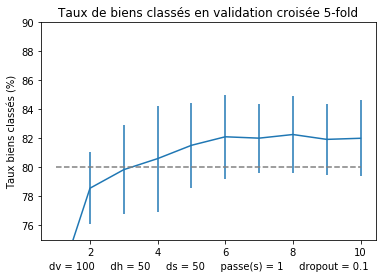

In [59]:
printCrossValidation2(reussites1, 100, 50, 50, 1, 0.1) 

In [52]:
reussites2 = CrossValidation(cross_val_data, dv = 100, dh = 50, ds = 50, hops = 1, dropout = 0.2, runs = [2,5,3]) 
reussites2

Agent's number of parameters : 835214 
Agent's number of parameters : 113014 
0m 11s (- 2m 42s) (100 6%) 2.6304 0.87
0m 25s (- 2m 48s) (200 13%) 2.6230 0.92
0m 38s (- 2m 32s) (300 20%) 2.6061 0.88
0m 49s (- 2m 14s) (400 26%) 2.6010 0.83
1m 1s (- 2m 3s) (500 33%) 2.5923 0.80
1m 14s (- 1m 51s) (600 40%) 2.5876 0.90
1m 27s (- 1m 39s) (700 46%) 2.5647 0.85
1m 39s (- 1m 26s) (800 53%) 2.5462 0.77
1m 50s (- 1m 13s) (900 60%) 2.5421 0.81
2m 1s (- 1m 0s) (1000 66%) 2.5178 0.77
2m 14s (- 0m 49s) (1100 73%) 2.4842 0.71
2m 27s (- 0m 36s) (1200 80%) 2.4590 0.72
2m 40s (- 0m 24s) (1300 86%) 2.4180 0.67
2m 53s (- 0m 12s) (1400 93%) 2.3851 0.65
3m 6s (- 0m 0s) (1500 100%) 2.3024 0.61
epoch 1
0m 16s (- 2m 15s) (100 10%) 1.7263 0.39
0m 30s (- 1m 53s) (200 21%) 1.4400 0.37
0m 47s (- 1m 40s) (300 32%) 1.3879 0.39
1m 4s (- 1m 27s) (400 42%) 0.9993 0.24
1m 22s (- 1m 12s) (500 53%) 1.1880 0.33
1m 37s (- 0m 54s) (600 64%) 1.0822 0.30
1m 51s (- 0m 37s) (700 74%) 1.0457 0.30
2m 6s (- 0m 21s) (800 85%) 1.1470 0

0m 11s (- 2m 41s) (100 6%) 0.1535 0.03
0m 25s (- 2m 47s) (200 13%) 0.2036 0.03
0m 37s (- 2m 31s) (300 20%) 0.2696 0.06
0m 48s (- 2m 14s) (400 26%) 0.2109 0.04
1m 1s (- 2m 2s) (500 33%) 0.3060 0.06
1m 13s (- 1m 50s) (600 40%) 0.1787 0.04
1m 26s (- 1m 39s) (700 46%) 0.1930 0.04
1m 38s (- 1m 26s) (800 53%) 0.1881 0.04
1m 49s (- 1m 13s) (900 60%) 0.2030 0.05
2m 0s (- 1m 0s) (1000 66%) 0.1953 0.03
2m 14s (- 0m 48s) (1100 73%) 0.2203 0.02
2m 26s (- 0m 36s) (1200 80%) 0.1739 0.03
2m 39s (- 0m 24s) (1300 86%) 0.2604 0.06
2m 53s (- 0m 12s) (1400 93%) 0.2244 0.05
3m 5s (- 0m 0s) (1500 100%) 0.3159 0.07
epoch 1
0m 16s (- 2m 14s) (100 10%) 0.1841 0.06
0m 30s (- 1m 52s) (200 21%) 0.1675 0.05
0m 47s (- 1m 40s) (300 32%) 0.3016 0.11
1m 4s (- 1m 27s) (400 42%) 0.2030 0.05
1m 23s (- 1m 12s) (500 53%) 0.2203 0.08
1m 37s (- 0m 54s) (600 64%) 0.1918 0.06
1m 52s (- 0m 37s) (700 74%) 0.2118 0.05
2m 6s (- 0m 21s) (800 85%) 0.2758 0.10
2m 22s (- 0m 5s) (900 96%) 0.2672 0.10
Taux de biens classés en validation

Taux de biens classés en validation au run 6 : 77.73
0m 11s (- 2m 39s) (100 6%) 0.3109 0.07
0m 24s (- 2m 38s) (200 13%) 0.4330 0.15
0m 35s (- 2m 23s) (300 20%) 0.3627 0.10
0m 45s (- 2m 5s) (400 26%) 0.3294 0.04
0m 58s (- 1m 56s) (500 33%) 0.4515 0.12
1m 11s (- 1m 46s) (600 40%) 0.3296 0.05
1m 24s (- 1m 36s) (700 46%) 0.3597 0.12
1m 35s (- 1m 23s) (800 53%) 0.2722 0.06
1m 46s (- 1m 10s) (900 60%) 0.2945 0.05
1m 57s (- 0m 58s) (1000 66%) 0.2622 0.05
2m 10s (- 0m 47s) (1100 73%) 0.3655 0.09
2m 22s (- 0m 35s) (1200 80%) 0.3015 0.06
2m 36s (- 0m 24s) (1300 86%) 0.4628 0.16
2m 49s (- 0m 12s) (1400 93%) 0.2803 0.05
3m 2s (- 0m 0s) (1500 100%) 0.2613 0.05
epoch 1
0m 16s (- 2m 16s) (100 10%) 0.3684 0.11
0m 31s (- 1m 55s) (200 21%) 0.2305 0.07
0m 50s (- 1m 47s) (300 31%) 0.2391 0.05
1m 7s (- 1m 31s) (400 42%) 0.1772 0.05
1m 24s (- 1m 14s) (500 53%) 0.3284 0.10
1m 40s (- 0m 56s) (600 63%) 0.2614 0.07
1m 56s (- 0m 40s) (700 74%) 0.2251 0.07
2m 10s (- 0m 23s) (800 85%) 0.3720 0.15
2m 27s (- 0m 6s) 

2m 26s (- 0m 6s) (900 95%) 0.4649 0.14
Taux de biens classés en validation au run 4 : 77.54
0m 10s (- 2m 29s) (100 6%) 0.6405 0.18
0m 25s (- 2m 45s) (200 13%) 0.6107 0.18
0m 36s (- 2m 25s) (300 20%) 0.5722 0.19
0m 46s (- 2m 7s) (400 26%) 0.5549 0.14
0m 56s (- 1m 53s) (500 33%) 0.5329 0.12
1m 10s (- 1m 45s) (600 40%) 0.6083 0.19
1m 21s (- 1m 33s) (700 46%) 0.5816 0.13
1m 32s (- 1m 20s) (800 53%) 0.4489 0.11
1m 42s (- 1m 8s) (900 60%) 0.4502 0.10
1m 53s (- 0m 56s) (1000 66%) 0.5572 0.11
2m 6s (- 0m 45s) (1100 73%) 0.5013 0.12
2m 17s (- 0m 34s) (1200 80%) 0.4615 0.16
2m 30s (- 0m 23s) (1300 86%) 0.5816 0.15
2m 42s (- 0m 11s) (1400 93%) 0.5001 0.17
2m 55s (- 0m 0s) (1500 100%) 0.4498 0.12
epoch 1
0m 15s (- 2m 10s) (100 10%) 0.4039 0.11
0m 31s (- 1m 55s) (200 21%) 0.3723 0.13
0m 48s (- 1m 43s) (300 31%) 0.3663 0.10
1m 5s (- 1m 28s) (400 42%) 0.2971 0.09
1m 22s (- 1m 13s) (500 53%) 0.3936 0.13
1m 37s (- 0m 55s) (600 63%) 0.3491 0.06
1m 54s (- 0m 39s) (700 74%) 0.3538 0.08
2m 10s (- 0m 23s) (

2m 12s (- 0m 24s) (800 84%) 0.9749 0.27
2m 28s (- 0m 7s) (900 95%) 0.6399 0.18
Taux de biens classés en validation au run 2 : 76.50 %
0m 11s (- 2m 37s) (100 6%) 1.4697 0.48
0m 25s (- 2m 45s) (200 13%) 1.1779 0.33
0m 37s (- 2m 29s) (300 20%) 1.1602 0.32
0m 47s (- 2m 10s) (400 26%) 1.2429 0.38
0m 58s (- 1m 56s) (500 33%) 1.2339 0.33
1m 12s (- 1m 48s) (600 40%) 1.0455 0.28
1m 24s (- 1m 36s) (700 46%) 1.0710 0.29
1m 35s (- 1m 23s) (800 53%) 0.8859 0.26
1m 45s (- 1m 10s) (900 60%) 0.9342 0.28
1m 58s (- 0m 59s) (1000 66%) 0.9695 0.26
2m 10s (- 0m 47s) (1100 73%) 0.8888 0.26
2m 21s (- 0m 35s) (1200 80%) 1.0386 0.31
2m 34s (- 0m 23s) (1300 86%) 0.9705 0.28
2m 47s (- 0m 11s) (1400 93%) 0.9076 0.23
3m 0s (- 0m 0s) (1500 100%) 0.9012 0.20
epoch 1
0m 16s (- 2m 18s) (100 10%) 0.6397 0.20
0m 32s (- 1m 59s) (200 21%) 0.6787 0.18
0m 49s (- 1m 46s) (300 31%) 0.5450 0.11
1m 5s (- 1m 29s) (400 42%) 0.3562 0.10
1m 23s (- 1m 14s) (500 52%) 0.5820 0.14
1m 40s (- 0m 57s) (600 63%) 0.5798 0.20
1m 56s (- 0m 40

2m 27s (- 0m 7s) (900 95%) 0.1673 0.04
Taux de biens classés en validation au run 10 : 82.48
Agent's number of parameters : 835214 
Agent's number of parameters : 113014 
0m 11s (- 2m 35s) (100 6%) 2.6462 0.91
0m 24s (- 2m 37s) (200 13%) 2.6423 0.93
0m 35s (- 2m 23s) (300 20%) 2.6268 0.91
0m 46s (- 2m 9s) (400 26%) 2.6148 0.91
0m 56s (- 1m 53s) (500 33%) 2.6203 0.91
1m 11s (- 1m 46s) (600 40%) 2.6122 0.91
1m 23s (- 1m 35s) (700 46%) 2.5892 0.86
1m 34s (- 1m 22s) (800 53%) 2.5645 0.80
1m 45s (- 1m 10s) (900 60%) 2.5727 0.90
1m 58s (- 0m 59s) (1000 66%) 2.5417 0.75
2m 10s (- 0m 47s) (1100 73%) 2.5221 0.71
2m 21s (- 0m 35s) (1200 80%) 2.4873 0.67
2m 34s (- 0m 23s) (1300 86%) 2.4776 0.69
2m 46s (- 0m 11s) (1400 93%) 2.4104 0.68
3m 0s (- 0m 0s) (1500 100%) 2.3338 0.64
epoch 1
0m 16s (- 2m 22s) (100 10%) 1.8689 0.41
0m 32s (- 2m 0s) (200 21%) 1.4862 0.33
0m 48s (- 1m 45s) (300 31%) 1.3079 0.37
1m 5s (- 1m 30s) (400 42%) 1.0779 0.22
1m 20s (- 1m 12s) (500 52%) 0.9454 0.22
1m 36s (- 0m 56s) (6

2m 7s (- 0m 23s) (800 84%) 0.3303 0.10
2m 22s (- 0m 7s) (900 94%) 0.2248 0.07
Taux de biens classés en validation au run 8 : 86.03
0m 11s (- 2m 37s) (100 6%) 0.2751 0.05
0m 24s (- 2m 38s) (200 13%) 0.3010 0.09
0m 36s (- 2m 24s) (300 20%) 0.2827 0.07
0m 47s (- 2m 9s) (400 26%) 0.2235 0.04
0m 57s (- 1m 54s) (500 33%) 0.2759 0.07
1m 11s (- 1m 47s) (600 40%) 0.2266 0.07
1m 23s (- 1m 35s) (700 46%) 0.2286 0.04
1m 35s (- 1m 23s) (800 53%) 0.2494 0.05
1m 46s (- 1m 11s) (900 60%) 0.3090 0.08
2m 0s (- 1m 0s) (1000 66%) 0.2205 0.01
2m 12s (- 0m 48s) (1100 73%) 0.2230 0.04
2m 25s (- 0m 36s) (1200 80%) 0.2326 0.03
2m 38s (- 0m 24s) (1300 86%) 0.3054 0.09
2m 50s (- 0m 12s) (1400 93%) 0.2500 0.08
3m 4s (- 0m 0s) (1500 100%) 0.1708 0.03
epoch 1
0m 16s (- 2m 22s) (100 10%) 0.2985 0.05
0m 31s (- 1m 59s) (200 21%) 0.3387 0.09
0m 48s (- 1m 45s) (300 31%) 0.2600 0.08
1m 5s (- 1m 30s) (400 42%) 0.1694 0.03
1m 20s (- 1m 12s) (500 52%) 0.2061 0.05
1m 36s (- 0m 56s) (600 63%) 0.2338 0.07
1m 52s (- 0m 40s) (70

[[69.83471074380165,
  76.44628099173553,
  79.75206611570248,
  81.81818181818181,
  81.81818181818181,
  83.88429752066115,
  85.12396694214877,
  84.71074380165288,
  85.53719008264463,
  86.36363636363636],
 [69.32773109243698,
  74.78991596638656,
  75.63025210084034,
  78.99159663865547,
  79.41176470588236,
  77.73109243697479,
  79.41176470588236,
  79.41176470588236,
  79.41176470588236,
  81.9327731092437],
 [70.76271186440678,
  76.69491525423729,
  78.38983050847457,
  77.54237288135593,
  80.08474576271186,
  79.66101694915254,
  79.23728813559322,
  80.50847457627118,
  80.93220338983052,
  80.08474576271186],
 [69.65811965811966,
  76.49572649572649,
  79.05982905982906,
  79.05982905982906,
  79.91452991452992,
  80.34188034188034,
  82.05128205128204,
  82.47863247863248,
  82.47863247863248,
  82.47863247863248],
 [73.7991266375546,
  80.34934497816593,
  82.53275109170306,
  83.84279475982532,
  86.8995633187773,
  86.46288209606988,
  86.8995633187773,
  86.02620087

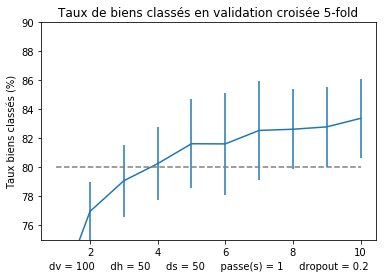

In [58]:
printCrossValidation2(reussites2, 100, 50, 50, 1, 0.2) 

In [50]:
reussites3 = CrossValidation(cross_val_data, dv = 100, dh = 50, ds = 50, hops = 1, dropout = 0.3, runs = [3,3,4])
reussites3

Agent's number of parameters : 835214 
Agent's number of parameters : 113014 
0m 11s (- 2m 42s) (100 6%) 2.6175 0.87
0m 25s (- 2m 45s) (200 13%) 2.6245 0.86
0m 37s (- 2m 30s) (300 20%) 2.6096 0.92
0m 48s (- 2m 13s) (400 26%) 2.6167 0.87
1m 0s (- 2m 1s) (500 33%) 2.5992 0.85
1m 13s (- 1m 50s) (600 40%) 2.5920 0.86
1m 26s (- 1m 38s) (700 46%) 2.5714 0.83
1m 38s (- 1m 25s) (800 53%) 2.5806 0.87
1m 48s (- 1m 12s) (900 60%) 2.5679 0.80
2m 0s (- 1m 0s) (1000 66%) 2.5588 0.77
2m 14s (- 0m 48s) (1100 73%) 2.5332 0.81
2m 26s (- 0m 36s) (1200 80%) 2.5110 0.71
2m 39s (- 0m 24s) (1300 86%) 2.4643 0.62
2m 52s (- 0m 12s) (1400 93%) 2.4753 0.74
3m 5s (- 0m 0s) (1500 100%) 2.3772 0.64
epoch 1
0m 16s (- 2m 17s) (100 10%) 1.9385 0.46
0m 32s (- 2m 1s) (200 21%) 1.6040 0.46
0m 49s (- 1m 44s) (300 32%) 1.5326 0.48
1m 7s (- 1m 30s) (400 42%) 1.1126 0.27
1m 24s (- 1m 14s) (500 53%) 1.3034 0.34
1m 39s (- 0m 55s) (600 64%) 1.2128 0.29
1m 53s (- 0m 38s) (700 74%) 1.1439 0.32
2m 9s (- 0m 22s) (800 85%) 1.2605 0.

0m 11s (- 2m 46s) (100 6%) 0.3689 0.15
0m 26s (- 2m 50s) (200 13%) 0.3426 0.08
0m 38s (- 2m 35s) (300 20%) 0.4240 0.13
0m 50s (- 2m 18s) (400 26%) 0.3515 0.09
1m 3s (- 2m 6s) (500 33%) 0.4871 0.16
1m 16s (- 1m 54s) (600 40%) 0.3492 0.09
1m 30s (- 1m 43s) (700 46%) 0.3568 0.09
1m 42s (- 1m 29s) (800 53%) 0.3695 0.11
1m 54s (- 1m 16s) (900 60%) 0.3091 0.09
2m 6s (- 1m 3s) (1000 66%) 0.2765 0.06
2m 20s (- 0m 51s) (1100 73%) 0.4403 0.13
2m 33s (- 0m 38s) (1200 80%) 0.2768 0.07
2m 46s (- 0m 25s) (1300 86%) 0.4359 0.12
3m 0s (- 0m 12s) (1400 93%) 0.3432 0.08
3m 12s (- 0m 0s) (1500 100%) 0.3078 0.05
epoch 1
0m 16s (- 2m 17s) (100 10%) 0.2908 0.07
0m 31s (- 1m 54s) (200 21%) 0.1657 0.03
0m 47s (- 1m 41s) (300 32%) 0.3859 0.12
1m 5s (- 1m 28s) (400 42%) 0.4095 0.11
1m 23s (- 1m 13s) (500 53%) 0.2823 0.09
1m 38s (- 0m 55s) (600 64%) 0.3098 0.10
1m 52s (- 0m 38s) (700 74%) 0.2239 0.06
2m 7s (- 0m 21s) (800 85%) 0.3267 0.11
2m 22s (- 0m 5s) (900 96%) 0.4918 0.15
Taux de biens classés en validation

Taux de biens classés en validation au run 6 : 80.67
0m 11s (- 2m 39s) (100 6%) 0.5215 0.14
0m 24s (- 2m 37s) (200 13%) 0.6475 0.19
0m 36s (- 2m 24s) (300 20%) 0.5537 0.16
0m 45s (- 2m 5s) (400 26%) 0.5304 0.18
0m 58s (- 1m 56s) (500 33%) 0.5755 0.15
1m 11s (- 1m 46s) (600 40%) 0.5118 0.12
1m 24s (- 1m 36s) (700 46%) 0.4477 0.14
1m 36s (- 1m 24s) (800 53%) 0.4076 0.09
1m 46s (- 1m 11s) (900 60%) 0.4072 0.10
1m 58s (- 0m 59s) (1000 66%) 0.5019 0.11
2m 11s (- 0m 47s) (1100 73%) 0.4840 0.12
2m 23s (- 0m 35s) (1200 80%) 0.4264 0.09
2m 38s (- 0m 24s) (1300 86%) 0.6569 0.18
2m 51s (- 0m 12s) (1400 93%) 0.4179 0.09
3m 4s (- 0m 0s) (1500 100%) 0.4156 0.12
epoch 1
0m 16s (- 2m 16s) (100 10%) 0.4408 0.17
0m 30s (- 1m 54s) (200 21%) 0.3847 0.11
0m 49s (- 1m 46s) (300 31%) 0.3479 0.10
1m 7s (- 1m 31s) (400 42%) 0.3130 0.08
1m 23s (- 1m 13s) (500 53%) 0.4212 0.12
1m 40s (- 0m 56s) (600 63%) 0.3879 0.13
1m 56s (- 0m 40s) (700 74%) 0.3444 0.12
2m 11s (- 0m 23s) (800 85%) 0.5572 0.18
2m 27s (- 0m 6s) 

2m 26s (- 0m 6s) (900 95%) 0.5497 0.19
Taux de biens classés en validation au run 4 : 78.39
0m 10s (- 2m 28s) (100 6%) 0.9129 0.32
0m 25s (- 2m 44s) (200 13%) 0.7653 0.24
0m 36s (- 2m 25s) (300 20%) 0.6909 0.20
0m 46s (- 2m 7s) (400 26%) 0.6332 0.15
0m 56s (- 1m 53s) (500 33%) 0.6882 0.22
1m 9s (- 1m 44s) (600 40%) 0.6517 0.17
1m 21s (- 1m 33s) (700 46%) 0.6816 0.18
1m 31s (- 1m 20s) (800 53%) 0.5475 0.15
1m 42s (- 1m 8s) (900 60%) 0.5467 0.17
1m 53s (- 0m 56s) (1000 66%) 0.6672 0.21
2m 6s (- 0m 45s) (1100 73%) 0.5870 0.20
2m 17s (- 0m 34s) (1200 80%) 0.5710 0.12
2m 30s (- 0m 23s) (1300 86%) 0.7758 0.21
2m 42s (- 0m 11s) (1400 93%) 0.6260 0.18
2m 55s (- 0m 0s) (1500 100%) 0.5275 0.11
epoch 1
0m 15s (- 2m 10s) (100 10%) 0.5478 0.13
0m 31s (- 1m 55s) (200 21%) 0.4722 0.15
0m 48s (- 1m 43s) (300 31%) 0.4887 0.12
1m 4s (- 1m 28s) (400 42%) 0.3104 0.08
1m 22s (- 1m 13s) (500 53%) 0.4773 0.13
1m 37s (- 0m 55s) (600 63%) 0.4267 0.14
1m 54s (- 0m 39s) (700 74%) 0.4414 0.14
2m 10s (- 0m 23s) (8

2m 12s (- 0m 24s) (800 84%) 1.0367 0.30
2m 27s (- 0m 7s) (900 95%) 0.7829 0.23
Taux de biens classés en validation au run 2 : 75.21 %
0m 11s (- 2m 39s) (100 6%) 1.6714 0.54
0m 25s (- 2m 44s) (200 13%) 1.3288 0.42
0m 37s (- 2m 28s) (300 20%) 1.3266 0.45
0m 47s (- 2m 9s) (400 26%) 1.3722 0.39
0m 57s (- 1m 55s) (500 33%) 1.3884 0.35
1m 11s (- 1m 47s) (600 40%) 1.1660 0.36
1m 23s (- 1m 35s) (700 46%) 1.1449 0.34
1m 34s (- 1m 23s) (800 53%) 1.0917 0.30
1m 45s (- 1m 10s) (900 60%) 1.0696 0.31
1m 58s (- 0m 59s) (1000 66%) 1.1128 0.30
2m 10s (- 0m 47s) (1100 73%) 1.0072 0.30
2m 21s (- 0m 35s) (1200 80%) 1.1576 0.39
2m 34s (- 0m 23s) (1300 86%) 1.1218 0.34
2m 47s (- 0m 11s) (1400 93%) 1.0638 0.38
3m 0s (- 0m 0s) (1500 100%) 0.9689 0.29
epoch 1
0m 16s (- 2m 19s) (100 10%) 0.7016 0.24
0m 32s (- 1m 59s) (200 21%) 0.8263 0.20
0m 49s (- 1m 46s) (300 31%) 0.6457 0.22
1m 5s (- 1m 29s) (400 42%) 0.4452 0.14
1m 22s (- 1m 13s) (500 52%) 0.6589 0.20
1m 40s (- 0m 57s) (600 63%) 0.5623 0.14
1m 56s (- 0m 40s

2m 27s (- 0m 7s) (900 95%) 0.2788 0.07
Taux de biens classés en validation au run 10 : 82.05
Agent's number of parameters : 835214 
Agent's number of parameters : 113014 
0m 11s (- 2m 34s) (100 6%) 2.6569 0.95
0m 24s (- 2m 36s) (200 13%) 2.6308 0.88
0m 35s (- 2m 23s) (300 20%) 2.6417 0.92
0m 47s (- 2m 9s) (400 26%) 2.6156 0.87
0m 56s (- 1m 53s) (500 33%) 2.6243 0.94
1m 11s (- 1m 46s) (600 40%) 2.6468 0.94
1m 22s (- 1m 34s) (700 46%) 2.6014 0.86
1m 34s (- 1m 22s) (800 53%) 2.5672 0.89
1m 45s (- 1m 10s) (900 60%) 2.5854 0.86
1m 58s (- 0m 59s) (1000 66%) 2.5699 0.81
2m 9s (- 0m 47s) (1100 73%) 2.5507 0.76
2m 21s (- 0m 35s) (1200 80%) 2.5406 0.79
2m 34s (- 0m 23s) (1300 86%) 2.5238 0.77
2m 47s (- 0m 11s) (1400 93%) 2.4867 0.76
3m 1s (- 0m 0s) (1500 100%) 2.4237 0.68
epoch 1
0m 16s (- 2m 24s) (100 10%) 2.0494 0.60
0m 32s (- 2m 1s) (200 21%) 1.6757 0.44
0m 48s (- 1m 46s) (300 31%) 1.5324 0.45
1m 6s (- 1m 31s) (400 42%) 1.2583 0.28
1m 21s (- 1m 13s) (500 52%) 1.1444 0.26
1m 37s (- 0m 56s) (60

2m 8s (- 0m 24s) (800 84%) 0.3726 0.10
2m 23s (- 0m 7s) (900 94%) 0.2936 0.09
Taux de biens classés en validation au run 8 : 82.97
0m 11s (- 2m 35s) (100 6%) 0.4284 0.11
0m 24s (- 2m 38s) (200 13%) 0.4024 0.11
0m 36s (- 2m 25s) (300 20%) 0.4385 0.11
0m 47s (- 2m 9s) (400 26%) 0.3142 0.06
0m 56s (- 1m 53s) (500 33%) 0.4439 0.15
1m 11s (- 1m 47s) (600 40%) 0.3356 0.07
1m 23s (- 1m 35s) (700 46%) 0.3109 0.09
1m 34s (- 1m 22s) (800 53%) 0.3164 0.10
1m 45s (- 1m 10s) (900 60%) 0.4081 0.13
1m 58s (- 0m 59s) (1000 66%) 0.3063 0.06
2m 10s (- 0m 47s) (1100 73%) 0.3327 0.11
2m 21s (- 0m 35s) (1200 80%) 0.3459 0.09
2m 34s (- 0m 23s) (1300 86%) 0.4962 0.15
2m 47s (- 0m 11s) (1400 93%) 0.3466 0.08
3m 1s (- 0m 0s) (1500 100%) 0.2550 0.06
epoch 1
0m 16s (- 2m 23s) (100 10%) 0.3824 0.11
0m 32s (- 2m 0s) (200 21%) 0.3830 0.13
0m 48s (- 1m 45s) (300 31%) 0.3136 0.11
1m 5s (- 1m 30s) (400 42%) 0.2787 0.08
1m 20s (- 1m 12s) (500 52%) 0.3023 0.07
1m 36s (- 0m 56s) (600 63%) 0.3392 0.10
1m 53s (- 0m 40s) (7

[[69.83471074380165,
  74.79338842975207,
  81.40495867768595,
  82.23140495867769,
  85.12396694214877,
  85.12396694214877,
  85.12396694214877,
  85.53719008264463,
  85.53719008264463,
  85.12396694214877],
 [69.32773109243698,
  72.26890756302521,
  76.05042016806722,
  77.31092436974791,
  78.99159663865547,
  80.67226890756302,
  81.09243697478992,
  82.35294117647058,
  82.35294117647058,
  81.5126050420168],
 [70.76271186440678,
  75.84745762711864,
  77.54237288135593,
  78.38983050847457,
  80.50847457627118,
  80.08474576271186,
  81.35593220338984,
  81.35593220338984,
  81.35593220338984,
  80.93220338983052],
 [70.08547008547008,
  75.21367521367522,
  79.91452991452992,
  79.05982905982906,
  79.91452991452992,
  80.76923076923077,
  81.19658119658119,
  80.76923076923077,
  81.19658119658119,
  82.05128205128204],
 [72.92576419213974,
  78.60262008733625,
  82.53275109170306,
  82.09606986899564,
  82.96943231441047,
  83.4061135371179,
  82.96943231441047,
  82.969432

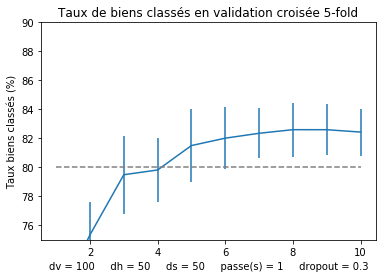

In [57]:
printCrossValidation2(reussites3, 100, 50, 50, 1, 0.3) 

In [51]:
reussites4 = CrossValidation(cross_val_data, dv = 100, dh = 50, ds = 50, hops = 1, dropout = 0.4, runs = [3,5,3]) 
reussites4

Agent's number of parameters : 835214 
Agent's number of parameters : 113014 
0m 11s (- 2m 39s) (100 6%) 2.6299 0.87
0m 25s (- 2m 45s) (200 13%) 2.6113 0.91
0m 37s (- 2m 31s) (300 20%) 2.6370 0.94
0m 48s (- 2m 13s) (400 26%) 2.5966 0.86
1m 1s (- 2m 2s) (500 33%) 2.6160 0.88
1m 14s (- 1m 51s) (600 40%) 2.5972 0.86
1m 26s (- 1m 39s) (700 46%) 2.5859 0.91
1m 38s (- 1m 26s) (800 53%) 2.6071 0.90
1m 49s (- 1m 12s) (900 60%) 2.5711 0.82
2m 0s (- 1m 0s) (1000 66%) 2.5502 0.78
2m 14s (- 0m 48s) (1100 73%) 2.5603 0.79
2m 26s (- 0m 36s) (1200 80%) 2.5319 0.84
2m 39s (- 0m 24s) (1300 86%) 2.5352 0.75
2m 53s (- 0m 12s) (1400 93%) 2.5052 0.73
3m 5s (- 0m 0s) (1500 100%) 2.4710 0.74
epoch 1
0m 16s (- 2m 14s) (100 10%) 2.0852 0.43
0m 30s (- 1m 51s) (200 21%) 1.7746 0.48
0m 46s (- 1m 38s) (300 32%) 1.7150 0.52
1m 4s (- 1m 26s) (400 42%) 1.2807 0.37
1m 22s (- 1m 11s) (500 53%) 1.4266 0.41
1m 36s (- 0m 54s) (600 64%) 1.3389 0.35
1m 51s (- 0m 37s) (700 74%) 1.3121 0.34
2m 5s (- 0m 21s) (800 85%) 1.3757 0

0m 11s (- 2m 43s) (100 6%) 0.5244 0.19
0m 25s (- 2m 48s) (200 13%) 0.5886 0.19
0m 38s (- 2m 33s) (300 20%) 0.6216 0.24
0m 48s (- 2m 14s) (400 26%) 0.4110 0.11
1m 1s (- 2m 3s) (500 33%) 0.6889 0.18
1m 14s (- 1m 52s) (600 40%) 0.5930 0.19
1m 27s (- 1m 39s) (700 46%) 0.5517 0.20
1m 39s (- 1m 26s) (800 53%) 0.5802 0.18
1m 49s (- 1m 13s) (900 60%) 0.4176 0.14
2m 1s (- 1m 0s) (1000 66%) 0.4500 0.10
2m 14s (- 0m 48s) (1100 73%) 0.5511 0.19
2m 26s (- 0m 36s) (1200 80%) 0.4385 0.15
2m 39s (- 0m 24s) (1300 86%) 0.6240 0.18
2m 53s (- 0m 12s) (1400 93%) 0.5839 0.19
3m 6s (- 0m 0s) (1500 100%) 0.3952 0.10
epoch 1
0m 15s (- 2m 13s) (100 10%) 0.3856 0.15
0m 30s (- 1m 51s) (200 21%) 0.2912 0.10
0m 46s (- 1m 39s) (300 32%) 0.6099 0.18
1m 4s (- 1m 26s) (400 42%) 0.4352 0.11
1m 22s (- 1m 12s) (500 53%) 0.3768 0.10
1m 37s (- 0m 54s) (600 64%) 0.3503 0.07
1m 51s (- 0m 37s) (700 74%) 0.3060 0.10
2m 5s (- 0m 21s) (800 85%) 0.4375 0.15
2m 21s (- 0m 5s) (900 96%) 0.4545 0.17
Taux de biens classés en validation

Taux de biens classés en validation au run 5 : 79.83
0m 11s (- 2m 40s) (100 6%) 0.8674 0.28
0m 24s (- 2m 38s) (200 13%) 0.9354 0.33
0m 35s (- 2m 23s) (300 20%) 0.6579 0.21
0m 45s (- 2m 5s) (400 26%) 0.8014 0.29
0m 58s (- 1m 56s) (500 33%) 0.7622 0.22
1m 11s (- 1m 46s) (600 40%) 0.7213 0.22
1m 24s (- 1m 36s) (700 46%) 0.7821 0.25
1m 35s (- 1m 23s) (800 53%) 0.5774 0.19
1m 46s (- 1m 10s) (900 60%) 0.6308 0.22
1m 58s (- 0m 59s) (1000 66%) 0.7830 0.21
2m 10s (- 0m 47s) (1100 73%) 0.7654 0.23
2m 22s (- 0m 35s) (1200 80%) 0.6742 0.21
2m 36s (- 0m 24s) (1300 86%) 0.8455 0.27
2m 50s (- 0m 12s) (1400 93%) 0.6737 0.21
3m 2s (- 0m 0s) (1500 100%) 0.7324 0.19
epoch 1
0m 16s (- 2m 17s) (100 10%) 0.6151 0.20
0m 30s (- 1m 54s) (200 21%) 0.5570 0.19
0m 49s (- 1m 45s) (300 31%) 0.5285 0.15
1m 7s (- 1m 30s) (400 42%) 0.3990 0.09
1m 23s (- 1m 13s) (500 53%) 0.5459 0.20
1m 40s (- 0m 57s) (600 63%) 0.5371 0.16
1m 56s (- 0m 40s) (700 74%) 0.4598 0.16
2m 11s (- 0m 23s) (800 85%) 0.6673 0.24
2m 27s (- 0m 6s) 

2m 25s (- 0m 6s) (900 95%) 0.9687 0.33
Taux de biens classés en validation au run 2 : 74.15 %
0m 10s (- 2m 27s) (100 6%) 1.9676 0.68
0m 25s (- 2m 44s) (200 13%) 1.6038 0.55
0m 36s (- 2m 24s) (300 20%) 1.5732 0.52
0m 46s (- 2m 7s) (400 26%) 1.6970 0.60
0m 56s (- 1m 53s) (500 33%) 1.6792 0.46
1m 9s (- 1m 44s) (600 40%) 1.5182 0.45
1m 21s (- 1m 32s) (700 46%) 1.4982 0.42
1m 31s (- 1m 20s) (800 53%) 1.3297 0.37
1m 42s (- 1m 8s) (900 60%) 1.2599 0.38
1m 53s (- 0m 56s) (1000 66%) 1.4128 0.48
2m 5s (- 0m 45s) (1100 73%) 1.2599 0.36
2m 16s (- 0m 34s) (1200 80%) 1.3935 0.45
2m 29s (- 0m 23s) (1300 86%) 1.3314 0.38
2m 42s (- 0m 11s) (1400 93%) 1.3823 0.43
2m 55s (- 0m 0s) (1500 100%) 1.2348 0.38
epoch 1
0m 15s (- 2m 8s) (100 10%) 0.8893 0.29
0m 31s (- 1m 55s) (200 21%) 0.7539 0.27
0m 48s (- 1m 43s) (300 31%) 0.7065 0.20
1m 4s (- 1m 28s) (400 42%) 0.6035 0.23
1m 22s (- 1m 13s) (500 53%) 0.7113 0.23
1m 37s (- 0m 55s) (600 63%) 0.6690 0.21
1m 54s (- 0m 39s) (700 74%) 0.7572 0.28
2m 10s (- 0m 23s) (

Taux de biens classés en validation au run 10 : 80.08
0m 10s (- 2m 30s) (100 6%) 0.5821 0.18
0m 25s (- 2m 44s) (200 13%) 0.3926 0.12
0m 36s (- 2m 25s) (300 20%) 0.3522 0.08
0m 46s (- 2m 7s) (400 26%) 0.3716 0.09
0m 57s (- 1m 54s) (500 33%) 0.4074 0.11
1m 9s (- 1m 44s) (600 40%) 0.4322 0.14
1m 21s (- 1m 33s) (700 46%) 0.4881 0.13
1m 31s (- 1m 20s) (800 53%) 0.3488 0.10
1m 42s (- 1m 8s) (900 60%) 0.3150 0.07
1m 53s (- 0m 56s) (1000 66%) 0.3717 0.11
2m 6s (- 0m 45s) (1100 73%) 0.2629 0.03
2m 17s (- 0m 34s) (1200 80%) 0.3755 0.11
2m 30s (- 0m 23s) (1300 86%) 0.3705 0.09
2m 43s (- 0m 11s) (1400 93%) 0.4710 0.17
2m 55s (- 0m 0s) (1500 100%) 0.3428 0.10
epoch 1
0m 15s (- 2m 10s) (100 10%) 0.4746 0.13
0m 31s (- 1m 55s) (200 21%) 0.3656 0.13
0m 48s (- 1m 44s) (300 31%) 0.2584 0.05
1m 5s (- 1m 28s) (400 42%) 0.2595 0.07
1m 22s (- 1m 13s) (500 53%) 0.3094 0.10
1m 37s (- 0m 55s) (600 63%) 0.3288 0.11
1m 54s (- 0m 39s) (700 74%) 0.2764 0.08
2m 10s (- 0m 23s) (800 84%) 0.3842 0.16
2m 25s (- 0m 6s) (

2m 28s (- 0m 7s) (900 95%) 0.4872 0.15
Taux de biens classés en validation au run 7 : 81.62
0m 11s (- 2m 36s) (100 6%) 0.5999 0.20
0m 25s (- 2m 46s) (200 13%) 0.5572 0.17
0m 37s (- 2m 31s) (300 20%) 0.5932 0.20
0m 47s (- 2m 11s) (400 26%) 0.6015 0.23
0m 58s (- 1m 57s) (500 33%) 0.6074 0.20
1m 12s (- 1m 48s) (600 40%) 0.5980 0.19
1m 24s (- 1m 36s) (700 46%) 0.6237 0.21
1m 35s (- 1m 23s) (800 53%) 0.4736 0.14
1m 46s (- 1m 11s) (900 60%) 0.5844 0.20
1m 59s (- 0m 59s) (1000 66%) 0.5824 0.15
2m 11s (- 0m 47s) (1100 73%) 0.4600 0.19
2m 23s (- 0m 35s) (1200 80%) 0.6539 0.22
2m 36s (- 0m 24s) (1300 86%) 0.5278 0.17
2m 49s (- 0m 12s) (1400 93%) 0.5629 0.23
3m 2s (- 0m 0s) (1500 100%) 0.5172 0.16
epoch 1
0m 16s (- 2m 21s) (100 10%) 0.4183 0.11
0m 32s (- 1m 59s) (200 21%) 0.6137 0.18
0m 49s (- 1m 46s) (300 31%) 0.3869 0.12
1m 5s (- 1m 29s) (400 42%) 0.3226 0.12
1m 23s (- 1m 13s) (500 52%) 0.4564 0.15
1m 40s (- 0m 57s) (600 63%) 0.3256 0.09
1m 56s (- 0m 40s) (700 74%) 0.4849 0.17
2m 11s (- 0m 23s)

2m 8s (- 0m 24s) (800 84%) 0.8526 0.30
2m 23s (- 0m 7s) (900 94%) 0.5130 0.19
Taux de biens classés en validation au run 4 : 81.66
0m 11s (- 2m 35s) (100 6%) 1.1534 0.39
0m 24s (- 2m 36s) (200 13%) 1.0207 0.34
0m 35s (- 2m 23s) (300 20%) 1.1306 0.31
0m 46s (- 2m 8s) (400 26%) 0.9681 0.30
0m 56s (- 1m 53s) (500 33%) 1.0584 0.35
1m 11s (- 1m 47s) (600 40%) 0.9221 0.28
1m 23s (- 1m 35s) (700 46%) 1.0142 0.34
1m 34s (- 1m 22s) (800 53%) 0.9624 0.25
1m 45s (- 1m 10s) (900 60%) 1.1410 0.31
1m 58s (- 0m 59s) (1000 66%) 0.8272 0.26
2m 10s (- 0m 47s) (1100 73%) 0.9300 0.33
2m 22s (- 0m 35s) (1200 80%) 0.9347 0.26
2m 35s (- 0m 23s) (1300 86%) 1.0750 0.37
2m 47s (- 0m 11s) (1400 93%) 0.9053 0.32
3m 1s (- 0m 0s) (1500 100%) 0.7877 0.19
epoch 1
0m 16s (- 2m 23s) (100 10%) 0.8154 0.22
0m 32s (- 2m 0s) (200 21%) 0.6820 0.19
0m 49s (- 1m 46s) (300 31%) 0.6551 0.24
1m 6s (- 1m 30s) (400 42%) 0.5103 0.12
1m 21s (- 1m 13s) (500 52%) 0.5207 0.18
1m 37s (- 0m 56s) (600 63%) 0.6271 0.23
1m 53s (- 0m 40s) (7

[[70.24793388429752,
  73.96694214876032,
  80.99173553719008,
  81.40495867768595,
  82.64462809917356,
  82.23140495867769,
  84.71074380165288,
  84.29752066115702,
  84.71074380165288,
  85.53719008264463,
  86.36363636363636],
 [68.90756302521008,
  70.58823529411764,
  77.31092436974791,
  77.31092436974791,
  79.83193277310924,
  80.25210084033614,
  80.67226890756302,
  81.9327731092437,
  82.77310924369748,
  82.77310924369748,
  82.77310924369748],
 [71.1864406779661,
  74.15254237288136,
  76.27118644067797,
  77.96610169491525,
  77.96610169491525,
  80.50847457627118,
  80.08474576271186,
  80.93220338983052,
  80.08474576271186,
  80.08474576271186,
  79.23728813559322],
 [70.08547008547008,
  73.50427350427351,
  79.91452991452992,
  80.34188034188034,
  80.76923076923077,
  81.62393162393163,
  81.62393162393163,
  82.05128205128204,
  83.33333333333334,
  82.05128205128204,
  81.62393162393163],
 [72.48908296943232,
  75.9825327510917,
  79.91266375545851,
  81.6593886

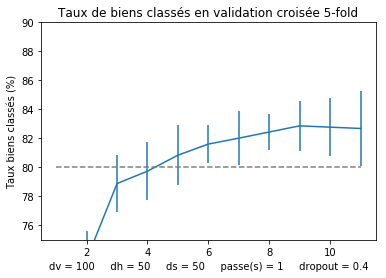

In [56]:
printCrossValidation2(reussites4, 100, 50, 50, 1, 0.4) 

**d_v = 100** | **d_h = 50** | **d_s = 50** | Hops = 3 :

In [62]:
reussites32 = CrossValidation(cross_val_data, dv = 100, dh = 50, ds = 50, hops = 3, dropout = 0.2, runs = [2,3,7])
reussites32

Agent's number of parameters : 855214 
Agent's number of parameters : 133014 
0m 16s (- 3m 46s) (100 6%) 2.6097 0.86
0m 35s (- 3m 49s) (200 13%) 2.5127 0.83
0m 52s (- 3m 28s) (300 20%) 2.4371 0.79
1m 6s (- 3m 4s) (400 26%) 2.2355 0.65
1m 24s (- 2m 48s) (500 33%) 2.2895 0.68
1m 41s (- 2m 32s) (600 40%) 2.0149 0.58
1m 58s (- 2m 15s) (700 46%) 1.9004 0.56
2m 14s (- 1m 57s) (800 53%) 1.7670 0.49
2m 29s (- 1m 39s) (900 60%) 1.5484 0.39
2m 44s (- 1m 22s) (1000 66%) 1.4889 0.38
3m 2s (- 1m 6s) (1100 73%) 1.4434 0.41
3m 19s (- 0m 49s) (1200 80%) 1.2879 0.38
3m 36s (- 0m 33s) (1300 86%) 1.3672 0.39
3m 55s (- 0m 16s) (1400 93%) 1.1296 0.34
4m 12s (- 0m 0s) (1500 100%) 1.0496 0.29
epoch 1
0m 20s (- 2m 53s) (100 10%) 0.5194 0.13
0m 39s (- 2m 26s) (200 21%) 0.6911 0.25
1m 1s (- 2m 9s) (300 32%) 0.8606 0.34
1m 24s (- 1m 52s) (400 42%) 0.5563 0.16
1m 47s (- 1m 33s) (500 53%) 0.7436 0.22
2m 6s (- 1m 10s) (600 64%) 0.6985 0.22
2m 25s (- 0m 49s) (700 74%) 0.7001 0.25
2m 45s (- 0m 28s) (800 85%) 0.8447 0

0m 16s (- 3m 44s) (100 6%) 0.0735 0.02
0m 35s (- 3m 48s) (200 13%) 0.0329 0.00
0m 52s (- 3m 29s) (300 20%) 0.0548 0.01
1m 7s (- 3m 5s) (400 26%) 0.0431 0.01
1m 25s (- 2m 50s) (500 33%) 0.0507 0.01
1m 42s (- 2m 33s) (600 40%) 0.0407 0.00
2m 0s (- 2m 17s) (700 46%) 0.0607 0.01
2m 16s (- 1m 59s) (800 53%) 0.0336 0.00
2m 31s (- 1m 40s) (900 60%) 0.0234 0.00
2m 46s (- 1m 23s) (1000 66%) 0.0266 0.01
3m 4s (- 1m 7s) (1100 73%) 0.0382 0.00
3m 21s (- 0m 50s) (1200 80%) 0.0286 0.00
3m 38s (- 0m 33s) (1300 86%) 0.0653 0.02
3m 57s (- 0m 16s) (1400 93%) 0.0392 0.00
4m 14s (- 0m 0s) (1500 100%) 0.0967 0.02
epoch 1
0m 20s (- 2m 53s) (100 10%) 0.0791 0.04
0m 39s (- 2m 26s) (200 21%) 0.0383 0.01
1m 1s (- 2m 10s) (300 32%) 0.1132 0.04
1m 24s (- 1m 53s) (400 42%) 0.0822 0.02
1m 47s (- 1m 34s) (500 53%) 0.0695 0.02
2m 6s (- 1m 11s) (600 64%) 0.0480 0.01
2m 26s (- 0m 49s) (700 74%) 0.0329 0.00
2m 45s (- 0m 28s) (800 85%) 0.1040 0.03
3m 5s (- 0m 7s) (900 96%) 0.0771 0.02
Taux de biens classés en validation 

0m 15s (- 3m 38s) (100 6%) 0.1253 0.03
0m 33s (- 3m 38s) (200 13%) 0.1599 0.04
0m 49s (- 3m 18s) (300 20%) 0.1312 0.02
1m 3s (- 2m 55s) (400 26%) 0.1345 0.04
1m 20s (- 2m 41s) (500 33%) 0.1204 0.03
1m 38s (- 2m 27s) (600 40%) 0.0869 0.02
1m 55s (- 2m 12s) (700 46%) 0.1080 0.03
2m 11s (- 1m 55s) (800 53%) 0.0735 0.02
2m 26s (- 1m 37s) (900 60%) 0.0811 0.02
2m 42s (- 1m 21s) (1000 66%) 0.0706 0.03
2m 59s (- 1m 5s) (1100 73%) 0.0938 0.03
3m 16s (- 0m 49s) (1200 80%) 0.0824 0.01
3m 34s (- 0m 33s) (1300 86%) 0.1549 0.05
3m 53s (- 0m 16s) (1400 93%) 0.0640 0.00
4m 10s (- 0m 0s) (1500 100%) 0.0636 0.01
epoch 1
0m 20s (- 2m 56s) (100 10%) 0.2253 0.07
0m 40s (- 2m 29s) (200 21%) 0.1128 0.04
1m 4s (- 2m 17s) (300 31%) 0.1129 0.04
1m 26s (- 1m 57s) (400 42%) 0.0699 0.02
1m 48s (- 1m 35s) (500 53%) 0.2358 0.12
2m 9s (- 1m 13s) (600 63%) 0.1177 0.04
2m 31s (- 0m 52s) (700 74%) 0.1513 0.03
2m 50s (- 0m 30s) (800 85%) 0.2368 0.10
3m 11s (- 0m 8s) (900 95%) 0.1581 0.04
Taux de biens classés en validat

0m 14s (- 3m 29s) (100 6%) 2.6433 0.92
0m 34s (- 3m 43s) (200 13%) 2.5507 0.84
0m 49s (- 3m 16s) (300 20%) 2.4423 0.75
1m 3s (- 2m 53s) (400 26%) 2.3765 0.74
1m 17s (- 2m 35s) (500 33%) 2.3340 0.70
1m 35s (- 2m 23s) (600 40%) 2.1002 0.52
1m 51s (- 2m 7s) (700 46%) 1.9018 0.57
2m 5s (- 1m 49s) (800 53%) 1.6538 0.40
2m 20s (- 1m 33s) (900 60%) 1.4710 0.41
2m 35s (- 1m 17s) (1000 66%) 1.5417 0.48
2m 52s (- 1m 2s) (1100 73%) 1.2499 0.33
3m 7s (- 0m 46s) (1200 80%) 1.2209 0.36
3m 24s (- 0m 31s) (1300 86%) 1.2280 0.39
3m 41s (- 0m 15s) (1400 93%) 1.2079 0.29
3m 58s (- 0m 0s) (1500 100%) 1.0043 0.28
epoch 1
0m 20s (- 2m 49s) (100 10%) 0.7300 0.23
0m 40s (- 2m 29s) (200 21%) 0.6774 0.20
1m 2s (- 2m 13s) (300 31%) 0.6106 0.12
1m 24s (- 1m 54s) (400 42%) 0.4513 0.14
1m 46s (- 1m 34s) (500 53%) 0.6522 0.25
2m 6s (- 1m 12s) (600 63%) 0.6851 0.26
2m 29s (- 0m 51s) (700 74%) 0.6402 0.19
2m 50s (- 0m 30s) (800 84%) 0.9055 0.25
3m 10s (- 0m 9s) (900 95%) 0.6652 0.22
Taux de biens classés en validation

0m 49s (- 3m 19s) (300 20%) 0.0341 0.00
1m 4s (- 2m 56s) (400 26%) 0.0326 0.00
1m 18s (- 2m 37s) (500 33%) 0.0356 0.00
1m 36s (- 2m 24s) (600 40%) 0.0484 0.00
1m 52s (- 2m 8s) (700 46%) 0.0498 0.01
2m 6s (- 1m 51s) (800 53%) 0.0309 0.00
2m 21s (- 1m 34s) (900 60%) 0.0461 0.01
2m 37s (- 1m 18s) (1000 66%) 0.0332 0.00
2m 53s (- 1m 3s) (1100 73%) 0.0469 0.02
3m 8s (- 0m 47s) (1200 80%) 0.0411 0.00
3m 25s (- 0m 31s) (1300 86%) 0.0280 0.00
3m 42s (- 0m 15s) (1400 93%) 0.0312 0.00
3m 59s (- 0m 0s) (1500 100%) 0.0320 0.01
epoch 1
0m 20s (- 2m 50s) (100 10%) 0.1462 0.02
0m 41s (- 2m 32s) (200 21%) 0.0346 0.00
1m 3s (- 2m 16s) (300 31%) 0.0345 0.01
1m 25s (- 1m 55s) (400 42%) 0.0629 0.03
1m 48s (- 1m 35s) (500 53%) 0.0535 0.01
2m 8s (- 1m 13s) (600 63%) 0.0486 0.00
2m 32s (- 0m 52s) (700 74%) 0.0703 0.02
2m 54s (- 0m 31s) (800 84%) 0.0498 0.02
3m 14s (- 0m 9s) (900 95%) 0.0438 0.00
Taux de biens classés en validation au run 9 : 80.51
0m 15s (- 3m 33s) (100 6%) 0.0328 0.00
0m 34s (- 3m 45s) (200

0m 44s (- 4m 51s) (200 13%) 0.1158 0.02
1m 6s (- 4m 26s) (300 20%) 0.1245 0.02
1m 24s (- 3m 53s) (400 26%) 0.0844 0.01
1m 44s (- 3m 29s) (500 33%) 0.0807 0.01
2m 11s (- 3m 16s) (600 40%) 0.0529 0.00
2m 32s (- 2m 54s) (700 46%) 0.0746 0.01
2m 52s (- 2m 30s) (800 53%) 0.0737 0.03
3m 11s (- 2m 7s) (900 60%) 0.0564 0.00
3m 34s (- 1m 47s) (1000 66%) 0.0779 0.01
3m 56s (- 1m 25s) (1100 73%) 0.0593 0.01
4m 17s (- 1m 4s) (1200 80%) 0.1380 0.04
4m 39s (- 0m 42s) (1300 86%) 0.1212 0.03
5m 1s (- 0m 21s) (1400 93%) 0.0750 0.01
5m 25s (- 0m 0s) (1500 100%) 0.0931 0.02
epoch 1
0m 28s (- 3m 59s) (100 10%) 0.0838 0.02
0m 55s (- 3m 27s) (200 21%) 0.1863 0.03
1m 25s (- 3m 4s) (300 31%) 0.1257 0.03
1m 53s (- 2m 34s) (400 42%) 0.0784 0.02
2m 24s (- 2m 8s) (500 52%) 0.1625 0.06
2m 54s (- 1m 40s) (600 63%) 0.1174 0.03
3m 25s (- 1m 11s) (700 74%) 0.1720 0.04
3m 54s (- 0m 42s) (800 84%) 0.1165 0.04
4m 20s (- 0m 13s) (900 95%) 0.1497 0.04
Taux de biens classés en validation au run 5 : 82.05
0m 20s (- 4m 44s) (

0m 52s (- 5m 42s) (200 13%) 2.5258 0.83
1m 17s (- 5m 11s) (300 20%) 2.4340 0.80
1m 41s (- 4m 40s) (400 26%) 2.2838 0.72
2m 3s (- 4m 7s) (500 33%) 2.2455 0.66
2m 35s (- 3m 53s) (600 40%) 1.9809 0.51
3m 0s (- 3m 26s) (700 46%) 1.7966 0.48
3m 25s (- 2m 59s) (800 53%) 1.6354 0.44
3m 47s (- 2m 31s) (900 60%) 1.6581 0.47
4m 7s (- 2m 3s) (1000 66%) 1.4116 0.35
4m 27s (- 1m 37s) (1100 73%) 1.3227 0.31
4m 46s (- 1m 11s) (1200 80%) 1.3546 0.39
5m 7s (- 0m 47s) (1300 86%) 1.4109 0.39
5m 27s (- 0m 23s) (1400 93%) 1.1194 0.33
5m 55s (- 0m 0s) (1500 100%) 0.9446 0.28
epoch 1
0m 35s (- 5m 2s) (100 10%) 0.9157 0.26
1m 7s (- 4m 14s) (200 21%) 0.5949 0.20
1m 42s (- 3m 43s) (300 31%) 0.7386 0.22
2m 18s (- 3m 10s) (400 42%) 0.5534 0.15
2m 50s (- 2m 33s) (500 52%) 0.5381 0.18
3m 24s (- 1m 59s) (600 63%) 0.7918 0.27
3m 57s (- 1m 24s) (700 73%) 0.7009 0.25
4m 29s (- 0m 50s) (800 84%) 0.7972 0.28
5m 0s (- 0m 16s) (900 94%) 0.5753 0.20
Taux de biens classés en validation au run 1 : 82.97 %
0m 25s (- 6m 2s) (10

1m 22s (- 3m 48s) (400 26%) 0.0474 0.00
1m 40s (- 3m 21s) (500 33%) 0.0265 0.00
2m 5s (- 3m 8s) (600 40%) 0.0471 0.00
2m 26s (- 2m 47s) (700 46%) 0.0419 0.00
2m 46s (- 2m 25s) (800 53%) 0.0608 0.01
3m 5s (- 2m 3s) (900 60%) 0.0910 0.01
3m 28s (- 1m 44s) (1000 66%) 0.0624 0.02
3m 49s (- 1m 23s) (1100 73%) 0.0377 0.01
4m 9s (- 1m 2s) (1200 80%) 0.0665 0.03
4m 32s (- 0m 41s) (1300 86%) 0.0707 0.00
4m 53s (- 0m 20s) (1400 93%) 0.0588 0.02
5m 17s (- 0m 0s) (1500 100%) 0.0910 0.04
epoch 1
0m 28s (- 4m 4s) (100 10%) 0.0567 0.02
0m 55s (- 3m 27s) (200 21%) 0.0621 0.01
1m 24s (- 3m 2s) (300 31%) 0.0456 0.01
1m 53s (- 2m 36s) (400 42%) 0.0940 0.02
2m 19s (- 2m 5s) (500 52%) 0.1041 0.03
2m 47s (- 1m 37s) (600 63%) 0.0764 0.02
3m 14s (- 1m 9s) (700 73%) 0.1203 0.04
3m 40s (- 0m 41s) (800 84%) 0.0881 0.01
4m 6s (- 0m 13s) (900 94%) 0.0292 0.00
Taux de biens classés en validation au run 9 : 83.84
0m 19s (- 4m 38s) (100 6%) 0.0392 0.00
0m 42s (- 4m 36s) (200 13%) 0.0777 0.02
1m 3s (- 4m 12s) (300 20%

[[79.33884297520662,
  82.23140495867769,
  83.05785123966942,
  83.88429752066115,
  85.9504132231405,
  84.29752066115702,
  84.71074380165288,
  84.71074380165288,
  84.29752066115702,
  85.53719008264463,
  85.12396694214877,
  85.53719008264463],
 [74.36974789915966,
  77.73109243697479,
  80.25210084033614,
  79.41176470588236,
  79.41176470588236,
  78.99159663865547,
  80.67226890756302,
  79.83193277310924,
  79.41176470588236,
  79.83193277310924,
  80.67226890756302,
  80.25210084033614],
 [78.8135593220339,
  77.96610169491525,
  79.23728813559322,
  78.8135593220339,
  80.93220338983052,
  78.38983050847457,
  79.23728813559322,
  77.96610169491525,
  80.50847457627118,
  78.8135593220339,
  78.38983050847457,
  78.8135593220339],
 [78.2051282051282,
  80.34188034188034,
  81.19658119658119,
  82.05128205128204,
  82.05128205128204,
  81.62393162393163,
  81.19658119658119,
  80.34188034188034,
  80.34188034188034,
  81.19658119658119,
  79.48717948717949,
  80.76923076923

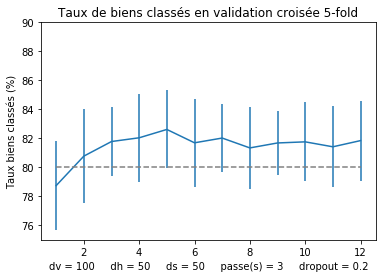

In [12]:
printCrossValidation2(reussites32, 100, 50, 50, 3, 0.2) 

In [67]:
reussites33 = CrossValidation(cross_val_data, dv = 75, dh = 50, ds = 50, hops = 3, dropout = 0.3, runs = [1,1,5,7])
reussites33

Agent's number of parameters : 384789 
Agent's number of parameters : 125514 
0m 19s (- 4m 37s) (100 6%) 2.6308 0.86
0m 42s (- 4m 33s) (200 13%) 2.5852 0.85
1m 2s (- 4m 8s) (300 20%) 2.5142 0.82
1m 19s (- 3m 38s) (400 26%) 2.4325 0.77
1m 40s (- 3m 20s) (500 33%) 2.3957 0.73
2m 0s (- 3m 0s) (600 40%) 2.2538 0.61
2m 21s (- 2m 41s) (700 46%) 2.1450 0.64
2m 40s (- 2m 20s) (800 53%) 2.0082 0.62
2m 58s (- 1m 58s) (900 60%) 1.8683 0.50
3m 16s (- 1m 38s) (1000 66%) 1.7257 0.53
3m 38s (- 1m 19s) (1100 73%) 1.7547 0.52
3m 58s (- 0m 59s) (1200 80%) 1.5946 0.41
4m 19s (- 0m 39s) (1300 86%) 1.5418 0.51
4m 42s (- 0m 20s) (1400 93%) 1.4679 0.46
5m 1s (- 0m 0s) (1500 100%) 1.4066 0.38
epoch 1
0m 24s (- 3m 21s) (100 10%) 0.6486 0.17
0m 45s (- 2m 48s) (200 21%) 0.8255 0.29
1m 10s (- 2m 30s) (300 32%) 0.8703 0.29
1m 37s (- 2m 10s) (400 42%) 0.7337 0.21
2m 4s (- 1m 49s) (500 53%) 0.8200 0.29
2m 26s (- 1m 22s) (600 64%) 0.7732 0.26
2m 47s (- 0m 56s) (700 74%) 0.6611 0.22
3m 9s (- 0m 32s) (800 85%) 0.9861 0

0m 19s (- 4m 29s) (100 6%) 0.2399 0.06
0m 41s (- 4m 32s) (200 13%) 0.2469 0.07
1m 1s (- 4m 7s) (300 20%) 0.2991 0.10
1m 19s (- 3m 39s) (400 26%) 0.2623 0.08
1m 40s (- 3m 21s) (500 33%) 0.3379 0.10
2m 1s (- 3m 2s) (600 40%) 0.2263 0.05
2m 22s (- 2m 42s) (700 46%) 0.2809 0.06
2m 41s (- 2m 21s) (800 53%) 0.2994 0.09
2m 59s (- 1m 59s) (900 60%) 0.2082 0.05
3m 17s (- 1m 38s) (1000 66%) 0.2680 0.05
3m 39s (- 1m 19s) (1100 73%) 0.2580 0.05
3m 59s (- 0m 59s) (1200 80%) 0.2430 0.07
4m 21s (- 0m 40s) (1300 86%) 0.3088 0.08
4m 44s (- 0m 20s) (1400 93%) 0.2849 0.06
5m 3s (- 0m 0s) (1500 100%) 0.3545 0.11
epoch 1
0m 24s (- 3m 23s) (100 10%) 0.2466 0.10
0m 45s (- 2m 49s) (200 21%) 0.2157 0.08
1m 11s (- 2m 31s) (300 32%) 0.3330 0.08
1m 37s (- 2m 11s) (400 42%) 0.3132 0.12
2m 5s (- 1m 49s) (500 53%) 0.2144 0.06
2m 26s (- 1m 22s) (600 64%) 0.2305 0.06
2m 48s (- 0m 56s) (700 74%) 0.2568 0.11
3m 10s (- 0m 32s) (800 85%) 0.4649 0.13
3m 32s (- 0m 8s) (900 96%) 0.3073 0.09
Taux de biens classés en validatio

0m 17s (- 4m 3s) (100 6%) 0.7035 0.23
0m 36s (- 3m 58s) (200 13%) 0.8125 0.23
0m 54s (- 3m 37s) (300 20%) 0.6178 0.13
1m 9s (- 3m 10s) (400 26%) 0.6631 0.18
1m 28s (- 2m 57s) (500 33%) 0.8263 0.28
1m 47s (- 2m 41s) (600 40%) 0.6385 0.19
2m 6s (- 2m 24s) (700 46%) 0.6506 0.23
2m 24s (- 2m 6s) (800 53%) 0.4438 0.09
2m 40s (- 1m 47s) (900 60%) 0.4749 0.11
2m 58s (- 1m 29s) (1000 66%) 0.5750 0.16
3m 18s (- 1m 12s) (1100 73%) 0.6307 0.21
3m 35s (- 0m 53s) (1200 80%) 0.5770 0.16
3m 57s (- 0m 36s) (1300 86%) 0.5981 0.18
4m 17s (- 0m 18s) (1400 93%) 0.5680 0.17
4m 35s (- 0m 0s) (1500 100%) 0.5232 0.13
epoch 1
0m 22s (- 3m 9s) (100 10%) 0.6267 0.22
0m 42s (- 2m 38s) (200 21%) 0.4566 0.11
1m 8s (- 2m 26s) (300 31%) 0.4080 0.14
1m 32s (- 2m 5s) (400 42%) 0.2969 0.10
1m 55s (- 1m 42s) (500 53%) 0.4667 0.12
2m 18s (- 1m 18s) (600 63%) 0.4190 0.12
2m 40s (- 0m 55s) (700 74%) 0.3569 0.11
3m 0s (- 0m 31s) (800 85%) 0.6979 0.24
3m 22s (- 0m 9s) (900 95%) 0.3884 0.13
Taux de biens classés en validation 

0m 54s (- 3m 37s) (300 20%) 0.2851 0.11
1m 9s (- 3m 10s) (400 26%) 0.3233 0.12
1m 28s (- 2m 57s) (500 33%) 0.3379 0.12
1m 47s (- 2m 41s) (600 40%) 0.3107 0.06
2m 7s (- 2m 25s) (700 46%) 0.2918 0.08
2m 24s (- 2m 6s) (800 53%) 0.2178 0.07
2m 40s (- 1m 47s) (900 60%) 0.1922 0.03
2m 58s (- 1m 29s) (1000 66%) 0.2650 0.07
3m 17s (- 1m 11s) (1100 73%) 0.2847 0.08
3m 35s (- 0m 53s) (1200 80%) 0.2481 0.09
3m 56s (- 0m 36s) (1300 86%) 0.3353 0.07
4m 16s (- 0m 18s) (1400 93%) 0.2545 0.09
4m 35s (- 0m 0s) (1500 100%) 0.2499 0.06
epoch 1
0m 22s (- 3m 12s) (100 10%) 0.4021 0.17
0m 43s (- 2m 39s) (200 21%) 0.2499 0.06
1m 9s (- 2m 27s) (300 31%) 0.2866 0.07
1m 33s (- 2m 6s) (400 42%) 0.1122 0.02
1m 56s (- 1m 42s) (500 53%) 0.2812 0.09
2m 18s (- 1m 18s) (600 63%) 0.2506 0.08
2m 41s (- 0m 55s) (700 74%) 0.2264 0.08
3m 1s (- 0m 32s) (800 85%) 0.3376 0.12
3m 25s (- 0m 9s) (900 95%) 0.2527 0.07
Taux de biens classés en validation au run 11 : 82.77
0m 17s (- 4m 8s) (100 6%) 0.2355 0.05
0m 37s (- 4m 0s) (200

0m 55s (- 3m 40s) (300 20%) 0.4649 0.12
1m 10s (- 3m 13s) (400 26%) 0.3680 0.07
1m 27s (- 2m 54s) (500 33%) 0.4971 0.13
1m 47s (- 2m 41s) (600 40%) 0.4364 0.16
2m 4s (- 2m 22s) (700 46%) 0.5127 0.14
2m 20s (- 2m 2s) (800 53%) 0.4086 0.11
2m 36s (- 1m 44s) (900 60%) 0.4321 0.12
2m 52s (- 1m 26s) (1000 66%) 0.3966 0.11
3m 10s (- 1m 9s) (1100 73%) 0.3505 0.09
3m 27s (- 0m 51s) (1200 80%) 0.4165 0.16
3m 46s (- 0m 34s) (1300 86%) 0.5285 0.13
4m 5s (- 0m 17s) (1400 93%) 0.4493 0.12
4m 23s (- 0m 0s) (1500 100%) 0.3410 0.08
epoch 1
0m 21s (- 3m 0s) (100 10%) 0.4166 0.11
0m 43s (- 2m 41s) (200 21%) 0.3922 0.13
1m 7s (- 2m 23s) (300 31%) 0.3397 0.08
1m 30s (- 2m 2s) (400 42%) 0.2352 0.04
1m 55s (- 1m 41s) (500 53%) 0.3394 0.12
2m 15s (- 1m 17s) (600 63%) 0.3503 0.13
2m 39s (- 0m 55s) (700 74%) 0.3903 0.11
3m 1s (- 0m 32s) (800 84%) 0.5054 0.21
3m 22s (- 0m 9s) (900 95%) 0.3888 0.11
Taux de biens classés en validation au run 5 : 78.81
0m 16s (- 3m 52s) (100 6%) 0.5879 0.18
0m 37s (- 4m 3s) (200 1

1m 26s (- 2m 53s) (500 33%) 0.2987 0.07
1m 46s (- 2m 39s) (600 40%) 0.2298 0.05
2m 3s (- 2m 21s) (700 46%) 0.3756 0.13
2m 19s (- 2m 1s) (800 53%) 0.1622 0.05
2m 35s (- 1m 43s) (900 60%) 0.2506 0.09
2m 52s (- 1m 26s) (1000 66%) 0.2082 0.05
3m 10s (- 1m 9s) (1100 73%) 0.1626 0.02
3m 27s (- 0m 51s) (1200 80%) 0.1682 0.04
3m 46s (- 0m 34s) (1300 86%) 0.2337 0.07
4m 6s (- 0m 17s) (1400 93%) 0.2513 0.07
4m 24s (- 0m 0s) (1500 100%) 0.2105 0.06
epoch 1
0m 21s (- 2m 57s) (100 10%) 0.3318 0.10
0m 42s (- 2m 38s) (200 21%) 0.2737 0.09
1m 6s (- 2m 22s) (300 31%) 0.2683 0.07
1m 29s (- 2m 1s) (400 42%) 0.1864 0.06
1m 54s (- 1m 41s) (500 53%) 0.2702 0.07
2m 14s (- 1m 17s) (600 63%) 0.1754 0.04
2m 38s (- 0m 54s) (700 74%) 0.3420 0.10
2m 59s (- 0m 32s) (800 84%) 0.3706 0.13
3m 20s (- 0m 9s) (900 95%) 0.2130 0.05
Taux de biens classés en validation au run 13 : 78.39
0m 16s (- 3m 54s) (100 6%) 0.2984 0.08
0m 37s (- 4m 6s) (200 13%) 0.3142 0.11
0m 54s (- 3m 38s) (300 20%) 0.2619 0.06
1m 9s (- 3m 11s) (400

1m 28s (- 2m 56s) (500 33%) 0.3459 0.09
1m 47s (- 2m 41s) (600 40%) 0.3516 0.08
2m 5s (- 2m 23s) (700 46%) 0.3513 0.10
2m 22s (- 2m 4s) (800 53%) 0.3205 0.12
2m 39s (- 1m 46s) (900 60%) 0.2589 0.05
2m 58s (- 1m 29s) (1000 66%) 0.2945 0.05
3m 16s (- 1m 11s) (1100 73%) 0.2663 0.08
3m 33s (- 0m 53s) (1200 80%) 0.3340 0.13
3m 52s (- 0m 35s) (1300 86%) 0.2769 0.06
4m 11s (- 0m 17s) (1400 93%) 0.2962 0.10
4m 31s (- 0m 0s) (1500 100%) 0.3524 0.08
epoch 1
0m 22s (- 3m 13s) (100 10%) 0.2611 0.07
0m 44s (- 2m 45s) (200 21%) 0.3842 0.10
1m 9s (- 2m 29s) (300 31%) 0.4031 0.11
1m 31s (- 2m 4s) (400 42%) 0.1720 0.04
1m 55s (- 1m 43s) (500 52%) 0.3521 0.12
2m 19s (- 1m 20s) (600 63%) 0.1938 0.06
2m 41s (- 0m 56s) (700 74%) 0.2806 0.10
3m 2s (- 0m 33s) (800 84%) 0.3827 0.13
3m 23s (- 0m 10s) (900 95%) 0.3447 0.13
Taux de biens classés en validation au run 7 : 78.63
0m 17s (- 4m 8s) (100 6%) 0.4387 0.13
0m 37s (- 4m 6s) (200 13%) 0.3985 0.10
0m 56s (- 3m 47s) (300 20%) 0.3062 0.08
1m 12s (- 3m 18s) (40

1m 11s (- 3m 15s) (400 26%) 2.4444 0.74
1m 26s (- 2m 52s) (500 33%) 2.4396 0.79
1m 47s (- 2m 41s) (600 40%) 2.2895 0.68
2m 4s (- 2m 22s) (700 46%) 2.1033 0.63
2m 21s (- 2m 3s) (800 53%) 2.0561 0.60
2m 37s (- 1m 45s) (900 60%) 2.0154 0.61
2m 56s (- 1m 28s) (1000 66%) 1.7785 0.50
3m 14s (- 1m 10s) (1100 73%) 1.6572 0.51
3m 32s (- 0m 53s) (1200 80%) 1.5862 0.42
3m 51s (- 0m 35s) (1300 86%) 1.5613 0.50
4m 9s (- 0m 17s) (1400 93%) 1.5084 0.46
4m 29s (- 0m 0s) (1500 100%) 1.2767 0.38
epoch 1
0m 23s (- 3m 21s) (100 10%) 0.9066 0.26
0m 44s (- 2m 47s) (200 21%) 0.8813 0.25
1m 7s (- 2m 27s) (300 31%) 0.8312 0.25
1m 31s (- 2m 5s) (400 42%) 0.6277 0.18
1m 52s (- 1m 40s) (500 52%) 0.6847 0.23
2m 14s (- 1m 18s) (600 63%) 0.8443 0.27
2m 36s (- 0m 55s) (700 73%) 0.7378 0.23
2m 57s (- 0m 33s) (800 84%) 0.9748 0.32
3m 17s (- 0m 10s) (900 94%) 0.6972 0.25
Taux de biens classés en validation au run 1 : 76.86 %
0m 17s (- 4m 7s) (100 6%) 1.1373 0.32
0m 36s (- 3m 56s) (200 13%) 1.0976 0.29
0m 54s (- 3m 36s) 

1m 27s (- 2m 54s) (500 33%) 0.2993 0.10
1m 48s (- 2m 42s) (600 40%) 0.2632 0.08
2m 5s (- 2m 23s) (700 46%) 0.3079 0.09
2m 22s (- 2m 4s) (800 53%) 0.1994 0.04
2m 38s (- 1m 45s) (900 60%) 0.2491 0.05
2m 57s (- 1m 28s) (1000 66%) 0.2398 0.06
3m 15s (- 1m 11s) (1100 73%) 0.2018 0.05
3m 33s (- 0m 53s) (1200 80%) 0.2067 0.05
3m 52s (- 0m 35s) (1300 86%) 0.3078 0.09
4m 11s (- 0m 17s) (1400 93%) 0.2644 0.05
4m 31s (- 0m 0s) (1500 100%) 0.2476 0.03
epoch 1
0m 23s (- 3m 20s) (100 10%) 0.2580 0.06
0m 44s (- 2m 47s) (200 21%) 0.2951 0.09
1m 8s (- 2m 27s) (300 31%) 0.2525 0.07
1m 31s (- 2m 5s) (400 42%) 0.2711 0.07
1m 52s (- 1m 41s) (500 52%) 0.2920 0.10
2m 14s (- 1m 18s) (600 63%) 0.3090 0.13
2m 36s (- 0m 56s) (700 73%) 0.3761 0.15
2m 57s (- 0m 33s) (800 84%) 0.3077 0.08
3m 17s (- 0m 10s) (900 94%) 0.2599 0.08
Taux de biens classés en validation au run 9 : 82.53
0m 17s (- 4m 3s) (100 6%) 0.3197 0.06
0m 36s (- 3m 55s) (200 13%) 0.2826 0.08
0m 54s (- 3m 37s) (300 20%) 0.2954 0.05
1m 11s (- 3m 16s) (

[[80.57851239669421,
  83.05785123966942,
  82.64462809917356,
  82.64462809917356,
  83.88429752066115,
  83.47107438016529,
  85.12396694214877,
  84.71074380165288,
  84.29752066115702,
  84.71074380165288,
  83.88429752066115,
  84.71074380165288,
  84.71074380165288,
  85.12396694214877],
 [74.78991596638656,
  78.99159663865547,
  79.41176470588236,
  79.41176470588236,
  81.09243697478992,
  79.83193277310924,
  81.09243697478992,
  82.77310924369748,
  82.77310924369748,
  82.77310924369748,
  82.77310924369748,
  82.77310924369748,
  82.77310924369748,
  82.77310924369748],
 [75.84745762711864,
  79.23728813559322,
  79.66101694915254,
  79.66101694915254,
  78.8135593220339,
  79.66101694915254,
  79.23728813559322,
  78.8135593220339,
  78.8135593220339,
  78.38983050847457,
  78.38983050847457,
  78.8135593220339,
  78.38983050847457,
  78.38983050847457],
 [75.21367521367522,
  78.2051282051282,
  79.48717948717949,
  79.91452991452992,
  79.91452991452992,
  78.2051282051

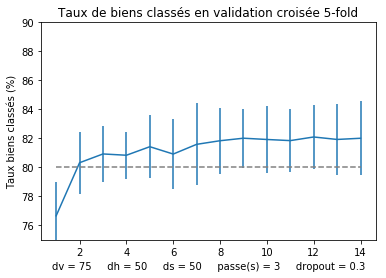

In [69]:
printCrossValidation2(reussites33, 75, 50, 50, 3, 0.3) 

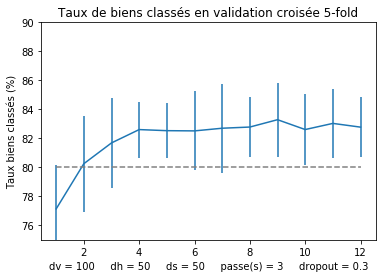

In [14]:
printCrossValidation2(reussites33, 100, 50, 50, 3, 0.3) 

In [61]:
reussites34 = CrossValidation(cross_val_data, dv = 100, dh = 50, ds = 50, hops = 3, dropout = 0.4, runs = [3,3,6])
reussites34

Agent's number of parameters : 855214 
Agent's number of parameters : 133014 
0m 16s (- 3m 47s) (100 6%) 2.6191 0.85
0m 35s (- 3m 49s) (200 13%) 2.5338 0.87
0m 52s (- 3m 29s) (300 20%) 2.5236 0.83
1m 7s (- 3m 4s) (400 26%) 2.3983 0.74
1m 24s (- 2m 49s) (500 33%) 2.3921 0.74
1m 41s (- 2m 32s) (600 40%) 2.2158 0.63
1m 59s (- 2m 16s) (700 46%) 2.1325 0.63
2m 15s (- 1m 58s) (800 53%) 1.9881 0.59
2m 29s (- 1m 39s) (900 60%) 1.8685 0.49
2m 45s (- 1m 22s) (1000 66%) 1.8594 0.56
3m 3s (- 1m 6s) (1100 73%) 1.6676 0.49
3m 19s (- 0m 49s) (1200 80%) 1.6050 0.46
3m 37s (- 0m 33s) (1300 86%) 1.6010 0.53
3m 56s (- 0m 16s) (1400 93%) 1.5258 0.46
4m 12s (- 0m 0s) (1500 100%) 1.4351 0.45
epoch 1
0m 20s (- 2m 53s) (100 10%) 0.6149 0.15
0m 39s (- 2m 25s) (200 21%) 0.8504 0.32
1m 0s (- 2m 8s) (300 32%) 0.9889 0.37
1m 23s (- 1m 51s) (400 42%) 0.6710 0.22
1m 46s (- 1m 33s) (500 53%) 0.9320 0.26
2m 5s (- 1m 10s) (600 64%) 0.7631 0.21
2m 25s (- 0m 49s) (700 74%) 0.7793 0.27
2m 44s (- 0m 28s) (800 85%) 1.0102 0

0m 16s (- 3m 45s) (100 6%) 0.1270 0.04
0m 35s (- 3m 48s) (200 13%) 0.1523 0.03
0m 52s (- 3m 28s) (300 20%) 0.1560 0.03
1m 6s (- 3m 3s) (400 26%) 0.1730 0.07
1m 24s (- 2m 48s) (500 33%) 0.2307 0.06
1m 41s (- 2m 32s) (600 40%) 0.0848 0.02
1m 58s (- 2m 15s) (700 46%) 0.1834 0.08
2m 14s (- 1m 57s) (800 53%) 0.1231 0.04
2m 29s (- 1m 39s) (900 60%) 0.2127 0.12
2m 44s (- 1m 22s) (1000 66%) 0.1184 0.03
3m 2s (- 1m 6s) (1100 73%) 0.1553 0.02
3m 19s (- 0m 49s) (1200 80%) 0.1619 0.07
3m 36s (- 0m 33s) (1300 86%) 0.1878 0.05
3m 55s (- 0m 16s) (1400 93%) 0.1882 0.06
4m 11s (- 0m 0s) (1500 100%) 0.1814 0.06
epoch 1
0m 20s (- 2m 49s) (100 10%) 0.1501 0.03
0m 39s (- 2m 24s) (200 21%) 0.1451 0.05
1m 0s (- 2m 8s) (300 32%) 0.3022 0.12
1m 23s (- 1m 52s) (400 42%) 0.2537 0.06
1m 46s (- 1m 33s) (500 53%) 0.2151 0.06
2m 5s (- 1m 10s) (600 64%) 0.1487 0.05
2m 25s (- 0m 49s) (700 74%) 0.2500 0.12
2m 44s (- 0m 28s) (800 85%) 0.3161 0.14
3m 4s (- 0m 7s) (900 96%) 0.2212 0.09
Taux de biens classés en validation 

0m 15s (- 3m 41s) (100 6%) 0.2291 0.07
0m 33s (- 3m 39s) (200 13%) 0.2393 0.10
0m 49s (- 3m 17s) (300 20%) 0.3038 0.09
1m 2s (- 2m 52s) (400 26%) 0.2415 0.08
1m 20s (- 2m 40s) (500 33%) 0.3570 0.13
1m 37s (- 2m 26s) (600 40%) 0.3424 0.13
1m 54s (- 2m 10s) (700 46%) 0.3291 0.08
2m 10s (- 1m 54s) (800 53%) 0.3100 0.08
2m 25s (- 1m 36s) (900 60%) 0.2626 0.09
2m 41s (- 1m 20s) (1000 66%) 0.2300 0.07
2m 58s (- 1m 5s) (1100 73%) 0.4766 0.16
3m 14s (- 0m 48s) (1200 80%) 0.2756 0.09
3m 33s (- 0m 32s) (1300 86%) 0.3522 0.09
3m 50s (- 0m 16s) (1400 93%) 0.3607 0.15
4m 7s (- 0m 0s) (1500 100%) 0.2908 0.10
epoch 1
0m 21s (- 2m 57s) (100 10%) 0.4378 0.16
0m 40s (- 2m 29s) (200 21%) 0.2404 0.09
1m 4s (- 2m 17s) (300 31%) 0.2705 0.06
1m 27s (- 1m 57s) (400 42%) 0.2233 0.10
1m 48s (- 1m 35s) (500 53%) 0.3110 0.10
2m 9s (- 1m 13s) (600 63%) 0.2167 0.06
2m 31s (- 0m 52s) (700 74%) 0.1921 0.03
2m 51s (- 0m 30s) (800 85%) 0.3826 0.14
3m 12s (- 0m 8s) (900 95%) 0.2725 0.10
Taux de biens classés en validati

0m 14s (- 3m 29s) (100 6%) 2.6203 0.91
0m 34s (- 3m 42s) (200 13%) 2.5567 0.81
0m 49s (- 3m 16s) (300 20%) 2.5338 0.82
1m 3s (- 2m 54s) (400 26%) 2.4372 0.76
1m 17s (- 2m 35s) (500 33%) 2.4264 0.78
1m 35s (- 2m 23s) (600 40%) 2.2390 0.74
1m 51s (- 2m 7s) (700 46%) 2.0855 0.70
2m 5s (- 1m 49s) (800 53%) 1.9823 0.59
2m 20s (- 1m 33s) (900 60%) 1.8886 0.54
2m 35s (- 1m 17s) (1000 66%) 1.8478 0.60
2m 52s (- 1m 2s) (1100 73%) 1.5870 0.40
3m 7s (- 0m 46s) (1200 80%) 1.6044 0.52
3m 24s (- 0m 31s) (1300 86%) 1.5918 0.53
3m 42s (- 0m 15s) (1400 93%) 1.4616 0.47
3m 58s (- 0m 0s) (1500 100%) 1.3448 0.38
epoch 1
0m 19s (- 2m 46s) (100 10%) 0.9231 0.29
0m 40s (- 2m 29s) (200 21%) 0.8820 0.30
1m 2s (- 2m 14s) (300 31%) 0.8264 0.25
1m 24s (- 1m 54s) (400 42%) 0.6342 0.21
1m 47s (- 1m 34s) (500 53%) 0.8012 0.26
2m 6s (- 1m 12s) (600 63%) 0.8247 0.25
2m 29s (- 0m 52s) (700 74%) 0.7140 0.19
2m 50s (- 0m 30s) (800 84%) 1.0441 0.33
3m 10s (- 0m 9s) (900 95%) 0.8610 0.32
Taux de biens classés en validation

0m 49s (- 3m 18s) (300 20%) 0.1413 0.05
1m 3s (- 2m 55s) (400 26%) 0.1157 0.04
1m 18s (- 2m 37s) (500 33%) 0.1675 0.05
1m 36s (- 2m 24s) (600 40%) 0.0956 0.04
1m 52s (- 2m 8s) (700 46%) 0.1471 0.08
2m 6s (- 1m 50s) (800 53%) 0.1189 0.03
2m 21s (- 1m 34s) (900 60%) 0.1609 0.06
2m 36s (- 1m 18s) (1000 66%) 0.1244 0.02
2m 53s (- 1m 3s) (1100 73%) 0.1020 0.04
3m 8s (- 0m 47s) (1200 80%) 0.1359 0.04
3m 25s (- 0m 31s) (1300 86%) 0.1375 0.04
3m 42s (- 0m 15s) (1400 93%) 0.1598 0.03
3m 59s (- 0m 0s) (1500 100%) 0.0926 0.02
epoch 1
0m 20s (- 2m 50s) (100 10%) 0.3107 0.08
0m 40s (- 2m 31s) (200 21%) 0.1091 0.02
1m 3s (- 2m 15s) (300 31%) 0.2188 0.06
1m 24s (- 1m 55s) (400 42%) 0.0740 0.01
1m 47s (- 1m 35s) (500 53%) 0.1432 0.05
2m 7s (- 1m 12s) (600 63%) 0.1819 0.06
2m 30s (- 0m 52s) (700 74%) 0.2132 0.07
2m 50s (- 0m 30s) (800 84%) 0.3154 0.11
3m 10s (- 0m 9s) (900 95%) 0.1990 0.11
Taux de biens classés en validation au run 9 : 81.78
0m 14s (- 3m 28s) (100 6%) 0.1342 0.03
0m 34s (- 3m 44s) (200

0m 50s (- 3m 20s) (300 20%) 0.2790 0.08
1m 3s (- 2m 55s) (400 26%) 0.2825 0.10
1m 18s (- 2m 37s) (500 33%) 0.3101 0.10
1m 37s (- 2m 26s) (600 40%) 0.2979 0.08
1m 54s (- 2m 10s) (700 46%) 0.3054 0.09
2m 9s (- 1m 53s) (800 53%) 0.2083 0.10
2m 23s (- 1m 35s) (900 60%) 0.2040 0.06
2m 40s (- 1m 20s) (1000 66%) 0.3086 0.10
2m 56s (- 1m 4s) (1100 73%) 0.1793 0.04
3m 12s (- 0m 48s) (1200 80%) 0.2710 0.11
3m 29s (- 0m 32s) (1300 86%) 0.4500 0.14
3m 46s (- 0m 16s) (1400 93%) 0.2133 0.04
4m 4s (- 0m 0s) (1500 100%) 0.2253 0.07
epoch 1
0m 21s (- 2m 59s) (100 10%) 0.3534 0.11
0m 41s (- 2m 33s) (200 21%) 0.4606 0.10
1m 3s (- 2m 16s) (300 31%) 0.3076 0.09
1m 24s (- 1m 55s) (400 42%) 0.2314 0.09
1m 47s (- 1m 35s) (500 52%) 0.2760 0.07
2m 9s (- 1m 14s) (600 63%) 0.2191 0.06
2m 31s (- 0m 53s) (700 74%) 0.3085 0.13
2m 51s (- 0m 31s) (800 84%) 0.3115 0.11
3m 11s (- 0m 9s) (900 95%) 0.2469 0.09
Taux de biens classés en validation au run 5 : 79.49
0m 15s (- 3m 38s) (100 6%) 0.4093 0.14
0m 33s (- 3m 40s) (20

0m 48s (- 3m 15s) (300 20%) 2.4962 0.84
1m 4s (- 2m 56s) (400 26%) 2.4118 0.74
1m 17s (- 2m 35s) (500 33%) 2.3672 0.77
1m 36s (- 2m 25s) (600 40%) 2.1748 0.63
1m 53s (- 2m 9s) (700 46%) 2.0968 0.67
2m 8s (- 1m 52s) (800 53%) 1.9809 0.65
2m 23s (- 1m 35s) (900 60%) 1.9761 0.52
2m 40s (- 1m 20s) (1000 66%) 1.6606 0.44
2m 56s (- 1m 4s) (1100 73%) 1.5919 0.45
3m 12s (- 0m 48s) (1200 80%) 1.5695 0.46
3m 29s (- 0m 32s) (1300 86%) 1.6380 0.56
3m 46s (- 0m 16s) (1400 93%) 1.4648 0.48
4m 5s (- 0m 0s) (1500 100%) 1.4124 0.45
epoch 1
0m 21s (- 3m 6s) (100 10%) 0.9829 0.32
0m 41s (- 2m 36s) (200 21%) 0.7754 0.23
1m 3s (- 2m 16s) (300 31%) 0.8851 0.30
1m 24s (- 1m 56s) (400 42%) 0.6999 0.22
1m 44s (- 1m 33s) (500 52%) 0.6650 0.22
2m 5s (- 1m 13s) (600 63%) 0.9532 0.32
2m 26s (- 0m 52s) (700 73%) 0.8962 0.30
2m 45s (- 0m 31s) (800 84%) 0.9477 0.33
3m 5s (- 0m 10s) (900 94%) 0.6940 0.23
Taux de biens classés en validation au run 1 : 79.04 %
0m 15s (- 3m 39s) (100 6%) 1.2013 0.34
0m 32s (- 3m 33s) (20

1m 17s (- 2m 35s) (500 33%) 0.1661 0.03
1m 36s (- 2m 25s) (600 40%) 0.2054 0.08
1m 52s (- 2m 8s) (700 46%) 0.2271 0.07
2m 7s (- 1m 51s) (800 53%) 0.0875 0.00
2m 22s (- 1m 34s) (900 60%) 0.2300 0.09
2m 39s (- 1m 19s) (1000 66%) 0.1236 0.01
2m 55s (- 1m 3s) (1100 73%) 0.0957 0.04
3m 11s (- 0m 47s) (1200 80%) 0.1101 0.02
3m 29s (- 0m 32s) (1300 86%) 0.2491 0.07
3m 46s (- 0m 16s) (1400 93%) 0.1739 0.05
4m 6s (- 0m 0s) (1500 100%) 0.1397 0.03
epoch 1
0m 23s (- 3m 22s) (100 10%) 0.2457 0.07
0m 45s (- 2m 48s) (200 21%) 0.2678 0.10
1m 8s (- 2m 27s) (300 31%) 0.1323 0.03
1m 29s (- 2m 3s) (400 42%) 0.1753 0.06
1m 49s (- 1m 38s) (500 52%) 0.2190 0.05
2m 10s (- 1m 16s) (600 63%) 0.2648 0.08
2m 31s (- 0m 54s) (700 73%) 0.2328 0.07
2m 50s (- 0m 31s) (800 84%) 0.2922 0.10
3m 10s (- 0m 10s) (900 94%) 0.1575 0.07
Taux de biens classés en validation au run 9 : 83.41
0m 15s (- 3m 39s) (100 6%) 0.1947 0.05
0m 33s (- 3m 35s) (200 13%) 0.1764 0.03
0m 48s (- 3m 14s) (300 20%) 0.1481 0.04
1m 3s (- 2m 55s) (40

[[75.20661157024793,
  82.64462809917356,
  85.12396694214877,
  83.88429752066115,
  85.53719008264463,
  87.19008264462809,
  86.77685950413223,
  87.19008264462809,
  87.60330578512396,
  88.4297520661157,
  86.77685950413223,
  87.19008264462809],
 [76.05042016806722,
  79.41176470588236,
  77.31092436974791,
  78.99159663865547,
  79.83193277310924,
  80.67226890756302,
  79.83193277310924,
  81.5126050420168,
  81.09243697478992,
  81.9327731092437,
  81.5126050420168,
  81.5126050420168],
 [77.96610169491525,
  79.23728813559322,
  81.35593220338984,
  81.35593220338984,
  82.62711864406779,
  81.77966101694916,
  82.62711864406779,
  80.93220338983052,
  81.77966101694916,
  82.62711864406779,
  82.62711864406779,
  82.20338983050848],
 [74.78632478632478,
  77.77777777777779,
  82.05128205128204,
  80.76923076923077,
  79.48717948717949,
  80.76923076923077,
  82.05128205128204,
  82.05128205128204,
  81.62393162393163,
  82.47863247863248,
  82.05128205128204,
  82.9059829059

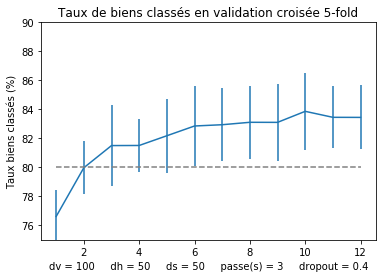

In [16]:
printCrossValidation2(reussites34, 100, 50, 50, 3, 0.4) 

### 4.3 Entrainement

In [43]:
def computePartition(Y) :
    partition = {}
    lis = list(np.unique(Y))
    lis = [int(el) for el in lis]
    for j in lis :
        partition[j] = []
    for i in range(len(Y)):
        j = int(Y[i])
        partition[j].append(i)
    return partition

In [44]:
def trainModel(model, X_trn, Y_trn, runs = [4, 4], mb = 1):
    par = computePartition(Y_trn)
    model.train()
    for run in range(1, runs[0]+1) :
        cl_trainer.train(model, X_trn, Y_trn, n_iters = 1500, mini_batch_size = 1, learning_rate=0.01, dic = par)
        cl_trainer.train(model, X_trn, Y_trn, n_epochs = 1, mini_batch_size = mb, learning_rate=0.01)
    if len(runs) >= 2 :
        for run in range(runs[0]+1, runs[0]+runs[1]+1) :
            cl_trainer.train(model, X_trn, Y_trn, n_iters = 1500, mini_batch_size = 1, learning_rate=0.005, dic = par)
            cl_trainer.train(model, X_trn, Y_trn, n_epochs = 1, mini_batch_size = mb, learning_rate=0.005)
    if len(runs) >= 3 :
        for run in range(runs[0]+runs[1]+1, runs[0]+runs[1]+runs[2]+1) :
            cl_trainer.train(model, X_trn, Y_trn, n_iters = 1500, mini_batch_size = 1, learning_rate=0.0025, dic = par)
            cl_trainer.train(model, X_trn, Y_trn, n_epochs = 1, mini_batch_size = mb, learning_rate=0.0025)
    if len(runs) >= 4 :
        for run in range(runs[0]+runs[1]+runs[2]+1, runs[0]+runs[1]+runs[2]+runs[3]+1) :
            cl_trainer.train(model, X_trn, Y_trn, n_iters = 1500, mini_batch_size = 1, learning_rate=0.001, dic = par)
            cl_trainer.train(model, X_trn, Y_trn, n_epochs = 1, mini_batch_size = mb, learning_rate=0.001)
    if len(runs) >= 5 :
        for run in range(runs[0]+runs[1]+runs[2]+runs[3]+1, runs[0]+runs[1]+runs[2]+runs[3]+runs[4]+1) :
            cl_trainer.train(model, X_trn, Y_trn, n_iters = 1500, mini_batch_size = 1, learning_rate=0.0005, dic = par)
            cl_trainer.train(model, X_trn, Y_trn, n_epochs = 1, mini_batch_size = mb, learning_rate=0.0005)

In [45]:
def evalModel(model, X_trn, Y_trn, runs = [4, 4], mb = 1):
    par = computePartition(Y_trn)
    for run in range(1, runs[0]+1) :
        model.train()
        cl_trainer.train(model, X_trn, Y_trn, n_iters = 1500, mini_batch_size = 1, learning_rate=0.01, dic = par)
        cl_trainer.train(model, X_trn, Y_trn, n_epochs = 1, mini_batch_size = mb, learning_rate=0.01)
        model.eval()
        erreurs_tst = compteErreurs(model, X_tst_torch, Y_tst_torch, n_classes = 14)
        print('Taux de biens classés dans un problème à {} classes : {:.2f} %'.format(14, 100*(1 - sum(erreurs_tst)/len(X_tst_torch))))
    if len(runs) >= 2 :
        for run in range(runs[0]+1, runs[0]+runs[1]+1) :
            model.train()
            cl_trainer.train(model, X_trn, Y_trn, n_iters = 1500, mini_batch_size = 1, learning_rate=0.005, dic = par)
            cl_trainer.train(model, X_trn, Y_trn, n_epochs = 1, mini_batch_size = mb, learning_rate=0.005)
            model.eval()
            erreurs_tst = compteErreurs(model, X_tst_torch, Y_tst_torch, n_classes = 14)
            print('Taux de biens classés dans un problème à {} classes : {:.2f} %'.format(14, 100*(1 - sum(erreurs_tst)/len(X_tst_torch))))
    if len(runs) >= 3 :
        for run in range(runs[0]+runs[1]+1, runs[0]+runs[1]+runs[2]+1) :
            model.train()
            cl_trainer.train(model, X_trn, Y_trn, n_iters = 1500, mini_batch_size = 1, learning_rate=0.0025, dic = par)
            cl_trainer.train(model, X_trn, Y_trn, n_epochs = 1, mini_batch_size = mb, learning_rate=0.0025)
            model.eval()
            erreurs_tst = compteErreurs(model, X_tst_torch, Y_tst_torch, n_classes = 14)
            print('Taux de biens classés dans un problème à {} classes : {:.2f} %'.format(14, 100*(1 - sum(erreurs_tst)/len(X_tst_torch))))
    if len(runs) >= 4 :
        for run in range(runs[0]+runs[1]+runs[2]+1, runs[0]+runs[1]+runs[2]+runs[3]+1) :
            model.train()
            cl_trainer.train(model, X_trn, Y_trn, n_iters = 1500, mini_batch_size = 1, learning_rate=0.001, dic = par)
            cl_trainer.train(model, X_trn, Y_trn, n_epochs = 1, mini_batch_size = mb, learning_rate=0.001)
            model.eval()
            erreurs_tst = compteErreurs(model, X_tst_torch, Y_tst_torch, n_classes = 14)
            print('Taux de biens classés dans un problème à {} classes : {:.2f} %'.format(14, 100*(1 - sum(erreurs_tst)/len(X_tst_torch))))
    if len(runs) >= 5 :
        for run in range(runs[0]+runs[1]+runs[2]+runs[3]+1, runs[0]+runs[1]+runs[2]+runs[3]+runs[4]+1) :
            model.train()
            cl_trainer.train(model, X_trn, Y_trn, n_iters = 1500, mini_batch_size = 1, learning_rate=0.0005, dic = par)
            cl_trainer.train(model, X_trn, Y_trn, n_epochs = 1, mini_batch_size = mb, learning_rate=0.0005)
            model.eval()
            erreurs_tst = compteErreurs(model, X_tst_torch, Y_tst_torch, n_classes = 14)
            print('Taux de biens classés dans un problème à {} classes : {:.2f} %'.format(14, 100*(1 - sum(erreurs_tst)/len(X_tst_torch))))

**Training**

**Avec pré-entrainement manuel**

La vectorisation est performante, et le modèle est ajusté (par miracle)

In [105]:
random.seed(42)
np.random.seed(42)
model = initClassifier(lang = lang_Lilly, dv = 100, dh = 50, attn = True, ds = 50, hops = 3, dropout = 0.4) # lang_complete

Agent's number of parameters : 478714 


In [106]:
def attachEmbedding(model, emb = None):
    if emb is not None :
        model.text_encoder.word_encoder.embedding = emb.embedding
    else :
        emb = SkipGram(lang_Lilly, context_size = 5, embedding_dim = 100, hidden_dim = 100)
        emb.load_state_dict(torch.load(path_to_rep + '\saves\\skipgram_100_Lilly_hierarchique.pth'))

    model.text_encoder.word_encoder.embedding.weight.requires_grad = False
    print("Agent's number of parameters : {} ".format(model.nbParametres()))
    return model

In [107]:
model = attachEmbedding(model, skipgram) # skipgram  skipgram_complet

Agent's number of parameters : 133014 


In [103]:
# pour charger un modèle :
#model.load_state_dict(torch.load(path_to_rep + '\saves\\hierarchical_model_Lilly.pth'))


# pour racrocher la vectorisation des mots dans les paramètres :
#model.text_encoder.word_encoder.embedding.weight.requires_grad = True
#print("Agent's number of parameters : {} ".format(model.nbParametres()))

In [92]:
# skipgram sur dev, dv = 75, dropout = 0.2
evalModel(model, X_dev_torch, Y_dev_torch, runs = [1,1,5,5], mb = 1)

0m 19s (- 4m 37s) (100 6%) 2.6461 0.91
0m 40s (- 4m 20s) (200 13%) 2.5639 0.82
1m 0s (- 4m 0s) (300 20%) 2.5227 0.83
1m 17s (- 3m 33s) (400 26%) 2.3894 0.75
1m 34s (- 3m 9s) (500 33%) 2.3840 0.74
1m 54s (- 2m 51s) (600 40%) 2.2304 0.61
2m 10s (- 2m 29s) (700 46%) 2.1084 0.65
2m 28s (- 2m 10s) (800 53%) 1.9892 0.57
2m 48s (- 1m 52s) (900 60%) 1.7071 0.38
3m 5s (- 1m 32s) (1000 66%) 1.6769 0.48
3m 24s (- 1m 14s) (1100 73%) 1.5893 0.48
3m 44s (- 0m 56s) (1200 80%) 1.5267 0.45
4m 1s (- 0m 37s) (1300 86%) 1.4308 0.38
4m 21s (- 0m 18s) (1400 93%) 1.2604 0.41
4m 41s (- 0m 0s) (1500 100%) 1.4758 0.52
epoch 1
0m 26s (- 4m 44s) (100 8%) 0.7922 0.24
0m 49s (- 4m 0s) (200 16%) 0.7307 0.22
1m 14s (- 3m 39s) (300 25%) 0.8168 0.24
1m 39s (- 3m 13s) (400 33%) 0.6455 0.19
1m 59s (- 2m 42s) (500 42%) 0.7771 0.27
2m 24s (- 2m 19s) (600 50%) 0.6939 0.22
2m 50s (- 1m 56s) (700 59%) 0.5996 0.21
3m 9s (- 1m 29s) (800 67%) 0.7302 0.24
3m 32s (- 1m 5s) (900 76%) 0.7426 0.26
3m 58s (- 0m 42s) (1000 84%) 0.7517 

4m 7s (- 1m 1s) (1200 80%) 0.1957 0.06
4m 28s (- 0m 41s) (1300 86%) 0.1668 0.07
4m 51s (- 0m 20s) (1400 93%) 0.1980 0.05
5m 13s (- 0m 0s) (1500 100%) 0.2400 0.07
epoch 1
0m 29s (- 5m 16s) (100 8%) 0.2969 0.10
0m 54s (- 4m 26s) (200 16%) 0.2050 0.07
1m 21s (- 3m 59s) (300 25%) 0.2796 0.08
1m 47s (- 3m 29s) (400 33%) 0.2037 0.06
2m 9s (- 2m 55s) (500 42%) 0.2779 0.08
2m 35s (- 2m 29s) (600 50%) 0.1834 0.05
3m 0s (- 2m 3s) (700 59%) 0.1814 0.05
3m 19s (- 1m 34s) (800 67%) 0.2020 0.09
3m 43s (- 1m 9s) (900 76%) 0.1581 0.04
4m 7s (- 0m 44s) (1000 84%) 0.1634 0.07
4m 34s (- 0m 19s) (1100 93%) 0.3078 0.13
Taux de biens classés dans un problème à 14 classes : 84.11 %
0m 20s (- 4m 42s) (100 6%) 0.2203 0.07
0m 40s (- 4m 26s) (200 13%) 0.2052 0.04
1m 1s (- 4m 4s) (300 20%) 0.2310 0.06
1m 20s (- 3m 40s) (400 26%) 0.1788 0.06
1m 37s (- 3m 15s) (500 33%) 0.2271 0.06
1m 58s (- 2m 57s) (600 40%) 0.1760 0.05
2m 14s (- 2m 34s) (700 46%) 0.1665 0.02
2m 33s (- 2m 13s) (800 53%) 0.1809 0.05
2m 53s (- 1m 55

In [57]:
# skipgram sur dev, dv = 75, dropout = 0.3
evalModel(model, X_dev_torch, Y_dev_torch, runs = [1,1,5,5], mb = 1)

0m 19s (- 4m 37s) (100 6%) 2.6447 0.91
0m 40s (- 4m 20s) (200 13%) 2.5875 0.89
0m 59s (- 3m 59s) (300 20%) 2.5748 0.84
1m 18s (- 3m 34s) (400 26%) 2.4656 0.76
1m 35s (- 3m 10s) (500 33%) 2.3993 0.66
1m 55s (- 2m 53s) (600 40%) 2.3550 0.73
2m 12s (- 2m 31s) (700 46%) 2.2604 0.68
2m 30s (- 2m 11s) (800 53%) 2.0977 0.61
2m 49s (- 1m 52s) (900 60%) 1.8972 0.50
3m 6s (- 1m 33s) (1000 66%) 1.7590 0.50
3m 25s (- 1m 14s) (1100 73%) 1.6986 0.53
3m 45s (- 0m 56s) (1200 80%) 1.6034 0.49
4m 3s (- 0m 37s) (1300 86%) 1.5197 0.45
4m 23s (- 0m 18s) (1400 93%) 1.3767 0.36
4m 42s (- 0m 0s) (1500 100%) 1.6200 0.53
epoch 1
0m 25s (- 4m 38s) (100 8%) 0.8295 0.25
0m 47s (- 3m 54s) (200 16%) 0.8541 0.22
1m 12s (- 3m 31s) (300 25%) 0.8237 0.25
1m 36s (- 3m 7s) (400 33%) 0.6490 0.21
1m 56s (- 2m 38s) (500 42%) 0.8732 0.28
2m 21s (- 2m 16s) (600 50%) 0.7721 0.26
2m 46s (- 1m 53s) (700 59%) 0.6139 0.20
3m 5s (- 1m 27s) (800 67%) 0.7775 0.26
3m 26s (- 1m 4s) (900 76%) 0.8965 0.32
3m 48s (- 0m 40s) (1000 84%) 0.82

3m 46s (- 0m 56s) (1200 80%) 0.3136 0.08
4m 4s (- 0m 37s) (1300 86%) 0.2618 0.08
4m 24s (- 0m 18s) (1400 93%) 0.2884 0.07
4m 45s (- 0m 0s) (1500 100%) 0.3210 0.09
epoch 1
0m 26s (- 4m 44s) (100 8%) 0.4698 0.12
0m 48s (- 3m 58s) (200 16%) 0.3195 0.11
1m 13s (- 3m 35s) (300 25%) 0.4357 0.14
1m 39s (- 3m 13s) (400 33%) 0.3014 0.11
2m 2s (- 2m 45s) (500 42%) 0.3666 0.10
2m 30s (- 2m 25s) (600 50%) 0.2040 0.06
2m 58s (- 2m 1s) (700 59%) 0.2318 0.07
3m 19s (- 1m 34s) (800 67%) 0.3892 0.13
3m 43s (- 1m 9s) (900 76%) 0.3608 0.10
4m 7s (- 0m 44s) (1000 84%) 0.2160 0.06
4m 34s (- 0m 19s) (1100 93%) 0.3471 0.12
Taux de biens classés dans un problème à 14 classes : 83.44 %
0m 20s (- 4m 51s) (100 6%) 0.3171 0.08
0m 42s (- 4m 39s) (200 13%) 0.3464 0.15
1m 4s (- 4m 18s) (300 20%) 0.3598 0.10
1m 23s (- 3m 50s) (400 26%) 0.2889 0.10
1m 42s (- 3m 24s) (500 33%) 0.2933 0.06
2m 3s (- 3m 5s) (600 40%) 0.2568 0.07
2m 20s (- 2m 41s) (700 46%) 0.3651 0.12
2m 39s (- 2m 19s) (800 53%) 0.3414 0.14
3m 0s (- 2m 0s

In [96]:
# skipgram sur dev, dv = 75, dropout = 0.4
evalModel(model, X_dev_torch, Y_dev_torch, runs = [1,1,5,5], mb = 1)

0m 19s (- 4m 32s) (100 6%) 2.6654 0.94
0m 39s (- 4m 19s) (200 13%) 2.5895 0.86
0m 59s (- 3m 59s) (300 20%) 2.5602 0.90
1m 17s (- 3m 33s) (400 26%) 2.4445 0.71
1m 35s (- 3m 11s) (500 33%) 2.4363 0.74
1m 55s (- 2m 53s) (600 40%) 2.4092 0.71
2m 12s (- 2m 31s) (700 46%) 2.2478 0.70
2m 30s (- 2m 11s) (800 53%) 2.2056 0.63
2m 49s (- 1m 53s) (900 60%) 2.0053 0.59
3m 6s (- 1m 33s) (1000 66%) 1.8869 0.50
3m 25s (- 1m 14s) (1100 73%) 1.7925 0.57
3m 46s (- 0m 56s) (1200 80%) 1.7428 0.52
4m 4s (- 0m 37s) (1300 86%) 1.6889 0.52
4m 23s (- 0m 18s) (1400 93%) 1.5275 0.46
4m 42s (- 0m 0s) (1500 100%) 1.7038 0.53
epoch 1
0m 26s (- 4m 45s) (100 8%) 1.0309 0.32
0m 48s (- 3m 59s) (200 16%) 0.8897 0.28
1m 14s (- 3m 36s) (300 25%) 0.7952 0.25
1m 38s (- 3m 12s) (400 33%) 0.7501 0.21
1m 59s (- 2m 41s) (500 42%) 0.9995 0.31
2m 26s (- 2m 21s) (600 50%) 0.8764 0.29
2m 52s (- 1m 58s) (700 59%) 0.7256 0.21
3m 11s (- 1m 30s) (800 67%) 0.8564 0.24
3m 33s (- 1m 6s) (900 76%) 0.9452 0.31
3m 55s (- 0m 42s) (1000 84%) 0.

4m 14s (- 1m 3s) (1200 80%) 0.4354 0.15
4m 33s (- 0m 42s) (1300 86%) 0.4291 0.11
4m 55s (- 0m 21s) (1400 93%) 0.4708 0.14
5m 19s (- 0m 0s) (1500 100%) 0.4806 0.14
epoch 1
0m 30s (- 5m 32s) (100 8%) 0.4449 0.13
0m 54s (- 4m 29s) (200 16%) 0.4193 0.13
1m 22s (- 4m 1s) (300 25%) 0.4906 0.17
1m 48s (- 3m 31s) (400 33%) 0.3424 0.10
2m 10s (- 2m 57s) (500 42%) 0.4588 0.15
2m 37s (- 2m 31s) (600 50%) 0.3521 0.13
3m 4s (- 2m 5s) (700 59%) 0.3846 0.13
3m 24s (- 1m 36s) (800 67%) 0.4598 0.17
3m 48s (- 1m 10s) (900 76%) 0.4649 0.19
4m 12s (- 0m 45s) (1000 84%) 0.3376 0.09
4m 38s (- 0m 20s) (1100 93%) 0.3960 0.10
Taux de biens classés dans un problème à 14 classes : 83.11 %
0m 20s (- 4m 50s) (100 6%) 0.5535 0.20
0m 44s (- 4m 46s) (200 13%) 0.6035 0.18
1m 7s (- 4m 31s) (300 20%) 0.6445 0.22
1m 27s (- 4m 0s) (400 26%) 0.4393 0.14
1m 47s (- 3m 35s) (500 33%) 0.4748 0.16
2m 9s (- 3m 14s) (600 40%) 0.4868 0.14
2m 28s (- 2m 50s) (700 46%) 0.5778 0.20
2m 48s (- 2m 27s) (800 53%) 0.5061 0.18
3m 9s (- 2m 6

In [104]:
# skipgram sur dev, dv = 100, dropout = 0.3
evalModel(model, X_dev_torch, Y_dev_torch, runs = [1,1,5,5], mb = 1)

0m 23s (- 5m 28s) (100 6%) 2.6123 0.89
0m 48s (- 5m 12s) (200 13%) 2.5809 0.81
1m 11s (- 4m 44s) (300 20%) 2.5214 0.84
1m 32s (- 4m 13s) (400 26%) 2.2964 0.65
1m 52s (- 3m 45s) (500 33%) 2.2656 0.69
2m 16s (- 3m 25s) (600 40%) 2.1511 0.59
2m 36s (- 2m 58s) (700 46%) 2.0164 0.59
2m 56s (- 2m 34s) (800 53%) 1.9079 0.58
3m 19s (- 2m 12s) (900 60%) 1.7235 0.42
3m 39s (- 1m 49s) (1000 66%) 1.6051 0.42
4m 2s (- 1m 28s) (1100 73%) 1.5656 0.47
4m 26s (- 1m 6s) (1200 80%) 1.4975 0.45
4m 46s (- 0m 44s) (1300 86%) 1.4124 0.41
5m 9s (- 0m 22s) (1400 93%) 1.2636 0.34
5m 33s (- 0m 0s) (1500 100%) 1.4181 0.47
epoch 1
0m 30s (- 5m 29s) (100 8%) 0.8382 0.23
0m 56s (- 4m 38s) (200 16%) 0.8405 0.27
1m 25s (- 4m 11s) (300 25%) 0.8056 0.24
1m 53s (- 3m 41s) (400 33%) 0.6535 0.20
2m 17s (- 3m 6s) (500 42%) 0.7585 0.25
2m 46s (- 2m 40s) (600 50%) 0.7001 0.26
3m 14s (- 2m 12s) (700 59%) 0.5591 0.18
3m 37s (- 1m 43s) (800 67%) 0.7133 0.23
4m 2s (- 1m 15s) (900 76%) 0.7870 0.26
4m 28s (- 0m 47s) (1000 84%) 0.85

4m 24s (- 1m 6s) (1200 80%) 0.2783 0.08
4m 45s (- 0m 43s) (1300 86%) 0.2500 0.07
5m 8s (- 0m 22s) (1400 93%) 0.2381 0.09
5m 32s (- 0m 0s) (1500 100%) 0.1996 0.04
epoch 1
0m 30s (- 5m 32s) (100 8%) 0.3323 0.11
0m 56s (- 4m 37s) (200 16%) 0.3340 0.10
1m 25s (- 4m 11s) (300 25%) 0.2873 0.12
1m 54s (- 3m 42s) (400 33%) 0.2486 0.10
2m 17s (- 3m 7s) (500 42%) 0.3382 0.07
2m 46s (- 2m 40s) (600 50%) 0.2699 0.09
3m 15s (- 2m 13s) (700 59%) 0.2289 0.07
3m 37s (- 1m 43s) (800 67%) 0.2852 0.09
4m 2s (- 1m 15s) (900 76%) 0.2237 0.06
4m 28s (- 0m 48s) (1000 84%) 0.3137 0.08
4m 56s (- 0m 21s) (1100 93%) 0.2937 0.10
Taux de biens classés dans un problème à 14 classes : 83.44 %
0m 22s (- 5m 15s) (100 6%) 0.2988 0.08
0m 46s (- 5m 3s) (200 13%) 0.3070 0.09
1m 10s (- 4m 40s) (300 20%) 0.2614 0.05
1m 31s (- 4m 11s) (400 26%) 0.1820 0.04
1m 52s (- 3m 44s) (500 33%) 0.2473 0.05
2m 15s (- 3m 23s) (600 40%) 0.2016 0.04
2m 35s (- 2m 57s) (700 46%) 0.3130 0.08
2m 56s (- 2m 34s) (800 53%) 0.2758 0.08
3m 19s (- 2

In [108]:
# skipgram sur dev, dv = 100, dropout = 0.4
evalModel(model, X_dev_torch, Y_dev_torch, runs = [1,1,5,5], mb = 1)

0m 22s (- 5m 12s) (100 6%) 2.6284 0.87
0m 46s (- 4m 59s) (200 13%) 2.5820 0.84
1m 9s (- 4m 36s) (300 20%) 2.5773 0.85
1m 30s (- 4m 7s) (400 26%) 2.4570 0.76
1m 50s (- 3m 41s) (500 33%) 2.4558 0.76
2m 14s (- 3m 21s) (600 40%) 2.3492 0.66
2m 34s (- 2m 56s) (700 46%) 2.2320 0.68
2m 55s (- 2m 33s) (800 53%) 2.1486 0.70
3m 17s (- 2m 11s) (900 60%) 1.8902 0.49
3m 38s (- 1m 49s) (1000 66%) 1.7360 0.50
4m 1s (- 1m 27s) (1100 73%) 1.7602 0.55
4m 25s (- 1m 6s) (1200 80%) 1.6679 0.53
4m 45s (- 0m 43s) (1300 86%) 1.5977 0.54
5m 8s (- 0m 22s) (1400 93%) 1.3274 0.39
5m 31s (- 0m 0s) (1500 100%) 1.5483 0.55
epoch 1
0m 30s (- 5m 30s) (100 8%) 0.9503 0.31
0m 56s (- 4m 36s) (200 16%) 0.8786 0.26
1m 25s (- 4m 11s) (300 25%) 0.8538 0.28
1m 53s (- 3m 41s) (400 33%) 0.7757 0.23
2m 17s (- 3m 6s) (500 42%) 0.8335 0.30
2m 45s (- 2m 40s) (600 50%) 0.7219 0.22
3m 14s (- 2m 12s) (700 59%) 0.6748 0.20
3m 36s (- 1m 42s) (800 67%) 0.7363 0.25
4m 1s (- 1m 14s) (900 76%) 0.8831 0.32
4m 27s (- 0m 47s) (1000 84%) 0.8835

4m 29s (- 1m 7s) (1200 80%) 0.3888 0.14
4m 49s (- 0m 44s) (1300 86%) 0.3575 0.12
5m 13s (- 0m 22s) (1400 93%) 0.4246 0.16
5m 37s (- 0m 0s) (1500 100%) 0.4067 0.13
epoch 1
0m 30s (- 5m 28s) (100 8%) 0.5414 0.17
0m 56s (- 4m 36s) (200 16%) 0.3192 0.06
1m 25s (- 4m 9s) (300 25%) 0.3829 0.13
1m 52s (- 3m 39s) (400 33%) 0.3118 0.11
2m 16s (- 3m 5s) (500 42%) 0.4372 0.13
2m 45s (- 2m 39s) (600 50%) 0.3113 0.10
3m 14s (- 2m 12s) (700 59%) 0.3291 0.14
3m 36s (- 1m 42s) (800 67%) 0.3755 0.11
4m 1s (- 1m 14s) (900 76%) 0.4016 0.13
4m 27s (- 0m 47s) (1000 84%) 0.4147 0.13
4m 55s (- 0m 21s) (1100 93%) 0.4568 0.19
Taux de biens classés dans un problème à 14 classes : 82.12 %
0m 22s (- 5m 18s) (100 6%) 0.4883 0.15
0m 47s (- 5m 5s) (200 13%) 0.4892 0.16
1m 10s (- 4m 43s) (300 20%) 0.4659 0.14
1m 32s (- 4m 13s) (400 26%) 0.3259 0.08
1m 52s (- 3m 45s) (500 33%) 0.3528 0.10
2m 16s (- 3m 24s) (600 40%) 0.3900 0.11
2m 36s (- 2m 58s) (700 46%) 0.4764 0.19
2m 57s (- 2m 35s) (800 53%) 0.4753 0.16
3m 20s (- 2

In [83]:
# skipgram complet, dv = 75, dropout = 0.3
evalModel(model, X_dev_torch, Y_dev_torch, runs = [1,1,5,5], mb = 1)

0m 26s (- 6m 14s) (100 6%) 2.6653 0.92
0m 54s (- 5m 54s) (200 13%) 2.6486 0.89
1m 22s (- 5m 28s) (300 20%) 2.5863 0.88
1m 47s (- 4m 54s) (400 26%) 2.4500 0.77
2m 11s (- 4m 22s) (500 33%) 2.4898 0.81
2m 38s (- 3m 57s) (600 40%) 2.3879 0.69
3m 3s (- 3m 29s) (700 46%) 2.2941 0.70
3m 28s (- 3m 2s) (800 53%) 2.2010 0.69
3m 54s (- 2m 36s) (900 60%) 2.0574 0.61
4m 18s (- 2m 9s) (1000 66%) 1.8974 0.59
4m 46s (- 1m 44s) (1100 73%) 1.8797 0.59
5m 15s (- 1m 18s) (1200 80%) 1.8394 0.55
5m 39s (- 0m 52s) (1300 86%) 1.7061 0.47
6m 7s (- 0m 26s) (1400 93%) 1.5584 0.50
6m 35s (- 0m 0s) (1500 100%) 1.5794 0.51
epoch 1
0m 37s (- 6m 46s) (100 8%) 0.9246 0.24
1m 9s (- 5m 41s) (200 16%) 0.9244 0.28
1m 46s (- 5m 10s) (300 25%) 0.9021 0.25
2m 19s (- 4m 32s) (400 33%) 0.7359 0.24
2m 47s (- 3m 47s) (500 42%) 0.8382 0.27
3m 22s (- 3m 15s) (600 50%) 0.8129 0.22
3m 57s (- 2m 42s) (700 59%) 0.6039 0.18
4m 23s (- 2m 4s) (800 67%) 0.7978 0.25
4m 54s (- 1m 31s) (900 76%) 0.8325 0.27
5m 25s (- 0m 58s) (1000 84%) 0.909

4m 46s (- 1m 11s) (1200 80%) 0.2619 0.06
5m 9s (- 0m 47s) (1300 86%) 0.2805 0.08
5m 35s (- 0m 23s) (1400 93%) 0.3744 0.11
6m 2s (- 0m 0s) (1500 100%) 0.3026 0.08
epoch 1
0m 35s (- 6m 26s) (100 8%) 0.2706 0.08
1m 5s (- 5m 22s) (200 16%) 0.3269 0.11
1m 39s (- 4m 51s) (300 25%) 0.3318 0.10
2m 12s (- 4m 18s) (400 33%) 0.2743 0.11
2m 39s (- 3m 36s) (500 42%) 0.3500 0.13
3m 13s (- 3m 6s) (600 50%) 0.2349 0.09
3m 46s (- 2m 34s) (700 59%) 0.1908 0.06
4m 11s (- 1m 59s) (800 67%) 0.2396 0.09
4m 40s (- 1m 27s) (900 76%) 0.3156 0.11
5m 10s (- 0m 55s) (1000 84%) 0.3161 0.12
5m 43s (- 0m 24s) (1100 93%) 0.3202 0.10
Taux de biens classés dans un problème à 14 classes : 85.10 %
0m 25s (- 5m 51s) (100 6%) 0.3182 0.08
0m 52s (- 5m 43s) (200 13%) 0.3480 0.12
1m 19s (- 5m 17s) (300 20%) 0.3882 0.11
1m 43s (- 4m 43s) (400 26%) 0.3465 0.10
2m 6s (- 4m 12s) (500 33%) 0.3339 0.10
2m 33s (- 3m 49s) (600 40%) 0.2361 0.07
2m 54s (- 3m 19s) (700 46%) 0.3727 0.13
3m 18s (- 2m 53s) (800 53%) 0.3172 0.10
3m 43s (- 2

**Avec pré-entrainement de Gensim**

La vectorisation semble tres performante, mais le modèle sur-apprend

In [128]:
random.seed(42)
np.random.seed(42)
model = initClassifier(lang = Lilly_vocab, dv = 100, dh = 50, attn = True, ds = 50, hops = 3, dropout = 0.4)

Agent's number of parameters : 854914 


In [129]:
def attachGensimEmbedding(model, weights):
    model.text_encoder.word_encoder.embedding = nn.Embedding.from_pretrained(weights)
    model.text_encoder.word_encoder.embedding.weight.requires_grad = False
    print("Agent's number of parameters : {} ".format(model.nbParametres()))
    return model

In [130]:
model = attachGensimEmbedding(model, Lilly_weights)

Agent's number of parameters : 133014 


### 4.4 Evaluation

**Evaluation poussée au max**

In [90]:
model.eval()
erreurs_tst = compteErreurs(model, X_tst_torch, Y_tst_torch, n_classes = 14)
print('Taux de biens classés dans un problème à {} classes : {:.2f} %'.format(14, 100*(1 - sum(erreurs_tst)/len(X_tst_torch))))

Taux de biens classés dans un problème à 14 classes : 84.77 %


In [60]:
torch.save(model.state_dict(), path_to_rep + '\saves\\hierarchical_model_Lilly.pth')

**Evaluation après validation croisée**

In [107]:
model.load_state_dict(torch.load(path_to_rep + '\saves\\hierarchical_model_Lilly_crossval.pth'))

In [97]:
model.eval()
erreurs_tst = compteErreurs(model, X_tst_torch, Y_tst_torch, n_classes = 14)
print('Taux de biens classés dans un problème à {} classes : {:.2f} %'.format(14, 100*(1 - sum(erreurs_tst)/len(X_tst_torch))))

Taux de biens classés dans un problème à 14 classes : 83.77 %


In [98]:
torch.save(model.state_dict(), path_to_rep + '\saves\\hierarchical_model_Lilly_crossval.pth')

### Supplément technique

In [ ]:
# un petit test de l'import et le freeze de couches :

text_encoder = text_cl_Lilly_A.text_encoder
attention = text_cl_Lilly_A.attention
text_cl_Lilly_A = initClassifier(dv = 75, dh = 50, hops = 3, dropout = 0.2)
text_cl_Lilly_A.loadSubModule(text_encoder = text_encoder, attention = attention)
text_cl_Lilly_A.freezeSubModule(text_encoder = True, attention = True)
print("Agent's number of parameters : {} ".format(text_cl_Lilly_A.nbParametres()))

### 4.5 Exemples

target :  Checklist/Closeloop/Timeout
predic :  Checklist/Closeloop/Timeout


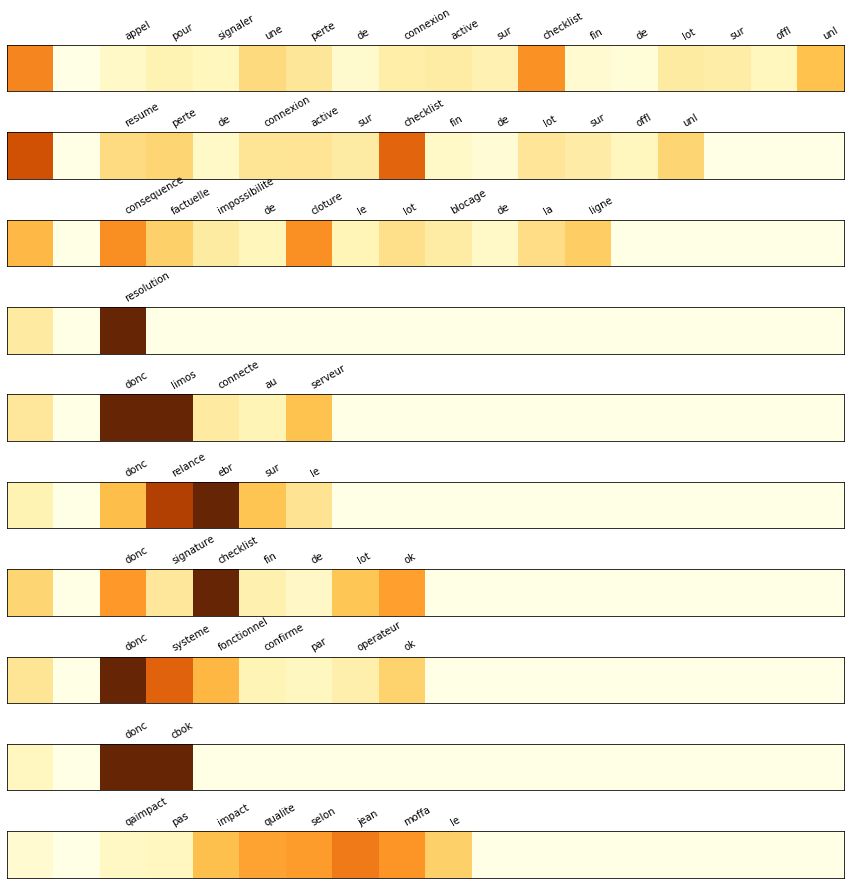

In [119]:
i = 264
description = X_tst_torch[i]
target = Y_tst_torch.data[i].numpy()
target = [int(val) for val in target]

model.showAttention(description, target, liste = Analyse_list, fig_size = (15,15), maxi = 1)

target :  Ebrfrozen/Startlimos
predic :  Checklist/Closeloop/Timeout


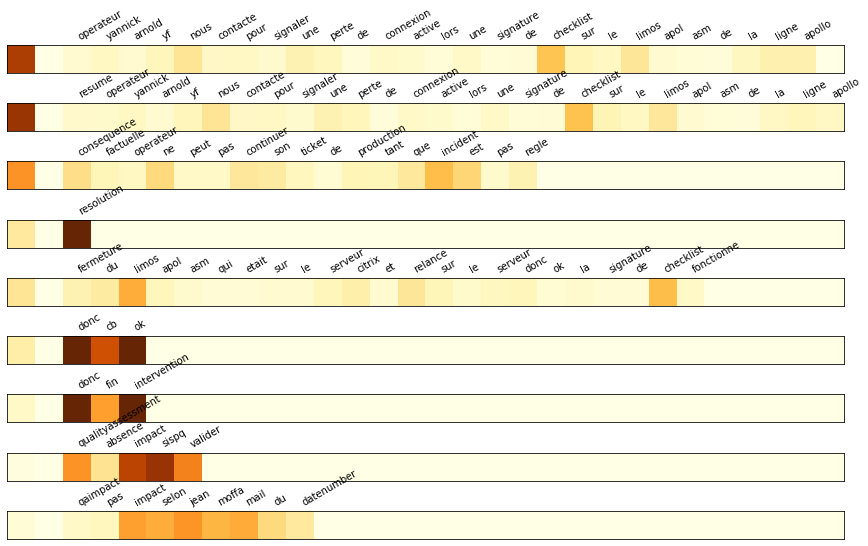

In [100]:
i = 246

description = X_tst_torch[i]
target = Y_tst_torch.data[i].numpy()
target = [int(val) for val in target]

model.showAttention(description, target, liste = Analyse_list, fig_size = (15,10), maxi = 1)

target :  Bug/Oneshot/Deviation 
predic :  Lcmovementerror


ValueError: num must be 1 <= num <= 15, not 16

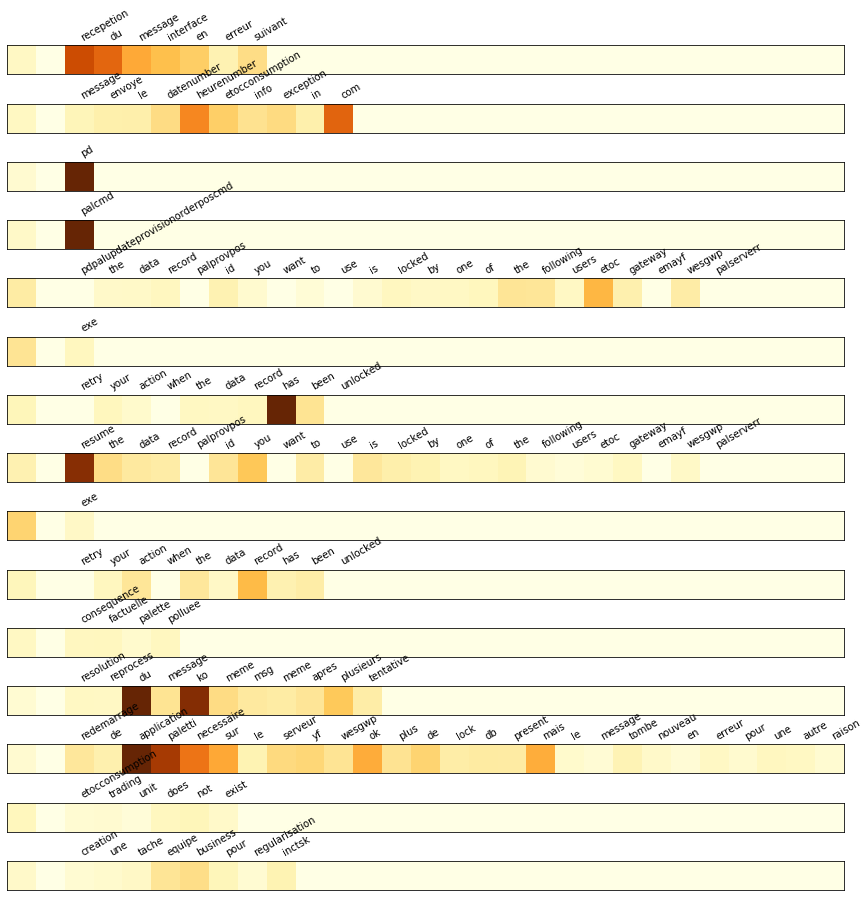

In [101]:
i = 300

description = X_tst_torch[i]
target = Y_tst_torch.data[i].numpy()
target = [int(val) for val in target]

model.showAttention(description, target, liste = Analyse_list, fig_size = (15,10), maxi = 1)

target :  Loginissue/Pwdmgmt
predic :  Hscope/Duplicate/Cslt/Action


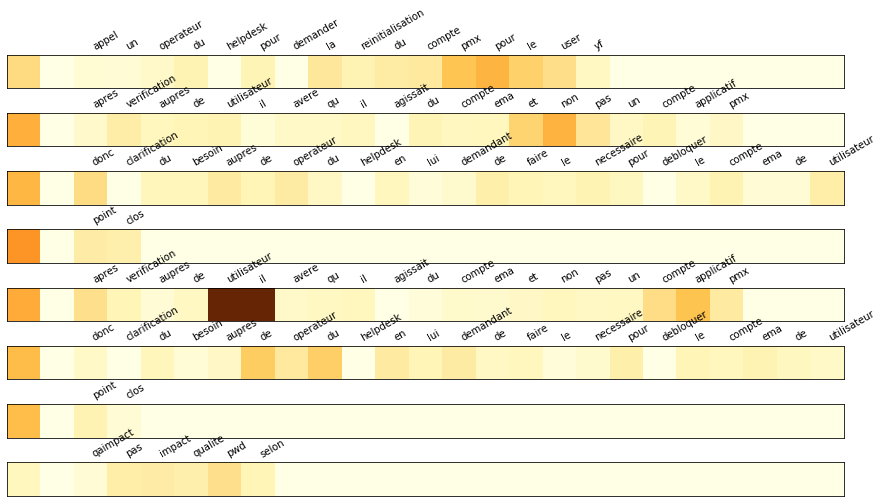

In [103]:
i = 294

description = X_tst_torch[i]
target = Y_tst_torch.data[i].numpy()
target = [int(val) for val in target]

model.showAttention(description, target, liste = Analyse_list, fig_size = (15,10), maxi = 1)

target :  Hscope/Duplicate/Cslt/Action
predic :  Hscope/Duplicate/Cslt/Action


ValueError: num must be 1 <= num <= 15, not 16

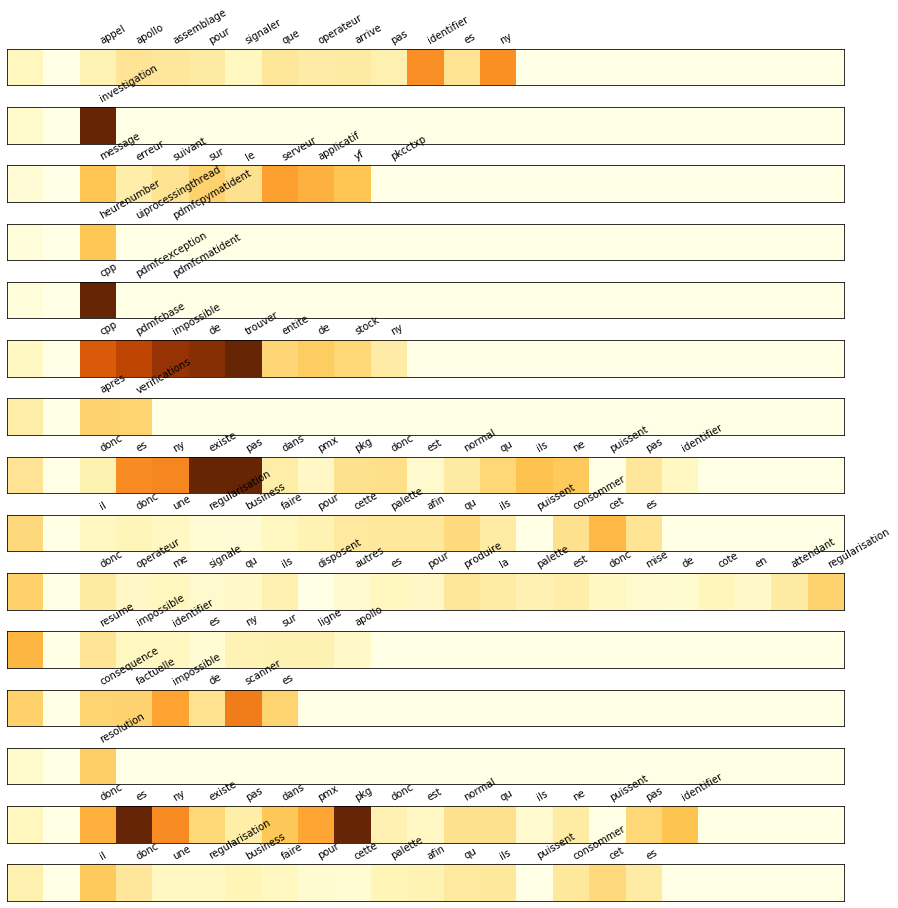

In [109]:
i = 200

description = X_tst_torch[i]
target = Y_tst_torch.data[i].numpy()
target = [int(val) for val in target]

model.showAttention(description, target, liste = Analyse_list, fig_size = (15,10), maxi = 1)

target :  Hscope/Duplicate/Cslt/Action
predic :  Matrikon/Alarme


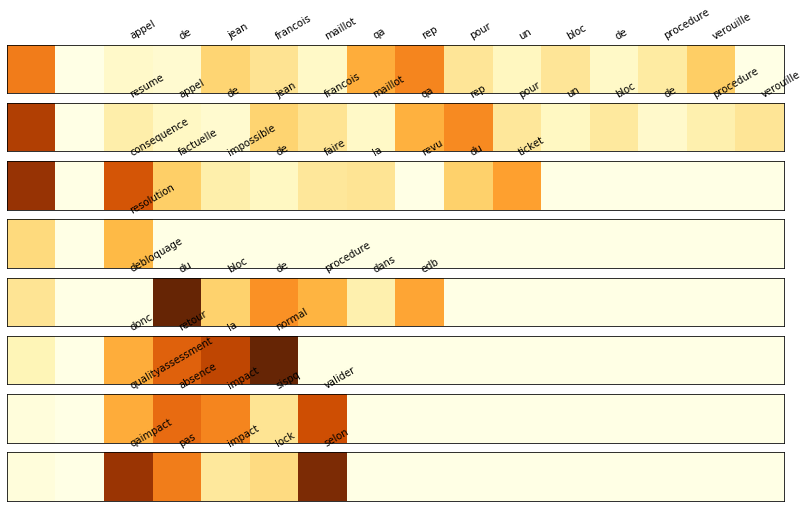

In [110]:
i = 198


description = X_tst_torch[i]
target = Y_tst_torch.data[i].numpy()
target = [int(val) for val in target]

model.showAttention(description, target, liste = Analyse_list, fig_size = (15,10), maxi = 1)

### 4.6 Analyse des erreurs

In [111]:
from sklearn.metrics import confusion_matrix

In [112]:
repartition_erreurs_tst = repartitionErreurs(model, X_tst_torch, Y_tst_torch, n_classes = 14)
[len(el) for el in repartition_erreurs_tst.values()]

[7, 0, 4, 0, 4, 10, 10, 3, 0, 5, 2, 1, 1, 2]

In [113]:
true = Y_tst_torch.view(-1).numpy().tolist()
predicted = [model(x)[0].tolist() for x in X_tst_torch]

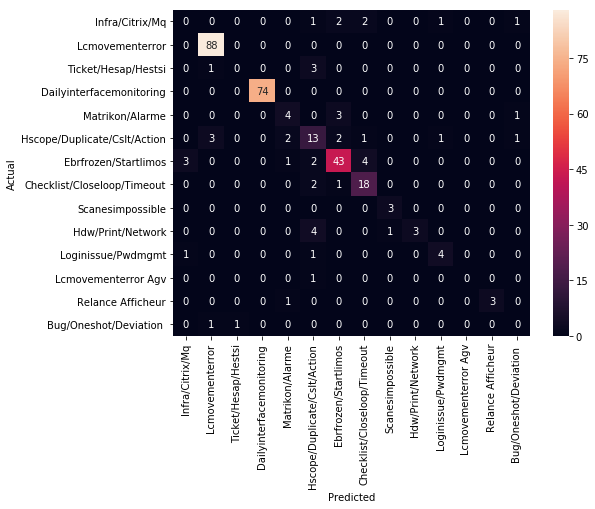

In [114]:
conf_mat = confusion_matrix(true, predicted)
fig, ax = plt.subplots(figsize = (8, 6))
sns.heatmap(conf_mat, annot = True, fmt = 'd', xticklabels = Analyse_list, yticklabels = Analyse_list)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


 Répartition en test 

[7, 0, 4, 0, 4, 10, 10, 3, 0, 5, 2, 1, 1, 2]
[7, 88, 4, 74, 8, 23, 53, 21, 3, 8, 6, 1, 4, 2]

 en train 

[7, 8, 1, 1, 3, 15, 16, 11, 0, 2, 0, 0, 0, 0]
[26, 349, 15, 293, 29, 92, 208, 82, 9, 31, 21, 4, 14, 6]


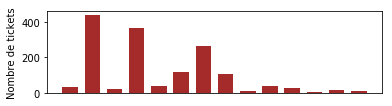

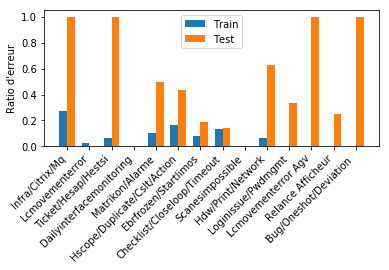

In [115]:
def computePartition(Y) :
    partition = {}
    lis = list(np.unique(Y))
    lis = [int(el) for el in lis]
    for j in lis :
        partition[j] = []
    for i in range(len(Y)):
        j = int(Y[i])
        partition[j].append(i)
    return partition

def compteErreursML(predicted, Y) :
    erreurs = [0 for i in range(len(np.unique(Y)))]
    for i, rep in enumerate(Y) :
        if predicted[i] != rep :
            erreurs[rep] += 1 
    return erreurs

print('\n Répartition en test \n')
true = Y_tst_torch.view(-1).numpy().tolist()
predicted = [model(x)[0].tolist() for x in X_tst_torch]
erreurs_tst = compteErreursML(predicted, true)
#erreurs_tst = repartitionErreurs(model, X_tst_torch, Y_tst_torch, n_classes = 14)
print(erreurs_tst)
partst = computePartition(Y_tst)
distrib_tst = [len(er) for er in partst.values()]
print(distrib_tst)

print('\n en train \n')
true = Y_dev_torch.view(-1).numpy().tolist()
predicted = [model(x)[0].tolist() for x in X_dev_torch]
erreurs_dev = compteErreursML(predicted, true)
#erreurs_dev = repartitionErreurs(model, X_dev_torch, Y_dev_torch, n_classes = 14)
print(erreurs_dev)
partrn = computePartition(Y_dev)
distrib_dev = [len(er) for er in partrn.values()]
print(distrib_dev)

percent_errs_tst = [a/b for a, b in zip(erreurs_tst, distrib_tst)]
percent_errs_dev = [a/b for a, b in zip(erreurs_dev, distrib_dev)]

distrib = [a + b for (a, b) in zip(distrib_tst, distrib_dev)]

height1 = percent_errs_dev
height2 = percent_errs_tst

n_en_tete = len(Analyse_list) # len(np.unique(list(Analyse_dict_nv1.values()))) # 
ind = np.arange(n_en_tete)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

plt.figure(num=0, figsize=(6, 1.5))
plt.bar(ind, distrib, width*2, color = 'brown')
plt.tick_params(axis='x',  which='both', bottom=False, top=False, labelbottom=False)
plt.ylabel("Nombre de tickets")
plt.show()

plt.figure(num=1, figsize=(6, 2.5))
# l'un sur l'autre
#p1 = plt.bar(ind, height1, width)
#p2 = plt.bar(ind, height2, width, bottom=height1)

# l'un à coté de l'autre
p1 = plt.bar(ind- width/2, height1, width)
p2 = plt.bar(ind+ width/2, height2, width)

en_tete = Analyse_list #Analyse_dict_nv1.keys() # 

plt.ylabel("Ratio d'erreur")
plt.xticks(ind, en_tete, rotation = 45, horizontalalignment = 'right')
#plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0]), ('Train', 'Test'))

plt.show()

In [116]:
def compteParTops(model, X, Y, n_classes) :
    ranks = [0 for i in range(n_classes)]
    for x, y in zip(X, Y) :
        p = model(x)[1].data
        p_sorted = sorted(zip(np.arange(n_classes), p), key = lambda x : x[1], reverse = True)
        for i in range(n_classes) :
            if p_sorted[i][0] == y :
                ranks[i] += 1
                break
    return ranks

In [117]:
ranking = compteParTops(model, X_tst_torch, Y_tst_torch, n_classes = 14)
repart = [sum(ranking[:i])*100/sum(ranking) for i in range(1, 15)]
print(repart)

[83.7748344370861, 90.39735099337749, 94.37086092715232, 95.69536423841059, 97.35099337748345, 98.34437086092716, 98.67549668874172, 98.67549668874172, 99.33774834437087, 99.33774834437087, 100.0, 100.0, 100.0, 100.0]


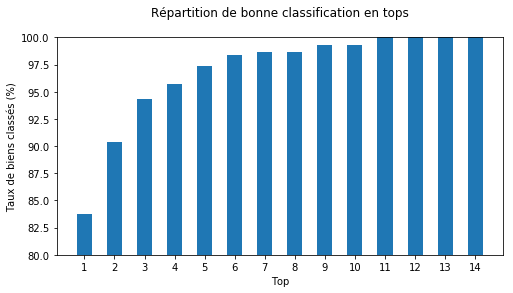

In [118]:
ind = np.arange(14)    # the x locations for the groups

plt.figure(num=0, figsize=(8, 4))
plt.bar(ind, repart, width = 0.5)
#plt.tick_params(axis='both', which='both',  top=False, labelbottom=False)
plt.title('Répartition de bonne classification en tops\n')
plt.ylabel("Taux de biens classés (%)")
plt.xlabel("Top")
plt.xticks(ind, np.arange(1, 15))
plt.axis(ymin = 80, ymax = 100)#plt.axis('tight')
plt.show()